# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
print("hello lane lines")

hello lane lines


## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


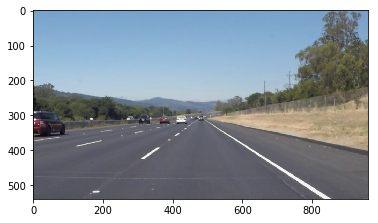

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)

# if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
plt.imshow(image)

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def draw_lines_improve(img, lines, color=[255, 0, 0], thickness=5):
    
    # For polyfit()
    left_lines_x = []
    left_lines_y = []
    right_lines_x = []
    right_lines_y = []
    
    for line in lines:
        for x1, y1, x2, y2 in line: 
            if (x2-x1) == 0 or (y2-y1) == 0:
                continue
            slope = ((y2-y1)/(x2-x1))
            # slope > 0, the line is in the right
            if slope > 0:
                right_lines_x.append(x1)
                right_lines_x.append(x2)
                right_lines_y.append(y1)
                right_lines_y.append(y2)
            # slope < 0, the line is in the left
            elif slope < 0:
                left_lines_x.append(x1)
                left_lines_x.append(x2)
                left_lines_y.append(y1)
                left_lines_y.append(y2)
    
    #Least squares polynomial fit and draw the right line
    print("right_lines_x = ", right_lines_x)
    print("right_lines_y = ", right_lines_y)
    if right_lines_x != []:
        right_m, right_b = np.polyfit(right_lines_x, right_lines_y, 1)
        right_y1 = img.shape[0]
        right_x1 = int((img.shape[0] - right_b)/right_m)
        right_y2 = int(img.shape[0]*0.6) # only draw 60%
        right_x2 = int((right_y2 - right_b)/right_m)
        cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color, thickness)
    
    print("left_lines_x = ", left_lines_x)
    print("left_lines_y = ", left_lines_y)
    #Least squares polynomial fit and draw the left line
    if left_lines_x != []:
        left_m, left_b = np.polyfit(left_lines_x, left_lines_y, 1)
        left_y1 = img.shape[0]
        left_x1 = int((img.shape[0] - left_b)/left_m)
        left_y2 = int(img.shape[0]*0.6)
        left_x2 = int((left_y2 - left_b)/left_m)
        cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), color, thickness)    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, improve=False):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if improve == False:
        draw_lines(line_img, lines)
    else:
        draw_lines_improve(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['whiteCarLaneSwitch.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteRight.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

whiteCarLaneSwitch.jpg
right_lines_x =  [472, 884, 488, 856, 494, 883]
right_lines_y =  [310, 538, 314, 535, 315, 539]
left_lines_x =  [195, 488, 176, 478, 378, 486]
left_lines_y =  [538, 309, 539, 311, 389, 308]


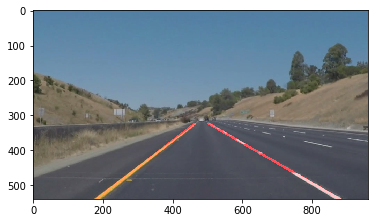

solidYellowLeft.jpg
right_lines_x =  [461, 765, 457, 783, 468, 769, 467, 767]
right_lines_y =  [295, 492, 296, 492, 290, 493, 291, 493]
left_lines_x =  [251, 419, 138, 441, 212, 486, 189, 482, 165, 493]
left_lines_y =  [473, 351, 539, 334, 501, 295, 517, 297, 534, 296]


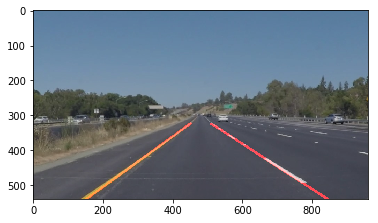

solidYellowCurve2.jpg
right_lines_x =  [447, 874, 455, 851, 486, 776]
right_lines_y =  [293, 539, 291, 538, 306, 494]
left_lines_x =  [228, 490, 160, 457, 180, 260]
left_lines_y =  [500, 302, 538, 323, 538, 477]


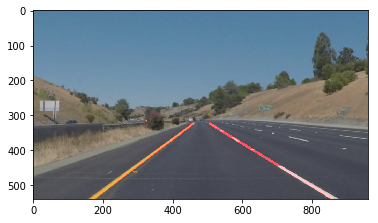

solidWhiteCurve.jpg
right_lines_x =  [485, 898, 483, 877, 490, 897]
right_lines_y =  [309, 538, 311, 538, 313, 539]
left_lines_x =  [293, 486, 281, 487]
left_lines_y =  [462, 300, 459, 303]


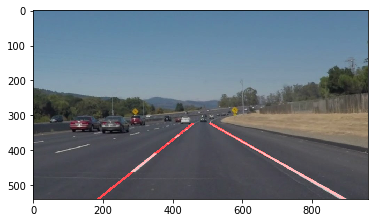

solidYellowCurve.jpg
right_lines_x =  [449, 648, 451, 787]
right_lines_y =  [295, 419, 294, 496]
left_lines_x =  [274, 483, 154, 454, 172, 478, 250, 473]
left_lines_y =  [465, 308, 538, 328, 525, 310, 483, 309]


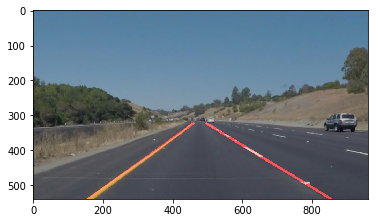

solidWhiteRight.jpg
right_lines_x =  [480, 853, 473, 790, 501, 853, 472, 832]
right_lines_y =  [306, 539, 304, 510, 318, 538, 304, 538]
left_lines_x =  [162, 490]
left_lines_y =  [523, 302]


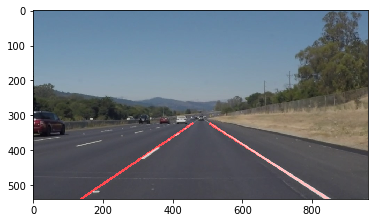

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.


for image in os.listdir("test_images/"):
    print(image)
    save_image = "test_images_output/" + image
    image = mpimg.imread("test_images/" + image)
    imshape = image.shape
    
    gray_image = grayscale(image)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray_image = gaussian_blur(gray_image, kernel_size)
    
    # Define our parameters for Canny and apply
    low_threshold = 110 #60
    high_threshold = 150 #150
    edges = canny(blur_gray_image, low_threshold, high_threshold)
    
    #defining a four sided polygon to mask
    vertices = np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 #1 distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 110     #1 minimum number of votes (intersections in Hough grid cell)
    min_line_len = 30 #5 minimum number of pixels making up a line
    max_line_gap = 150    #1 maximum gap in pixels between connectable line segments
    line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap, improve=True)
  
    lines_edges = weighted_img(line_img, image)

    plt.imshow(lines_edges)
    #if there is not plt.show(), the code only can show the last picture. 
    plt.show()
    
    plt.savefig(save_image)

    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image, improve=False):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    imshape = image.shape
    
    gray_image = grayscale(image)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray_image = gaussian_blur(gray_image, kernel_size)
    
    # Define our parameters for Canny and apply
    low_threshold = 110
    high_threshold = 150
    edges = canny(blur_gray_image, low_threshold, high_threshold)
    
    #defining a four sided polygon to mask
    vertices = np.array([[(0,imshape[0]), (450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 #1 distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 100     #1 minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 #5 minimum number of pixels making up a line
    max_line_gap = 150    #1 maximum gap in pixels between connectable line segments
    line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap, improve)
  
    result = weighted_img(line_img, image)
    
    return result

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:12<00:00, 17.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 1.92 s, sys: 223 ms, total: 2.14 s
Wall time: 14.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
def process_image_improve(image, improve=True):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    imshape = image.shape
    
    gray_image = grayscale(image)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray_image = gaussian_blur(gray_image, kernel_size)
    
    # Define our parameters for Canny and apply
    low_threshold = 100
    high_threshold = 150
    edges = canny(blur_gray_image, low_threshold, high_threshold)
    
    #defining a four sided polygon to mask
    vertices = np.array([[(0,imshape[0]), (450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 #1 distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 100     #1 minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 #5 minimum number of pixels making up a line
    max_line_gap = 150    #1 maximum gap in pixels between connectable line segments
    line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap, improve)

    result = weighted_img(line_img, image)
    
    return result

In [11]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image_improve)
%time yellow_clip.write_videofile(yellow_output, audio=False)

right_lines_x =  [467, 759, 466, 774, 505, 755]
right_lines_y =  [293, 497, 295, 495, 314, 496]
left_lines_x =  [148, 457, 124, 501, 264, 444, 433, 498, 105, 210, 126, 461]
left_lines_y =  [511, 325, 538, 302, 449, 336, 342, 303, 539, 474, 538, 321]
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  1%|          | 5/682 [00:00<00:15, 43.44it/s]

right_lines_x =  [467, 759, 466, 774, 505, 755]
right_lines_y =  [293, 497, 295, 495, 314, 496]
left_lines_x =  [148, 457, 124, 501, 264, 444, 433, 498, 105, 210, 126, 461]
left_lines_y =  [511, 325, 538, 302, 449, 336, 342, 303, 539, 474, 538, 321]
right_lines_x =  [474, 815, 472, 831, 537, 813]
right_lines_y =  [297, 535, 299, 532, 342, 535]
left_lines_x =  [106, 498, 171, 501, 164, 497, 127, 461, 127, 458]
left_lines_y =  [538, 303, 509, 302, 502, 302, 538, 321, 539, 324]
right_lines_x =  [472, 839, 474, 819]
right_lines_y =  [300, 538, 297, 539]
left_lines_x =  [107, 501, 128, 456, 354, 462, 143, 472, 259, 452, 187, 504]
left_lines_y =  [538, 302, 539, 326, 389, 319, 529, 307, 455, 330, 489, 306]
right_lines_x =  [472, 840, 474, 817]
right_lines_y =  [299, 538, 297, 537]
left_lines_x =  [132, 497, 147, 461, 203, 458, 374, 435]
left_lines_y =  [539, 302, 517, 321, 483, 324, 378, 339]
right_lines_x =  [517, 821, 518, 817]
right_lines_y =  [326, 539, 326, 521]
left_lines_x =  [115, 45

  2%|▏         | 14/682 [00:00<00:15, 42.76it/s]

right_lines_x =  [472, 678, 520, 665]
right_lines_y =  [298, 427, 326, 427]
left_lines_x =  [121, 441, 199, 445, 203, 463, 177, 459]
left_lines_y =  [538, 338, 501, 335, 498, 316, 504, 321]
right_lines_x =  [521, 679, 507, 701, 501, 685]
right_lines_y =  [327, 426, 315, 440, 307, 440]
left_lines_x =  [163, 457, 144, 440, 143, 444, 294, 451]
left_lines_y =  [514, 323, 539, 339, 538, 335, 431, 329]
right_lines_x =  [508, 708, 471, 730, 505, 716]
right_lines_y =  [315, 455, 297, 458, 312, 460]
left_lines_x =  [144, 500, 124, 455, 159, 502, 144, 443]
left_lines_y =  [539, 299, 539, 324, 515, 300, 538, 336]
right_lines_x =  [514, 755, 471, 767, 524, 751, 472, 767]
right_lines_y =  [321, 484, 298, 482, 330, 483, 297, 481]
left_lines_x =  [146, 500, 227, 502, 126, 451, 344, 461, 125, 502, 145, 500]
left_lines_y =  [539, 300, 473, 301, 539, 328, 399, 317, 538, 303, 538, 299]
right_lines_x =  [472, 819, 514, 801, 467, 819]
right_lines_y =  [296, 513, 322, 516, 303, 514]
left_lines_x =  [170, 44

  4%|▎         | 24/682 [00:00<00:15, 42.95it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [154, 433, 154, 449, 136, 451, 156, 499]
left_lines_y =  [538, 343, 527, 328, 539, 326, 539, 298]
right_lines_x =  [509, 731]
right_lines_y =  [317, 461]
left_lines_x =  [155, 499, 136, 449, 178, 446, 246, 443, 193, 499]
left_lines_y =  [539, 298, 538, 327, 511, 330, 476, 333, 513, 299]
right_lines_x =  [517, 766, 469, 755]
right_lines_y =  [323, 479, 296, 482]
left_lines_x =  [135, 494, 155, 495, 154, 499]
left_lines_y =  [539, 296, 537, 298, 538, 297]
right_lines_x =  [471, 826, 470, 812]
right_lines_y =  [293, 515, 295, 517]
left_lines_x =  [153, 418, 134, 494, 133, 451]
left_lines_y =  [538, 352, 539, 296, 538, 323]
right_lines_x =  [470, 697, 469, 687]
right_lines_y =  [294, 436, 295, 436]
left_lines_x =  [153, 409, 133, 494, 152, 495, 132, 452]
left_lines_y =  [539, 359, 539, 296, 538, 298, 538, 322]
right_lines_x =  [470, 725, 469, 713]
right_lines_y =  [294, 453, 295, 453]
left_lines_x =  [152, 428, 161, 447, 132, 450, 153

  5%|▍         | 33/682 [00:00<00:15, 42.42it/s]

right_lines_x =  [469, 871, 508, 852, 514, 851]
right_lines_y =  [297, 538, 314, 538, 320, 539]
left_lines_x =  [138, 498, 202, 421, 228, 459, 223, 450, 159, 465]
left_lines_y =  [538, 296, 509, 350, 490, 316, 483, 324, 539, 309]
right_lines_x =  [508, 854, 465, 875]
right_lines_y =  [313, 538, 301, 538]
left_lines_x =  [140, 499, 161, 495, 210, 457]
left_lines_y =  [538, 296, 539, 296, 504, 317]
right_lines_x =  [470, 877, 469, 857]
right_lines_y =  [295, 539, 296, 538]
left_lines_x =  [142, 499, 162, 498, 209, 456, 182, 494]
left_lines_y =  [537, 296, 539, 295, 505, 318, 511, 293]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [141, 500, 162, 496, 165, 458, 141, 416]
left_lines_y =  [538, 296, 539, 296, 536, 316, 539, 353]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [163, 496, 142, 500, 318, 453, 283, 495, 244, 463]
left_lines_y =  [538, 296, 538, 297, 419, 321, 453, 294, 481, 310]
right_lines_x =  [504, 755]
right_lines_y =  [307, 470]
left_lines_x =  [190, 495,

  6%|▌         | 38/682 [00:00<00:15, 42.47it/s]

right_lines_x =  [467, 746, 506, 678, 503, 730]
right_lines_y =  [297, 458, 310, 426, 306, 459]
left_lines_x =  [240, 452, 167, 407, 147, 218, 264, 467]
left_lines_y =  [474, 320, 539, 358, 539, 488, 468, 304]
right_lines_x =  [466, 786, 511, 770, 467, 786, 501, 726]
right_lines_y =  [298, 483, 315, 483, 297, 481, 304, 456]
left_lines_x =  [247, 452, 173, 388, 167, 493, 209, 453, 147, 188, 400, 495]
left_lines_y =  [469, 320, 535, 373, 539, 293, 496, 319, 538, 509, 362, 295]
right_lines_x =  [520, 840, 580, 823, 621, 840, 467, 841]
right_lines_y =  [321, 513, 363, 515, 387, 514, 297, 513]
left_lines_x =  [246, 451, 167, 412, 147, 238, 168, 356, 167, 494, 247, 469]
left_lines_y =  [469, 320, 538, 353, 539, 473, 539, 397, 523, 294, 479, 300]
right_lines_x =  [467, 884, 543, 863, 505, 830]
right_lines_y =  [297, 538, 338, 538, 308, 519]
left_lines_x =  [165, 398, 145, 494, 300, 466, 144, 493, 271, 468]
left_lines_y =  [539, 363, 538, 294, 429, 304, 538, 293, 460, 301]
right_lines_x =  [46

  6%|▋         | 43/682 [00:01<00:20, 30.82it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [164, 417, 149, 495, 143, 433, 263, 458]
left_lines_y =  [539, 348, 535, 293, 538, 335, 466, 308]
right_lines_x =  [511, 738, 525, 639]
right_lines_y =  [317, 459, 328, 402]
left_lines_x =  [145, 494, 166, 493, 254, 491]
left_lines_y =  [538, 294, 539, 293, 463, 291]
right_lines_x =  [502, 777, 516, 650]
right_lines_y =  [310, 482, 323, 410]
left_lines_x =  [145, 494, 176, 493, 173, 468, 255, 490]
left_lines_y =  [538, 294, 531, 293, 533, 303, 462, 292]
right_lines_x =  [502, 827, 476, 645]
right_lines_y =  [311, 514, 290, 408]
left_lines_x =  [146, 493, 166, 492, 241, 460, 188, 462]
left_lines_y =  [537, 294, 539, 293, 472, 313, 509, 310]


  7%|▋         | 50/682 [00:01<00:31, 20.22it/s]

right_lines_x =  [515, 699, 507, 690, 475, 689]
right_lines_y =  [323, 434, 316, 435, 291, 435]
left_lines_x =  [166, 492, 145, 493, 236, 459, 146, 197, 367, 459]
left_lines_y =  [539, 294, 538, 294, 476, 314, 539, 502, 392, 309]
right_lines_x =  [503, 660, 517, 726, 475, 684]
right_lines_y =  [311, 417, 324, 450, 291, 432]
left_lines_x =  [168, 492, 145, 439, 177, 485, 238, 457]
left_lines_y =  [537, 293, 538, 332, 530, 290, 474, 315]
right_lines_x =  [508, 761, 517, 762, 560, 749]
right_lines_y =  [316, 468, 323, 471, 353, 471]
left_lines_x =  [189, 489, 165, 492, 144, 493, 171, 467, 165, 490]
left_lines_y =  [508, 290, 539, 293, 538, 294, 534, 303, 538, 293]
right_lines_x = 

  8%|▊         | 53/682 [00:01<00:33, 18.79it/s]

 [518, 809, 533, 793, 507, 741]
right_lines_y =  [323, 498, 335, 498, 315, 467]
left_lines_x =  [150, 264, 165, 492, 166, 484, 164, 490, 144, 492]
left_lines_y =  [535, 453, 539, 293, 538, 290, 538, 293, 538, 294]
right_lines_x =  [509, 873, 518, 857, 533, 855, 503, 768, 454, 845]
right_lines_y =  [317, 536, 325, 537, 336, 537, 312, 484, 291, 517]
left_lines_x =  [165, 491, 238, 490, 144, 492, 165, 490, 316, 449]
left_lines_y =  [539, 294, 473, 290, 539, 295, 538, 293, 416, 322]
right_lines_x =  [463, 877, 722, 857, 502, 781]
right_lines_y =  [290, 539, 457, 538, 311, 492]
left_lines_x =  [143, 491, 164, 444, 306, 483]
left_lines_y =  [538, 294, 539, 328, 433, 290]
right_lines_x =  [453, 877, 523, 856, 468, 794]
right_lines_y =  [293, 538, 330, 538, 290, 501]
left_lines_x =  [183, 459, 262, 490, 206, 495, 445, 491, 228, 483, 200, 460, 143, 494]
left_lines_y =  [509, 315, 466, 295, 493, 298, 326, 291, 491, 292, 512, 309, 538, 293]


  8%|▊         | 56/682 [00:02<00:36, 17.17it/s]

right_lines_x =  [581, 811, 466, 526, 665, 855, 827, 876]
right_lines_y =  [369, 512, 291, 327, 415, 538, 509, 538]
left_lines_x =  [142, 490, 208, 447, 163, 264, 148, 494, 242, 482]
left_lines_y =  [538, 295, 506, 326, 539, 463, 535, 293, 485, 291]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [142, 456, 161, 334, 277, 495, 373, 482, 380, 491]
left_lines_y =  [538, 318, 538, 412, 453, 294, 382, 291, 377, 291]
right_lines_x =  [466, 715]
right_lines_y =  [291, 446]
left_lines_x =  [141, 452, 162, 490, 226, 445, 393, 485, 231, 465]
left_lines_y =  [539, 321, 539, 292, 492, 327, 362, 293, 477, 307]
right_lines_x = 

  9%|▊         | 58/682 [00:02<00:38, 16.12it/s]

 [465, 636]
right_lines_y =  [290, 405]
left_lines_x =  [142, 457, 162, 283, 232, 452, 176, 492]
left_lines_y =  [538, 317, 538, 450, 488, 322, 529, 291]
right_lines_x =  [464, 787, 464, 652]
right_lines_y =  [290, 491, 292, 414]
left_lines_x =  [141, 457, 162, 491, 258, 486, 305, 490]
left_lines_y =  [539, 317, 539, 291, 468, 290, 432, 297]
right_lines_x =  [464, 680, 476, 668]
right_lines_y =  [290, 425, 291, 425]
left_lines_x =  [140, 460, 253, 489, 160, 277, 424, 491]
left_lines_y =  [539, 314, 469, 297, 538, 453, 338, 291]


  9%|▉         | 62/682 [00:02<00:41, 14.77it/s]

right_lines_x =  [460, 705, 557, 694, 460, 704]
right_lines_y =  [292, 439, 355, 441, 293, 439]
left_lines_x =  [140, 491, 239, 439, 174, 297, 160, 490]
left_lines_y =  [539, 293, 479, 333, 529, 437, 539, 290]
right_lines_x =  [459, 732, 474, 719, 470, 683]
right_lines_y =  [292, 456, 292, 457, 292, 435]
left_lines_x =  [157, 493, 138, 491, 243, 490, 138, 492]
left_lines_y =  [538, 294, 538, 291, 466, 293, 539, 291]
right_lines_x =  [558, 758, 460, 771, 464, 769]
right_lines_y =  [355, 480, 292, 479, 290, 480]
left_lines_x =  [156, 426, 136, 486, 155, 444, 339, 452, 276, 487]
left_lines_y =  [539, 342, 539, 294, 538, 328, 398, 321, 443, 290]
right_lines_x =  [459, 806, 459, 821]
right_lines_y =  [293, 510, 291, 509]
left_lines_x =  [150, 491, 156, 429, 250, 492, 156, 443, 229, 491]
left_lines_y =  [529, 291, 539, 340, 461, 292, 538, 329, 475, 292]


 10%|▉         | 66/682 [00:02<00:40, 15.19it/s]

right_lines_x =  [460, 831, 574, 850, 460, 862]
right_lines_y =  [294, 516, 366, 539, 293, 534]
left_lines_x =  [156, 446, 239, 492, 171, 486, 156, 435]
left_lines_y =  [538, 327, 469, 292, 515, 295, 539, 336]
right_lines_x =  [473, 825, 459, 870, 459, 849]
right_lines_y =  [296, 524, 292, 539, 294, 538]
left_lines_x =  [156, 439, 266, 493, 440, 489, 137, 490, 139, 203]
left_lines_y =  [539, 333, 451, 292, 326, 291, 537, 299, 537, 493]
right_lines_x =  [474, 848, 459, 868]
right_lines_y =  [295, 538, 293, 539]
left_lines_x =  [158, 496, 138, 484, 214, 492, 285, 450]
left_lines_y =  [539, 293, 539, 297, 487, 293, 437, 325]


 10%|█         | 70/682 [00:02<00:41, 14.60it/s]

right_lines_x =  [463, 672]
right_lines_y =  [290, 425]
left_lines_x =  [235, 493, 158, 496, 138, 190, 158, 418, 226, 285]
left_lines_y =  [473, 293, 538, 293, 538, 502, 539, 350, 479, 437]
right_lines_x =  [465, 695]
right_lines_y =  [290, 439]
left_lines_x =  [253, 497, 158, 496, 175, 463, 208, 496, 138, 205]
left_lines_y =  [459, 294, 539, 293, 514, 313, 503, 294, 539, 492]
right_lines_x =  [466, 721, 464, 627]
right_lines_y =  [290, 455, 291, 401]
left_lines_x =  [202, 447, 158, 496, 183, 428, 213, 490, 447, 488, 139, 200]
left_lines_y =  [494, 328, 539, 293, 521, 343, 488, 294, 322, 293, 537, 497]


 11%|█         | 72/682 [00:03<00:40, 15.01it/s]

right_lines_x =  [473, 758, 458, 743]
right_lines_y =  [298, 476, 290, 475]
left_lines_x =  [138, 498, 158, 496, 216, 428, 353, 490]
left_lines_y =  [538, 295, 538, 293, 497, 343, 392, 293]
right_lines_x =  [475, 651, 458, 803]
right_lines_y =  [294, 417, 290, 505]
left_lines_x =  [137, 493, 160, 436, 190, 483]
left_lines_y =  [538, 298, 537, 337, 515, 295]
right_lines_x =  [476, 671, 468, 686]
right_lines_y =  [294, 430, 296, 432]
left_lines_x =  [137, 498, 156, 499, 304, 490, 227, 488, 175, 482]
left_lines_y =  [538, 295, 538, 298, 434, 294, 489, 293, 526, 295]
right_lines_x = 

 11%|█         | 76/682 [00:03<00:40, 15.02it/s]

 [478, 687, 464, 711, 467, 700]
right_lines_y =  [295, 441, 298, 446, 291, 448]
left_lines_x =  [138, 444, 201, 496, 167, 492, 264, 492]
left_lines_y =  [538, 331, 508, 294, 532, 296, 454, 295]
right_lines_x =  [467, 729, 461, 727, 699, 742, 462, 740, 463, 743]
right_lines_y =  [290, 467, 294, 467, 439, 465, 293, 467, 292, 467]
left_lines_x =  [138, 438, 158, 493, 378, 457, 139, 448, 294, 482]
left_lines_y =  [539, 336, 539, 296, 374, 320, 537, 328, 442, 296]
right_lines_x =  [458, 783, 468, 767, 458, 768, 465, 715]
right_lines_y =  [296, 491, 291, 493, 292, 493, 292, 460]
left_lines_x =  [189, 441, 174, 500, 236, 489, 165, 464, 138, 497]
left_lines_y =  [517, 334, 515, 296, 473, 296, 534, 309, 538, 296]
right_lines_x =  [458, 840, 467, 775, 547, 801, 462, 821]
right_lines_y =  [296, 525, 291, 498, 350, 515, 294, 527]
left_lines_x =  [159, 493, 269, 490, 191, 489, 138, 497]
left_lines_y =  [539, 296, 451, 297, 504, 296, 538, 305]


 12%|█▏        | 80/682 [00:03<00:39, 15.38it/s]

right_lines_x =  [457, 861, 462, 823, 468, 793]
right_lines_y =  [296, 539, 294, 528, 291, 510]
left_lines_x =  [138, 497, 218, 419, 158, 492, 339, 486]
left_lines_y =  [538, 296, 496, 350, 539, 296, 402, 296]
right_lines_x =  [457, 860, 458, 840, 468, 795]
right_lines_y =  [296, 538, 291, 539, 291, 511]
left_lines_x =  [203, 489, 158, 492, 194, 493, 310, 491, 138, 208]
left_lines_y =  [495, 295, 539, 296, 513, 296, 422, 296, 539, 490]
right_lines_x =  [458, 840, 464, 817, 811, 860]
right_lines_y =  [291, 539, 293, 513, 509, 539]
left_lines_x =  [157, 243, 235, 489, 157, 491, 199, 493, 137, 497]
left_lines_y =  [538, 476, 473, 296, 539, 296, 509, 296, 538, 295]
right_lines_x =  [466, 674]
right_lines_y =  [292, 427]
left_lines_x =  [164, 491, 242, 488, 137, 491]
left_lines_y =  [534, 297, 468, 296, 538, 300]


 12%|█▏        | 84/682 [00:03<00:38, 15.46it/s]

right_lines_x =  [481, 618, 458, 697]
right_lines_y =  [297, 396, 291, 440]
left_lines_x =  [156, 489, 136, 496, 312, 488, 251, 485, 285, 465]
left_lines_y =  [539, 297, 538, 296, 419, 296, 471, 295, 447, 307]
right_lines_x =  [467, 627, 463, 724]
right_lines_y =  [291, 403, 294, 457]
left_lines_x =  [241, 492, 134, 493, 211, 480, 155, 489, 157, 483, 248, 488]
left_lines_y =  [478, 296, 538, 296, 499, 297, 539, 297, 537, 300, 463, 295]
right_lines_x =  [467, 755, 466, 746]
right_lines_y =  [292, 479, 293, 482]
left_lines_x =  [177, 490, 195, 486, 234, 487, 154, 488, 134, 199]
left_lines_y =  [523, 296, 498, 295, 472, 295, 539, 296, 539, 494]
right_lines_x =  [467, 803, 466, 794, 467, 797]
right_lines_y =  [291, 509, 292, 513, 298, 512]
left_lines_x =  [134, 491, 155, 484, 133, 490, 381, 485]
left_lines_y =  [538, 297, 539, 300, 538, 297, 370, 295]


 13%|█▎        | 88/682 [00:04<00:39, 14.92it/s]

right_lines_x =  [468, 687, 465, 678]
right_lines_y =  [292, 434, 293, 436]
left_lines_x =  [132, 490, 154, 488, 282, 483]
left_lines_y =  [538, 297, 539, 296, 447, 301]
right_lines_x =  [465, 688, 470, 666, 468, 710, 471, 704]
right_lines_y =  [293, 443, 291, 428, 291, 448, 290, 453]
left_lines_x =  [131, 488, 317, 443, 153, 329, 266, 464, 186, 426]
left_lines_y =  [539, 298, 420, 331, 537, 413, 457, 308, 513, 344]
right_lines_x =  [466, 734, 457, 750, 467, 737]
right_lines_y =  [293, 473, 295, 471, 292, 474]
left_lines_x =  [130, 488, 150, 496, 186, 486, 130, 481]
left_lines_y =  [539, 297, 538, 296, 512, 301, 538, 301]


 13%|█▎        | 90/682 [00:04<00:39, 14.97it/s]

right_lines_x =  [465, 797, 658, 778, 463, 782]
right_lines_y =  [294, 501, 423, 501, 295, 502]
left_lines_x =  [148, 488, 159, 488, 150, 438, 129, 488, 179, 326]
left_lines_y =  [538, 299, 519, 298, 537, 335, 539, 297, 517, 418]
right_lines_x =  [466, 859, 467, 836, 457, 783]
right_lines_y =  [294, 539, 299, 538, 290, 493]
left_lines_x =  [205, 488, 150, 435, 130, 488, 130, 488]
left_lines_y =  [489, 299, 538, 338, 539, 298, 538, 297]
right_lines_x =  [456, 780, 470, 835, 457, 857, 468, 798]
right_lines_y =  [290, 492, 292, 539, 298, 538, 293, 516]
left_lines_x =  [200, 488, 151, 439, 131, 485, 281, 488]
left_lines_y =  [493, 299, 538, 336, 539, 300, 446, 301]
right_lines_x =  [458, 855, 471, 834, 469, 818]
right_lines_y =  [290, 538, 303, 538, 294, 529]
left_lines_x =  [153, 433, 133, 488, 152, 490]

 14%|█▍        | 94/682 [00:04<00:39, 14.96it/s]


left_lines_y =  [538, 342, 539, 300, 538, 301]
right_lines_x =  [450, 832, 458, 805]
right_lines_y =  [290, 538, 290, 516]
left_lines_x =  [135, 485, 155, 432, 363, 488, 222, 488]
left_lines_y =  [539, 303, 538, 344, 391, 303, 481, 302]
right_lines_x =  [458, 677]
right_lines_y =  [290, 432]
left_lines_x =  [155, 435, 172, 488, 136, 481]
left_lines_y =  [538, 342, 515, 302, 539, 306]
right_lines_x =  [456, 698]
right_lines_y =  [290, 447]
left_lines_x = 

 14%|█▍        | 96/682 [00:04<00:38, 15.33it/s]

 [155, 487, 201, 488, 136, 497, 210, 302]
left_lines_y =  [538, 305, 496, 303, 539, 295, 500, 437]
right_lines_x =  [456, 726, 453, 709]
right_lines_y =  [290, 465, 290, 462]
left_lines_x =  [196, 488, 157, 488, 157, 206, 137, 488, 236, 497, 435, 497]
left_lines_y =  [500, 303, 537, 305, 538, 503, 539, 302, 484, 295, 336, 294]
right_lines_x =  [468, 757, 458, 747]
right_lines_y =  [296, 484, 291, 486]
left_lines_x =  [155, 429, 137, 488, 137, 488, 185, 487]
left_lines_y =  [538, 346, 539, 303, 538, 302, 519, 300]
right_lines_x =  [470, 653, 451, 817]
right_lines_y =  [295, 423, 290, 518]
left_lines_x =  [137, 488, 156, 310, 204, 488, 137, 488]
left_lines_y =  [538, 301, 538, 430, 506, 300, 539, 302]


 15%|█▍        | 100/682 [00:04<00:37, 15.40it/s]

right_lines_x =  [469, 683, 458, 674]
right_lines_y =  [295, 433, 290, 436]
left_lines_x =  [137, 488, 156, 490, 263, 486]
left_lines_y =  [538, 301, 538, 304, 462, 305]
right_lines_x =  [471, 674, 458, 709, 467, 645, 469, 708]
right_lines_y =  [294, 436, 291, 448, 297, 417, 295, 450]
left_lines_x =  [144, 488, 156, 297, 199, 487, 138, 488, 336, 471, 288, 488]
left_lines_y =  [533, 301, 538, 439, 509, 300, 538, 302, 411, 306, 444, 303]
right_lines_x =  [458, 677, 473, 712, 447, 740, 468, 738]
right_lines_y =  [290, 438, 294, 461, 292, 468, 296, 465]
left_lines_x =  [136, 488, 156, 287, 237, 485, 136, 488, 310, 489, 358, 472]
left_lines_y =  [539, 302, 538, 446, 482, 302, 538, 301, 428, 302, 396, 304]


 15%|█▌        | 104/682 [00:05<00:39, 14.49it/s]

right_lines_x =  [457, 782, 663, 768]
right_lines_y =  [291, 494, 428, 496]
left_lines_x =  [135, 485, 155, 421, 419, 488, 283, 488]
left_lines_y =  [539, 302, 538, 351, 351, 302, 447, 303]
right_lines_x =  [457, 839, 683, 822]
right_lines_y =  [291, 529, 441, 531]
left_lines_x =  [135, 488, 155, 418, 222, 426]
left_lines_y =  [539, 301, 538, 353, 490, 347]
right_lines_x =  [458, 854, 708, 833, 446, 828]
right_lines_y =  [291, 538, 457, 538, 292, 521]
left_lines_x =  [134, 487, 154, 422, 302, 485, 260, 479]
left_lines_y =  [538, 300, 538, 350, 427, 299, 455, 302]


 16%|█▌        | 106/682 [00:05<00:38, 14.94it/s]

right_lines_x =  [458, 856, 472, 834, 741, 833, 458, 855]
right_lines_y =  [290, 538, 294, 538, 478, 538, 291, 539]
left_lines_x =  [154, 488, 196, 487, 133, 487, 286, 471]
left_lines_y =  [537, 303, 497, 301, 539, 300, 446, 307]
right_lines_x =  [458, 855, 473, 787]
right_lines_y =  [291, 539, 294, 506]
left_lines_x =  [154, 487, 153, 488, 133, 242, 153, 401]
left_lines_y =  [525, 301, 538, 303, 538, 465, 539, 365]
right_lines_x =  [458, 686]
right_lines_y =  [291, 433]
left_lines_x =  [133, 487, 153, 416, 414, 486, 145, 490]
left_lines_y =  [539, 301, 538, 354, 349, 300, 529, 305]
right_lines_x =  [469, 693, 458, 710]
right_lines_y =  [297, 448, 292, 449]
left_lines_x =  [215, 484, 154, 392, 153, 487, 436, 480, 277, 444, 132, 247]
left_lines_y =  [485, 304, 539, 372, 538, 304, 333, 303, 442, 333, 539, 462]


 16%|█▌        | 110/682 [00:05<00:37, 15.15it/s]

right_lines_x =  [458, 631, 474, 733]
right_lines_y =  [290, 407, 295, 469]
left_lines_x =  [155, 486, 134, 487, 343, 487, 249, 489]
left_lines_y =  [538, 306, 539, 301, 399, 305, 462, 306]
right_lines_x =  [470, 647, 457, 780]
right_lines_y =  [298, 417, 293, 494]
left_lines_x =  [157, 487, 135, 487, 212, 484, 347, 484]
left_lines_y =  [537, 305, 539, 302, 488, 305, 350, 303]
right_lines_x =  [456, 672, 451, 825]
right_lines_y =  [291, 426, 291, 534]
left_lines_x =  [156, 488, 155, 487, 135, 245, 273, 479, 338, 487]
left_lines_y =  [538, 305, 526, 303, 539, 465, 448, 304, 353, 302]
right_lines_x =  [471, 683, 472, 694]
right_lines_y =  [298, 441, 297, 441]
left_lines_x =  [206, 489, 157, 486, 401, 487, 136, 220, 157, 359, 333, 484]
left_lines_y =  [493, 303, 538, 307, 360, 302, 538, 482, 539, 397, 355, 303]


 17%|█▋        | 114/682 [00:05<00:37, 15.00it/s]

right_lines_x =  [457, 722, 473, 658, 471, 709]
right_lines_y =  [291, 456, 296, 425, 298, 458]
left_lines_x =  [137, 488, 156, 487, 137, 487, 158, 373, 336, 483]
left_lines_y =  [539, 303, 538, 306, 538, 302, 538, 387, 354, 304]
right_lines_x =  [456, 758, 473, 743, 458, 601, 470, 756]
right_lines_y =  [291, 479, 297, 479, 291, 387, 298, 477]
left_lines_x =  [194, 489, 157, 492, 410, 485, 137, 228, 259, 493]
left_lines_y =  [501, 303, 538, 304, 353, 302, 538, 478, 456, 304]
right_lines_x =  [457, 804, 455, 789, 470, 794]
right_lines_y =  [291, 508, 291, 508, 298, 500]
left_lines_x =  [137, 499, 158, 492, 158, 274, 137, 429]
left_lines_y =  [539, 295, 537, 303, 539, 457, 538, 341]
right_lines_x = 

 17%|█▋        | 118/682 [00:06<00:37, 15.04it/s]

 [455, 836, 456, 766, 752, 860, 471, 855]
right_lines_y =  [291, 538, 290, 483, 472, 539, 298, 537]
left_lines_x =  [137, 499, 210, 482, 157, 385, 137, 483, 287, 480]
left_lines_y =  [539, 295, 502, 305, 538, 378, 538, 305, 439, 304]
right_lines_x =  [457, 837, 458, 789, 472, 856, 474, 804]
right_lines_y =  [291, 538, 291, 497, 297, 537, 296, 518]
left_lines_x =  [195, 500, 156, 502, 391, 482, 136, 483, 334, 481]
left_lines_y =  [500, 295, 538, 296, 366, 304, 539, 305, 354, 304]
right_lines_x =  [456, 838, 488, 834, 471, 853, 458, 840]
right_lines_y =  [290, 539, 304, 537, 297, 535, 290, 528]
left_lines_x =  [137, 499, 157, 486, 137, 483, 234, 479, 158, 482]
left_lines_y =  [539, 295, 538, 307, 538, 305, 495, 304, 538, 311]
right_lines_x =  [458, 825, 469, 832]
right_lines_y =  [290, 519, 299, 535]
left_lines_x =  [137, 499, 228, 483, 137, 419, 420, 479, 157, 489]
left_lines_y =  [539, 295, 490, 305, 538, 348, 347, 304, 539, 307]

 18%|█▊        | 120/682 [00:06<00:37, 14.84it/s]


right_lines_x =  [457, 700]
right_lines_y =  [290, 442]
left_lines_x =  [138, 500, 228, 483, 207, 476, 159, 237, 139, 482]
left_lines_y =  [539, 295, 490, 305, 505, 303, 538, 482, 537, 305]
right_lines_x =  [456, 726, 458, 727, 476, 632]
right_lines_y =  [291, 459, 291, 459, 296, 405]
left_lines_x =  [139, 482, 159, 490, 252, 470, 309, 480, 139, 483, 209, 473]
left_lines_y =  [539, 308, 539, 307, 473, 309, 433, 305, 538, 306, 503, 304]
right_lines_x =  [459, 764, 475, 633]
right_lines_y =  

 18%|█▊        | 124/682 [00:06<00:37, 14.82it/s]

[291, 481, 297, 407]
left_lines_x =  [140, 480, 160, 321, 231, 483, 351, 458, 187, 482]
left_lines_y =  [538, 309, 538, 425, 489, 306, 394, 321, 520, 306]
right_lines_x =  [458, 810, 456, 793]
right_lines_y =  [291, 511, 291, 510]
left_lines_x =  [226, 480, 140, 465, 162, 479, 219, 471, 369, 436]
left_lines_y =  [493, 309, 538, 319, 538, 308, 486, 310, 383, 335]
right_lines_x =  [471, 691, 457, 682]
right_lines_y =  [299, 436, 292, 438]
left_lines_x =  [204, 480, 237, 477, 207, 358]
left_lines_y =  [509, 309, 475, 307, 495, 390]
right_lines_x = 

 18%|█▊        | 126/682 [00:06<00:37, 14.64it/s]

 [472, 717, 458, 707, 473, 695]
right_lines_y =  [299, 452, 292, 453, 298, 447]
left_lines_x =  [184, 483, 282, 482, 142, 482, 252, 479, 163, 448]
left_lines_y =  [524, 307, 442, 307, 538, 309, 465, 306, 539, 332]
right_lines_x =  [457, 738, 482, 751, 474, 751]
right_lines_y =  [292, 474, 306, 474, 299, 472]
left_lines_x =  [164, 482, 167, 471, 325, 480]
left_lines_y =  [538, 307, 523, 311, 414, 306]
right_lines_x =  [458, 779, 454, 796, 472, 794]
right_lines_y =  [293, 501, 293, 499, 300, 501]
left_lines_x =  [164, 482, 198, 482, 164, 464, 143, 196, 370, 479]
left_lines_y =  [538, 307, 500, 308, 539, 321, 539, 503, 383, 307]


 19%|█▉        | 130/682 [00:06<00:37, 14.70it/s]

right_lines_x =  [459, 836, 453, 856]
right_lines_y =  [294, 538, 294, 536]
left_lines_x =  [165, 481, 143, 481, 331, 479, 246, 487, 280, 490]
left_lines_y =  [538, 308, 538, 311, 411, 308, 467, 310, 444, 307]
right_lines_x =  [459, 838, 454, 860]
right_lines_y =  [293, 539, 294, 538]
left_lines_x =  [164, 482, 142, 479, 299, 481, 242, 465]
left_lines_y =  [539, 308, 538, 311, 431, 308, 483, 321]
right_lines_x =  [454, 861, 749, 839, 455, 828]
right_lines_y =  [294, 538, 482, 538, 293, 517]
left_lines_x =  [164, 482, 142, 479, 324, 481]
left_lines_y =  [539, 308, 538, 311, 414, 308]
right_lines_x =  [458, 810, 476, 806, 453, 860]
right_lines_y =  [293, 521, 299, 513, 294, 539]
left_lines_x =  [143, 482, 164, 482, 205, 481, 169, 479]
left_lines_y =  [538, 310, 539, 308, 495, 308, 536, 311]


 20%|█▉        | 134/682 [00:07<00:38, 14.10it/s]

right_lines_x =  [456, 688]
right_lines_y =  [293, 432]
left_lines_x =  [163, 478, 142, 478, 154, 460]
left_lines_y =  [539, 310, 538, 311, 529, 322]
right_lines_x =  [456, 714]
right_lines_y =  [293, 448]
left_lines_x =  [163, 304, 142, 263, 313, 478, 198, 478, 141, 412]
left_lines_y =  [538, 436, 539, 457, 423, 308, 514, 311, 538, 355]
right_lines_x =  [471, 733, 472, 743]
right_lines_y =  [301, 471, 300, 469]
left_lines_x =  [164, 480, 142, 478, 342, 458, 288, 476]
left_lines_y =  [539, 309, 539, 312, 402, 323, 450, 314]


 20%|█▉        | 136/682 [00:07<00:39, 13.79it/s]

right_lines_x =  [473, 786, 458, 773, 501, 774]
right_lines_y =  [300, 495, 294, 498, 321, 498]
left_lines_x =  [144, 481, 168, 447, 409, 479, 259, 478]
left_lines_y =  [537, 309, 536, 334, 356, 308, 471, 312]
right_lines_x =  [458, 830, 473, 676]
right_lines_y =  [294, 535, 301, 427]
left_lines_x =  [143, 478, 164, 479, 223, 463, 164, 480, 161, 455]
left_lines_y =  [538, 312, 538, 309, 497, 323, 539, 309, 525, 326]
right_lines_x =  [456, 701, 478, 647, 484, 690]
right_lines_y =  [295, 442, 299, 417, 311, 444]
left_lines_x =  [172, 477, 158, 480, 165, 479, 144, 475]
left_lines_y =  [534, 313, 528, 310, 539, 310, 538, 315]


 21%|██        | 140/682 [00:07<00:38, 14.25it/s]

right_lines_x =  [470, 717, 474, 729]
right_lines_y =  [301, 461, 300, 459]
left_lines_x =  [143, 479, 165, 480, 385, 480, 417, 484, 241, 465]
left_lines_y =  [538, 312, 539, 310, 373, 309, 357, 309, 484, 322]
right_lines_x =  [471, 752, 457, 767, 473, 766]
right_lines_y =  [301, 483, 295, 481, 300, 483]
left_lines_x =  [164, 479, 143, 481, 272, 476, 143, 478, 399, 479]
left_lines_y =  [538, 310, 539, 311, 451, 309, 538, 312, 363, 309]
right_lines_x =  [454, 816, 471, 798]
right_lines_y =  [294, 511, 301, 513]
left_lines_x =  [163, 476, 392, 478, 141, 474]
left_lines_y =  [539, 312, 367, 309, 538, 314]


 21%|██        | 142/682 [00:07<00:36, 14.62it/s]

right_lines_x =  [454, 861, 471, 838, 472, 837]
right_lines_y =  [294, 538, 301, 539, 300, 537]
left_lines_x =  [163, 475, 300, 474, 142, 482, 142, 476]
left_lines_y =  [539, 312, 432, 311, 539, 310, 538, 312]
right_lines_x =  [455, 861, 471, 836, 731, 833]
right_lines_y =  [295, 538, 301, 538, 471, 535]
left_lines_x =  [164, 475, 143, 481, 285, 475, 188, 473]
left_lines_y =  [539, 313, 539, 311, 442, 309, 522, 315]
right_lines_x =  [456, 862, 771, 830]
right_lines_y =  [295, 539, 495, 532]
left_lines_x =  [207, 473, 142, 475, 317, 478, 163, 477]
left_lines_y =  [508, 315, 538, 313, 419, 310, 539, 310]
right_lines_x =  [469, 678, 455, 670]
right_lines_y =  [302, 427, 295, 429]
left_lines_x =  [164, 473, 142, 478, 286, 475, 165, 473]
left_lines_y =  [539, 315, 538, 312, 440, 312, 538, 314]


 21%|██▏       | 146/682 [00:08<00:37, 14.42it/s]

right_lines_x =  [456, 700]
right_lines_y =  [298, 439]
left_lines_x =  [165, 472, 144, 481, 286, 475, 275, 486]
left_lines_y =  [539, 316, 538, 311, 442, 310, 448, 311]
right_lines_x =  [456, 729]
right_lines_y =  [298, 456]
left_lines_x =  [164, 475, 142, 476, 282, 477]
left_lines_y =  [539, 313, 538, 313, 443, 311]
right_lines_x =  [455, 651, 470, 752, 470, 766]
right_lines_y =  [298, 411, 301, 484, 302, 480]
left_lines_x =  [212, 472, 271, 472, 142, 324, 174, 472, 327, 471]
left_lines_y =  [504, 316, 450, 314, 538, 415, 531, 315, 358, 311]
right_lines_x = 

 22%|██▏       | 150/682 [00:08<00:36, 14.72it/s]

 [451, 669, 472, 801]
right_lines_y =  [295, 421, 301, 515]
left_lines_x =  [163, 498, 278, 500, 142, 337, 328, 480]
left_lines_y =  [539, 296, 445, 295, 538, 406, 418, 311]
right_lines_x =  [471, 679, 456, 686]
right_lines_y =  [301, 436, 298, 431]
left_lines_x =  [180, 499, 282, 473, 143, 261, 234, 485, 288, 498, 163, 474]
left_lines_y =  [527, 296, 442, 313, 538, 458, 475, 312, 438, 301, 539, 313]
right_lines_x =  [471, 716, 471, 702]
right_lines_y =  [302, 449, 301, 451]
left_lines_x =  [182, 499, 163, 474, 142, 243, 346, 486, 327, 464]
left_lines_y =  [510, 296, 538, 312, 539, 470, 404, 309, 358, 314]


 22%|██▏       | 152/682 [00:08<00:36, 14.65it/s]

right_lines_x =  [470, 749, 652, 737, 456, 748]
right_lines_y =  [302, 469, 419, 472, 296, 471]
left_lines_x =  [164, 474, 142, 499, 221, 463, 334, 484]
left_lines_y =  [538, 313, 538, 297, 484, 320, 417, 308]
right_lines_x =  [668, 779, 472, 782, 455, 745, 455, 791]
right_lines_y =  [429, 498, 302, 488, 299, 467, 296, 497]
left_lines_x =  [164, 474, 142, 500, 323, 482, 279, 455]
left_lines_y =  [538, 313, 538, 297, 423, 311, 445, 326]
right_lines_x =  [471, 852, 474, 832, 473, 839]
right_lines_y =  [303, 532, 301, 533, 302, 522]
left_lines_x =  [189, 500, 144, 501, 164, 448]
left_lines_y =  [521, 296, 537, 296, 539, 332]


 23%|██▎       | 156/682 [00:08<00:35, 14.82it/s]

right_lines_x =  [472, 865, 718, 843, 449, 816]
right_lines_y =  [302, 538, 460, 538, 297, 509]
left_lines_x =  [144, 502, 254, 499, 165, 471, 166, 471, 352, 503, 223, 478]
left_lines_y =  [538, 297, 473, 301, 538, 316, 539, 317, 396, 297, 484, 318]
right_lines_x =  [472, 865, 753, 843, 456, 760]
right_lines_y =  [303, 539, 482, 538, 297, 479]
left_lines_x =  [168, 485, 208, 471, 168, 471, 166, 451, 147, 205, 421, 482]
left_lines_y =  [539, 309, 497, 313, 538, 318, 524, 331, 538, 499, 357, 313]
right_lines_x =  [487, 864, 801, 842, 470, 810]
right_lines_y =  [312, 538, 513, 539, 305, 509]
left_lines_x =  [167, 471, 147, 478, 308, 486, 172, 470, 207, 491]
left_lines_y =  [538, 317, 538, 315, 436, 311, 536, 312, 513, 291]


 23%|██▎       | 158/682 [00:08<00:35, 14.91it/s]

right_lines_x =  [452, 625]
right_lines_y =  [299, 395]
left_lines_x =  [193, 472, 252, 487, 149, 486, 168, 471, 169, 398]
left_lines_y =  [507, 319, 477, 312, 538, 311, 538, 318, 539, 373]
right_lines_x =  [456, 715]
right_lines_y =  [299, 454]
left_lines_x =  [170, 472, 150, 506, 205, 503, 252, 500]
left_lines_y =  [539, 320, 538, 298, 500, 299, 478, 304]
right_lines_x =  [456, 748, 458, 757]
right_lines_y =  [299, 474, 299, 471]
left_lines_x =  [151, 486, 310, 487, 171, 481, 223, 471, 175, 471]
left_lines_y =  [538, 312, 437, 313, 539, 314, 501, 315, 523, 316]
right_lines_x =  [455, 792, 470, 802]
right_lines_y =  [299, 501, 307, 499]
left_lines_x =  

 24%|██▍       | 162/682 [00:09<00:34, 15.24it/s]

[196, 506, 329, 500, 352, 504, 184, 490, 178, 471, 182, 510]
left_lines_y =  [508, 298, 424, 304, 409, 299, 529, 314, 522, 317, 518, 313]
right_lines_x =  [453, 676, 456, 687, 457, 679]
right_lines_y =  [299, 433, 299, 432, 300, 433]
left_lines_x =  [173, 485, 160, 471, 346, 463, 174, 486]
left_lines_y =  [538, 312, 535, 318, 407, 325, 539, 312]
right_lines_x =  [472, 699, 475, 710]
right_lines_y =  [305, 446, 304, 445]
left_lines_x =  [174, 486, 155, 471, 357, 485, 161, 487]
left_lines_y =  [538, 312, 539, 318, 400, 311, 533, 313]
right_lines_x =  [456, 741, 473, 729]
right_lines_y =  [298, 462, 304, 464]
left_lines_x =  [175, 487, 155, 296, 220, 463, 256, 471]
left_lines_y =  [538, 312, 538, 440, 494, 324, 479, 317]


 24%|██▍       | 166/682 [00:09<00:34, 14.86it/s]

right_lines_x =  [473, 765, 475, 780, 471, 781, 458, 780]
right_lines_y =  [304, 486, 303, 486, 305, 484, 298, 484]
left_lines_x =  [175, 501, 154, 490, 214, 474, 236, 487, 258, 471, 174, 505]
left_lines_y =  [539, 302, 538, 311, 510, 315, 481, 311, 478, 318, 538, 298]
right_lines_x =  [458, 834, 473, 724, 455, 820]
right_lines_y =  [297, 514, 304, 460, 297, 516]
left_lines_x =  [176, 487, 237, 487, 175, 483, 156, 270, 225, 477]
left_lines_y =  [537, 311, 481, 312, 538, 314, 538, 459, 491, 315]
right_lines_x =  [714, 856, 458, 876, 454, 721]
right_lines_y =  [453, 538, 297, 538, 297, 451]
left_lines_x =  [174, 487, 170, 490, 345, 487, 216, 478, 155, 472]
left_lines_y =  [539, 312, 527, 311, 407, 311, 497, 314, 539, 317]


 25%|██▍       | 168/682 [00:09<00:34, 14.90it/s]

right_lines_x =  [746, 857, 458, 877, 474, 822]
right_lines_y =  [471, 538, 297, 538, 303, 504]
left_lines_x =  [174, 502, 201, 503, 155, 501]
left_lines_y =  [539, 301, 508, 297, 539, 297]
right_lines_x =  [456, 871, 474, 884, 788, 857, 472, 879]
right_lines_y =  [296, 535, 303, 539, 497, 539, 303, 538]
left_lines_x =  [157, 502, 175, 502, 176, 491, 179, 491, 330, 474]
left_lines_y =  [539, 297, 538, 301, 539, 310, 522, 311, 419, 315]
right_lines_x =  [472, 693, 458, 684]
right_lines_y =  [303, 430, 296, 431]
left_lines_x =  [158, 503, 178, 491, 279, 447, 370, 504, 158, 502]
left_lines_y =  [538, 297, 538, 311, 454, 340, 398, 297, 539, 298]


 25%|██▌       | 172/682 [00:09<00:34, 14.71it/s]

right_lines_x =  [472, 717, 472, 707]
right_lines_y =  [303, 444, 304, 445]
left_lines_x =  [158, 486, 178, 491, 299, 489, 173, 487, 373, 471]
left_lines_y =  [538, 309, 538, 310, 440, 311, 529, 310, 347, 313]
right_lines_x =  [471, 746, 454, 740]
right_lines_y =  [303, 461, 296, 461]
left_lines_x =  [159, 486, 179, 490, 160, 487, 253, 486]
left_lines_y =  [538, 309, 538, 312, 539, 310, 485, 310]
right_lines_x =  [456, 789, 454, 773]
right_lines_y =  [296, 480, 296, 480]
left_lines_x =  [181, 486, 291, 478, 219, 490, 214, 492, 372, 502, 161, 487]
left_lines_y =  [539, 309, 448, 313, 509, 312, 500, 312, 396, 308, 539, 311]
right_lines_x =  [453, 830, 456, 682, 469, 842]
right_lines_y =  [296, 514, 296, 421, 305, 512]
left_lines_x =  [199, 503, 162, 502, 359, 471, 181, 492, 240, 490]
left_lines_y =  [526, 297, 538, 300, 401, 317, 538, 312, 494, 312]


 26%|██▌       | 176/682 [00:10<00:32, 15.35it/s]

right_lines_x =  [472, 699, 474, 706]
right_lines_y =  [302, 438, 302, 435]
left_lines_x =  [244, 487, 161, 477, 225, 462, 401, 481, 182, 483]
left_lines_y =  [493, 310, 538, 317, 507, 322, 368, 312, 539, 312]
right_lines_x =  [473, 735, 471, 723]
right_lines_y =  [301, 452, 302, 453]
left_lines_x =  [183, 501, 163, 491, 187, 229, 278, 465, 255, 502, 324, 485, 220, 294]
left_lines_y =  [538, 298, 539, 309, 536, 504, 469, 318, 475, 296, 434, 309, 512, 455]
right_lines_x =  [471, 756, 475, 770, 479, 758]
right_lines_y =  [302, 473, 301, 471, 299, 473]
left_lines_x =  [198, 502, 326, 486, 185, 332, 342, 469]
left_lines_y =  [516, 296, 433, 308, 539, 428, 357, 313]
right_lines_x =  [479, 802, 458, 819, 448, 762]
right_lines_y =  [299, 500, 298, 498, 297, 464]
left_lines_x =  [256, 486, 168, 502, 187, 503]
left_lines_y =  [487, 308, 539, 296, 538, 300]


 26%|██▋       | 180/682 [00:10<00:33, 15.04it/s]

right_lines_x =  [473, 865, 726, 884, 455, 884, 452, 877]
right_lines_y =  [302, 537, 444, 535, 296, 534, 296, 532]
left_lines_x =  [218, 480, 271, 464, 169, 502, 188, 502]
left_lines_y =  [517, 313, 466, 321, 539, 297, 538, 301]
right_lines_x =  [475, 869, 454, 890, 453, 889]
right_lines_y =  [302, 538, 296, 538, 296, 538]
left_lines_x =  [180, 502, 190, 268, 213, 483, 283, 464]
left_lines_y =  [532, 298, 539, 478, 522, 311, 458, 321]
right_lines_x =  [454, 891, 458, 870, 458, 863]
right_lines_y =  [296, 538, 299, 537, 296, 521]
left_lines_x =  [171, 503, 191, 480, 245, 502, 242, 470, 321, 508]
left_lines_y =  [538, 297, 539, 314, 498, 298, 488, 317, 365, 300]


 27%|██▋       | 182/682 [00:10<00:33, 15.01it/s]

right_lines_x =  [849, 894, 455, 677, 478, 873, 457, 689]
right_lines_y =  [513, 538, 296, 424, 301, 538, 296, 424]
left_lines_x =  [171, 485, 192, 464, 192, 482, 295, 475]
left_lines_y =  [538, 310, 538, 326, 539, 313, 449, 314]
right_lines_x =  [455, 702]
right_lines_y =  [295, 437]
left_lines_x =  [192, 502, 171, 502, 333, 476, 307, 468]
left_lines_y =  [538, 296, 538, 298, 420, 313, 369, 313]
right_lines_x =  [456, 740, 455, 728]
right_lines_y =  [299, 450, 295, 452]
left_lines_x =  [192, 502, 171, 252, 305, 476, 171, 502]
left_lines_y =  [538, 296, 539, 480, 441, 313, 538, 297]
right_lines_x =  [455, 773, 449, 766]
right_lines_y =  [296, 472, 297, 472]
left_lines_x =  [171, 503, 193, 486, 380, 463, 337, 468]
left_lines_y =  [538, 297, 538, 309, 386, 321, 358, 315]


 27%|██▋       | 186/682 [00:10<00:32, 15.38it/s]

right_lines_x =  [454, 820, 455, 807]
right_lines_y =  [296, 498, 297, 500]
left_lines_x =  [209, 461, 194, 503, 193, 482, 288, 502, 186, 242, 340, 498]
left_lines_y =  [513, 323, 538, 297, 538, 312, 453, 297, 530, 487, 357, 309]
right_lines_x =  [449, 701, 454, 692, 471, 696]
right_lines_y =  [298, 431, 296, 433, 304, 428]
left_lines_x =  [255, 475, 194, 503, 193, 502, 173, 504]
left_lines_y =  [479, 314, 538, 297, 538, 297, 538, 297]
right_lines_x =  [455, 717, 472, 728, 449, 727]
right_lines_y =  [297, 448, 304, 446, 298, 446]
left_lines_x =  [192, 471, 193, 501, 221, 460, 173, 504, 352, 470]
left_lines_y =  [525, 315, 538, 298, 504, 324, 538, 297, 407, 315]
right_lines_x =  [470, 758, 453, 746]
right_lines_y =  [304, 463, 296, 465]
left_lines_x =  [174, 471, 195, 502, 329, 480, 175, 461, 243, 475]
left_lines_y =  [539, 315, 537, 297, 423, 313, 538, 322, 501, 314]


 28%|██▊       | 190/682 [00:11<00:32, 15.08it/s]

right_lines_x =  [453, 788, 470, 803, 454, 803]
right_lines_y =  [296, 489, 304, 489, 301, 487]
left_lines_x =  [303, 476, 193, 502, 220, 475, 174, 471, 212, 370]
left_lines_y =  [443, 313, 538, 297, 505, 313, 539, 315, 525, 398]
right_lines_x =  [452, 843, 470, 858, 446, 860]
right_lines_y =  [296, 521, 303, 518, 298, 518]
left_lines_x =  [174, 475, 197, 484, 176, 457, 194, 324]
left_lines_y =  [539, 312, 534, 310, 537, 325, 539, 434]
right_lines_x =  [468, 874, 470, 894, 454, 874, 446, 841]
right_lines_y =  [304, 538, 303, 538, 297, 539, 298, 508]
left_lines_x =  [275, 475, 197, 479, 174, 473, 194, 443, 309, 462, 174, 247]
left_lines_y =  [464, 314, 534, 313, 539, 314, 539, 337, 448, 325, 538, 483]
right_lines_x =  [452, 873, 469, 894, 445, 893]
right_lines_y =  [296, 539, 304, 539, 299, 537]
left_lines_x =  [227, 473, 179, 471, 194, 484, 173, 251, 173, 459]
left_lines_y =  [513, 314, 535, 315, 537, 310, 538, 480, 539, 323]


 28%|██▊       | 194/682 [00:11<00:33, 14.51it/s]

right_lines_x =  [454, 874, 444, 895]
right_lines_y =  [296, 538, 298, 538]
left_lines_x =  [173, 471, 193, 500, 300, 502, 264, 501, 298, 471, 193, 474]
left_lines_y =  [538, 314, 537, 297, 443, 296, 470, 297, 456, 316, 539, 312]
right_lines_x =  [452, 696]
right_lines_y =  [296, 431]
left_lines_x =  [172, 458, 191, 501, 172, 472, 387, 477]
left_lines_y =  [538, 322, 538, 296, 539, 313, 383, 312]
right_lines_x =  [449, 709]
right_lines_y =  [295, 445]
left_lines_x =  [197, 473, 237, 461, 310, 473, 171, 471]
left_lines_y =  [520, 312, 503, 322, 445, 313, 539, 313]


 29%|██▉       | 198/682 [00:11<00:33, 14.57it/s]

right_lines_x =  [446, 757, 454, 640]
right_lines_y =  [297, 462, 295, 406]
left_lines_x =  [172, 472, 192, 406, 346, 477, 171, 469]
left_lines_y =  [538, 312, 539, 366, 415, 312, 538, 314]
right_lines_x =  [446, 798, 469, 658]
right_lines_y =  [296, 483, 302, 415]
left_lines_x =  [238, 472, 191, 472, 171, 455, 195, 499, 386, 500]
left_lines_y =  [489, 313, 539, 312, 538, 324, 534, 296, 382, 296]
right_lines_x =  [449, 826, 450, 676]
right_lines_y =  [297, 514, 296, 421]
left_lines_x =  [240, 472, 271, 471, 190, 499, 198, 469]
left_lines_y =  [488, 314, 476, 315, 538, 297, 519, 315]


 29%|██▉       | 200/682 [00:11<00:32, 14.79it/s]

right_lines_x =  [451, 706, 449, 696]
right_lines_y =  [296, 437, 296, 439]
left_lines_x =  [235, 472, 344, 469, 170, 467, 203, 468, 288, 470]
left_lines_y =  [491, 313, 416, 318, 539, 315, 529, 315, 462, 315]
right_lines_x =  [449, 726, 450, 735]
right_lines_y =  [296, 456, 296, 454]
left_lines_x =  [188, 476, 267, 472, 169, 255, 169, 467, 243, 470, 222, 457]
left_lines_y =  [538, 313, 467, 313, 538, 474, 539, 315, 497, 314, 500, 323]
right_lines_x =  [469, 758, 443, 764, 448, 772]
right_lines_y =  [303, 476, 298, 469, 297, 476]
left_lines_x =  [203, 466, 187, 476, 342, 469, 352, 472, 167, 499]
left_lines_y =  [513, 315, 538, 313, 416, 316, 353, 312, 538, 297]


 30%|██▉       | 204/682 [00:12<00:32, 14.89it/s]

right_lines_x =  [468, 802, 447, 820, 450, 821]
right_lines_y =  [303, 503, 296, 502, 296, 502]
left_lines_x =  [167, 466, 250, 468, 186, 474, 187, 482]
left_lines_y =  [539, 314, 490, 314, 538, 313, 539, 309]
right_lines_x =  [468, 827, 447, 884, 467, 787]
right_lines_y =  [303, 518, 296, 538, 303, 495]
left_lines_x =  [382, 471, 186, 474, 231, 468, 187, 475, 167, 457, 343, 464]
left_lines_y =  [379, 312, 538, 313, 490, 317, 538, 313, 539, 321, 355, 314]
right_lines_x =  [445, 881, 735, 861, 450, 871]
right_lines_y =  [297, 538, 465, 538, 296, 530]
left_lines_x =  [237, 466, 243, 472, 167, 261, 186, 473, 405, 451, 188, 243, 287, 471, 336, 460]
left_lines_y =  [500, 315, 481, 314, 538, 469, 538, 314, 369, 333, 538, 495, 448, 314, 358, 316]
right_lines_x =  [467, 857, 446, 879]
right_lines_y =  [304, 538, 298, 538]
left_lines_x =  [187, 474, 166, 277, 259, 471, 331, 483, 188, 464]
left_lines_y =  [538, 314, 538, 457, 469, 315, 360, 311, 539, 316]


 30%|███       | 208/682 [00:12<00:32, 14.57it/s]

right_lines_x =  [467, 672, 443, 676]
right_lines_y =  [305, 428, 299, 428]
left_lines_x =  [226, 470, 186, 467, 187, 475, 166, 300]
left_lines_y =  [493, 315, 538, 318, 539, 314, 539, 438]
right_lines_x =  [447, 695]
right_lines_y =  [298, 441]
left_lines_x =  [185, 470, 175, 449, 286, 499]
left_lines_y =  [538, 315, 530, 330, 458, 297]
right_lines_x =  [447, 724, 448, 735]
right_lines_y =  [297, 457, 297, 456]
left_lines_x =  [293, 475, 163, 470, 258, 499, 184, 502, 186, 470, 313, 507]
left_lines_y =  [454, 312, 538, 315, 479, 297, 537, 297, 521, 314, 366, 299]
right_lines_x =  [445, 758, 447, 771]
right_lines_y =  [297, 478, 297, 476]
left_lines_x = 

 31%|███       | 210/682 [00:12<00:32, 14.72it/s]

 [162, 467, 200, 502, 183, 458, 311, 502, 194, 498]
left_lines_y =  [539, 317, 524, 296, 539, 324, 367, 301, 514, 301]
right_lines_x =  [445, 808, 447, 820]
right_lines_y =  [297, 506, 297, 504]
left_lines_x =  [161, 470, 180, 501, 313, 507, 274, 472, 160, 499]
left_lines_y =  [538, 314, 538, 296, 366, 299, 468, 314, 538, 300]
right_lines_x =  [451, 681, 442, 651, 467, 690]
right_lines_y =  [296, 434, 298, 409, 303, 432]
left_lines_x =  [160, 469, 179, 501, 180, 499, 314, 499]
left_lines_y =  [539, 314, 538, 296, 537, 296, 365, 302]
right_lines_x =  [449, 704, 445, 715]
right_lines_y =  [296, 449, 297, 446]
left_lines_x =  [159, 468, 179, 447, 280, 475, 183, 470, 338, 460]
left_lines_y =  [539, 314, 538, 336, 461, 314, 522, 314, 357, 315]


 31%|███▏      | 214/682 [00:12<00:30, 15.10it/s]

right_lines_x =  [451, 736, 445, 747, 446, 544]
right_lines_y =  [297, 468, 298, 465, 297, 355]
left_lines_x =  [178, 450, 166, 469, 292, 475, 307, 459]
left_lines_y =  [538, 333, 534, 314, 442, 313, 369, 317]
right_lines_x =  [443, 789, 448, 775, 450, 789]
right_lines_y =  [299, 491, 297, 493, 296, 492]
left_lines_x =  [179, 476, 159, 468, 323, 474, 178, 475, 201, 404, 305, 462]
left_lines_y =  [539, 315, 539, 315, 428, 314, 538, 314, 507, 364, 370, 316]
right_lines_x =  [447, 829, 451, 847, 466, 847]
right_lines_y =  [297, 526, 297, 525, 304, 524]
left_lines_x =  [178, 475, 162, 502, 158, 468, 311, 507, 335, 473]
left_lines_y =  [538, 314, 534, 296, 539, 314, 367, 299, 411, 314]
right_lines_x =  [447, 850, 450, 870, 452, 871]
right_lines_y =  [296, 538, 296, 539, 296, 538]
left_lines_x =  [176, 475, 155, 500, 235, 471, 176, 444]
left_lines_y =  [538, 313, 538, 296, 481, 315, 539, 337]


 32%|███▏      | 218/682 [00:12<00:30, 15.40it/s]

right_lines_x =  [446, 849, 448, 870, 440, 864]
right_lines_y =  [296, 538, 296, 539, 299, 534]
left_lines_x =  [175, 475, 173, 472, 154, 500]
left_lines_y =  [539, 313, 524, 314, 538, 296]
right_lines_x =  [447, 825, 452, 870, 446, 849]
right_lines_y =  [296, 523, 298, 539, 296, 538]
left_lines_x =  [175, 474, 214, 474, 153, 212, 210, 506]
left_lines_y =  [538, 313, 495, 312, 538, 498, 498, 298]
right_lines_x =  [449, 691]
right_lines_y =  [295, 435]
left_lines_x =  [154, 500, 175, 474, 391, 473, 154, 474]
left_lines_y =  [538, 296, 538, 313, 370, 312, 537, 312]
right_lines_x =  [449, 717, 446, 705]
right_lines_y =  [296, 450, 296, 451]
left_lines_x =  [153, 475, 174, 474, 173, 257, 315, 462]
left_lines_y =  [538, 313, 539, 313, 538, 475, 434, 315]


 33%|███▎      | 222/682 [00:13<00:29, 15.64it/s]

right_lines_x =  [443, 750, 467, 737]
right_lines_y =  [297, 467, 303, 471]
left_lines_x =  [174, 475, 171, 481, 152, 506, 233, 479, 151, 474]
left_lines_y =  [523, 313, 538, 312, 537, 298, 492, 313, 538, 312]
right_lines_x =  [444, 793, 467, 770]
right_lines_y =  [296, 490, 303, 492]
left_lines_x =  [217, 475, 171, 488, 151, 505, 345, 469, 151, 475]
left_lines_y =  [493, 313, 538, 308, 537, 298, 411, 311, 539, 312]
right_lines_x =  [452, 667, 443, 677, 472, 669]
right_lines_y =  [295, 429, 297, 427, 301, 429]
left_lines_x =  [186, 500, 172, 501, 336, 466, 151, 475, 298, 444]
left_lines_y =  [515, 296, 538, 299, 418, 313, 539, 312, 446, 336]
right_lines_x = 

 33%|███▎      | 226/682 [00:13<00:30, 14.71it/s]

 [452, 689, 467, 699, 444, 701]
right_lines_y =  [294, 442, 303, 442, 297, 440]
left_lines_x =  [151, 475, 171, 501, 361, 478, 334, 466]
left_lines_y =  [539, 312, 538, 298, 397, 312, 419, 313]
right_lines_x =  [452, 718, 448, 730, 450, 730]
right_lines_y =  [294, 460, 295, 458, 295, 457]
left_lines_x =  [152, 475, 198, 476, 256, 503, 174, 456]
left_lines_y =  [538, 312, 521, 312, 466, 299, 538, 326]
right_lines_x =  [453, 754, 448, 767, 455, 767]
right_lines_y =  [294, 482, 295, 479, 294, 481]
left_lines_x =  [154, 475, 221, 476, 223, 491, 174, 456, 153, 476]
left_lines_y =  [537, 312, 504, 312, 489, 308, 538, 326, 539, 313]


 33%|███▎      | 228/682 [00:13<00:30, 14.76it/s]

right_lines_x =  [452, 800, 470, 818, 449, 812]
right_lines_y =  [293, 510, 301, 510, 294, 503]
left_lines_x =  [152, 477, 173, 476, 152, 476, 208, 446]
left_lines_y =  [539, 312, 539, 310, 538, 311, 513, 334]
right_lines_x =  [454, 813, 448, 870, 487, 847]
right_lines_y =  [294, 518, 295, 538, 313, 538]
left_lines_x =  [151, 476, 172, 456, 186, 493]
left_lines_y =  [538, 310, 539, 325, 514, 307]
right_lines_x =  [454, 848, 447, 867, 449, 872]
right_lines_y =  [293, 539, 295, 537, 294, 538]
left_lines_x =  [172, 476, 151, 474, 157, 493]
left_lines_y =  [539, 310, 538, 311, 534, 307]
right_lines_x =  [454, 848, 447, 873]
right_lines_y =  [292, 538, 294, 539]
left_lines_x =  [239, 476, 171, 474, 171, 458, 225, 490, 151, 477]
left_lines_y =  [475, 309, 539, 311, 538, 322, 485, 306, 538, 310]


 34%|███▍      | 232/682 [00:13<00:29, 15.12it/s]

right_lines_x =  [456, 672, 455, 684]
right_lines_y =  [295, 430, 292, 429]
left_lines_x =  [149, 476, 232, 478, 168, 245, 148, 476, 198, 481]
left_lines_y =  [539, 310, 490, 311, 538, 482, 538, 309, 516, 310]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [147, 475, 167, 480, 356, 477, 210, 478, 150, 476]
left_lines_y =  [538, 309, 538, 311, 399, 311, 506, 311, 537, 309]
right_lines_x =  [451, 738]
right_lines_y =  [294, 460]
left_lines_x =  [228, 476, 167, 479, 166, 477, 147, 258]
left_lines_y =  [483, 310, 538, 312, 538, 312, 538, 461]
right_lines_x =  [452, 759, 455, 777]
right_lines_y =  [294, 486, 294, 487]
left_lines_x =  [170, 479, 147, 504, 343, 476, 167, 478, 252, 476, 168, 473]
left_lines_y =  [537, 313, 538, 298, 405, 312, 539, 313, 467, 311, 525, 312]


 35%|███▍      | 236/682 [00:14<00:28, 15.54it/s]

right_lines_x =  [452, 818, 454, 827]
right_lines_y =  [294, 522, 294, 518]
left_lines_x =  [167, 477, 163, 471, 313, 476]
left_lines_y =  [538, 313, 528, 313, 425, 311]
right_lines_x =  [452, 684, 448, 693]
right_lines_y =  [293, 437, 294, 435]
left_lines_x =  [165, 476, 294, 476, 279, 472, 166, 478, 145, 200, 204, 271, 166, 477]
left_lines_y =  [538, 312, 437, 310, 447, 312, 539, 312, 538, 500, 499, 451, 538, 312]
right_lines_x =  [453, 710, 456, 719, 448, 719]
right_lines_y =  [292, 452, 293, 451, 293, 449]
left_lines_x =  [165, 478, 255, 474, 145, 473, 144, 209]
left_lines_y =  [538, 311, 463, 310, 539, 310, 538, 493]
right_lines_x =  

 35%|███▌      | 240/682 [00:14<00:29, 15.19it/s]

[452, 741, 449, 753, 451, 751]
right_lines_y =  [292, 472, 293, 469, 293, 466]
left_lines_x =  [164, 476, 258, 474, 144, 268, 164, 478]
left_lines_y =  [538, 311, 461, 310, 539, 453, 539, 311]
right_lines_x =  [448, 798, 474, 781, 450, 797]
right_lines_y =  [293, 495, 299, 498, 293, 493]
left_lines_x =  [163, 477, 143, 481, 273, 475, 340, 469]
left_lines_y =  [539, 311, 538, 310, 451, 310, 404, 311]
right_lines_x =  [455, 843, 447, 860, 448, 861]
right_lines_y =  [293, 535, 295, 533, 294, 533]
left_lines_x =  [164, 448, 308, 476, 143, 479, 206, 471]
left_lines_y =  [539, 332, 427, 310, 538, 312, 497, 312]
right_lines_x =  [450, 859, 456, 848, 472, 869]
right_lines_y =  [294, 530, 293, 538, 300, 539]
left_lines_x =  [183, 471, 164, 453, 145, 255, 167, 439, 165, 478, 376, 467]
left_lines_y =  [513, 312, 538, 328, 539, 462, 537, 339, 539, 312, 380, 314]


 36%|███▌      | 244/682 [00:14<00:28, 15.32it/s]

right_lines_x =  [457, 850, 450, 859, 447, 870]
right_lines_y =  [293, 538, 294, 530, 295, 539]
left_lines_x =  [165, 477, 228, 476, 144, 479]
left_lines_y =  [538, 312, 480, 312, 538, 312]
right_lines_x =  [449, 871, 456, 850]
right_lines_y =  [295, 539, 293, 539]
left_lines_x =  [164, 476, 143, 477, 245, 473]
left_lines_y =  [539, 312, 538, 312, 470, 311]
right_lines_x =  [454, 703]
right_lines_y =  [299, 437]
left_lines_x =  [143, 477, 165, 476, 165, 476, 238, 472]
left_lines_y =  [538, 313, 538, 312, 539, 313, 475, 312]
right_lines_x =  [449, 718, 451, 730]
right_lines_y =  [295, 456, 295, 456]
left_lines_x =  [144, 477, 165, 476, 240, 471]
left_lines_y =  [538, 314, 539, 313, 474, 313]


 36%|███▋      | 248/682 [00:14<00:29, 14.85it/s]

right_lines_x =  [449, 753, 454, 761]
right_lines_y =  [296, 478, 295, 479]
left_lines_x =  [166, 477, 146, 455, 145, 478, 189, 466, 221, 468]
left_lines_y =  [539, 314, 537, 328, 538, 314, 522, 314, 499, 313]
right_lines_x =  [449, 636, 454, 643]
right_lines_y =  [296, 408, 295, 408]
left_lines_x =  [280, 475, 143, 476, 329, 477, 164, 293, 165, 476]
left_lines_y =  [445, 313, 538, 314, 421, 314, 538, 447, 539, 313]
right_lines_x =  [446, 659, 452, 632]
right_lines_y =  [297, 415, 295, 407]
left_lines_x =  [143, 476, 325, 477, 165, 475, 208, 442]
left_lines_y =  [538, 313, 424, 314, 539, 313, 508, 338]
right_lines_x =  [445, 677, 457, 666]
right_lines_y =  [297, 426, 297, 427]
left_lines_x =  [143, 477, 246, 487, 143, 473, 165, 464, 198, 476]
left_lines_y =  [539, 314, 479, 310, 538, 316, 539, 314, 515, 313]


 37%|███▋      | 252/682 [00:15<00:28, 14.87it/s]

right_lines_x =  [456, 682, 454, 699]
right_lines_y =  [297, 438, 294, 441]
left_lines_x =  [143, 473, 165, 476, 165, 463, 311, 465]
left_lines_y =  [538, 316, 539, 313, 538, 314, 434, 314]
right_lines_x =  [451, 713, 454, 727, 448, 728]
right_lines_y =  [294, 457, 294, 458, 295, 456]
left_lines_x =  [143, 478, 404, 475, 164, 304, 318, 474, 203, 469]
left_lines_y =  [539, 313, 364, 312, 538, 439, 429, 312, 511, 311]
right_lines_x =  [451, 739, 455, 759, 688, 751]
right_lines_y =  [295, 474, 294, 476, 442, 480]
left_lines_x =  [166, 476, 144, 478, 145, 479, 191, 399]
left_lines_y =  [538, 313, 538, 313, 538, 313, 521, 370]
right_lines_x = 

 37%|███▋      | 254/682 [00:15<00:28, 15.19it/s]

 [452, 796, 453, 812, 448, 812, 445, 681]
right_lines_y =  [295, 509, 294, 509, 296, 506, 297, 433]
left_lines_x =  [167, 475, 145, 480, 316, 476, 167, 477, 208, 472]
left_lines_y =  [538, 314, 539, 313, 422, 314, 539, 314, 497, 313]
right_lines_x =  [446, 866, 686, 846, 449, 702]
right_lines_y =  [297, 539, 443, 539, 296, 442]
left_lines_x =  [168, 477, 146, 480, 275, 464, 351, 454, 147, 209]
left_lines_y =  [538, 314, 538, 313, 462, 315, 398, 328, 539, 496]
right_lines_x =  [445, 863, 452, 843, 446, 864]
right_lines_y =  [297, 539, 295, 539, 297, 538]
left_lines_x =  [266, 478, 169, 474, 148, 473, 198, 474]
left_lines_y =  [457, 314, 538, 317, 539, 312, 505, 312]
right_lines_x =  [445, 864, 451, 809, 457, 843]
right_lines_y =  [297, 539, 295, 518, 297, 538]
left_lines_x = 

 38%|███▊      | 258/682 [00:15<00:28, 15.14it/s]

 [240, 474, 273, 469, 168, 457, 402, 452, 310, 476, 165, 224]
left_lines_y =  [488, 312, 454, 312, 526, 324, 362, 325, 435, 314, 528, 486]
right_lines_x =  [458, 842, 447, 864]
right_lines_y =  [297, 537, 297, 538]
left_lines_x =  [150, 474, 183, 471, 248, 465, 230, 486, 321, 476, 160, 490]
left_lines_y =  [538, 312, 530, 313, 483, 314, 483, 310, 427, 314, 532, 309]
right_lines_x =  [451, 671]
right_lines_y =  [295, 432]
left_lines_x =  [172, 473, 151, 474, 153, 491, 290, 480, 239, 465]
left_lines_y =  [539, 312, 538, 312, 537, 309, 441, 313, 490, 314]
right_lines_x =  [452, 695, 453, 705]
right_lines_y =  [295, 447, 294, 445]
left_lines_x =  [194, 474, 151, 472, 399, 470]
left_lines_y =  [523, 312, 538, 313, 363, 313]


 38%|███▊      | 262/682 [00:15<00:27, 15.12it/s]

right_lines_x =  [457, 725, 454, 736]
right_lines_y =  [297, 465, 294, 463]
left_lines_x =  [172, 472, 152, 278, 275, 468, 152, 475, 236, 472, 179, 474]
left_lines_y =  [539, 313, 539, 450, 452, 312, 538, 312, 478, 312, 534, 312]
right_lines_x =  [453, 763, 455, 775]
right_lines_y =  [295, 489, 294, 486]
left_lines_x =  [250, 475, 151, 472, 171, 456]
left_lines_y =  [481, 312, 538, 313, 539, 325]
right_lines_x =  [453, 818, 457, 829, 450, 673]
right_lines_y =  [295, 523, 295, 518, 296, 425]
left_lines_x =  [152, 474, 172, 377, 311, 475]
left_lines_y =  [538, 313, 539, 385, 436, 313]
right_lines_x =  [453, 684, 456, 695]
right_lines_y =  [295, 439, 294, 438]
left_lines_x =  [151, 474, 172, 288, 199, 478, 287, 476, 401, 469]
left_lines_y =  [538, 312, 538, 451, 517, 314, 452, 314, 362, 314]


 39%|███▉      | 266/682 [00:16<00:27, 14.89it/s]

right_lines_x =  [450, 720, 453, 710, 448, 723]
right_lines_y =  [295, 451, 295, 455, 296, 454]
left_lines_x =  [169, 323, 148, 206, 149, 474, 246, 458, 237, 476]
left_lines_y =  [538, 426, 538, 498, 539, 311, 483, 324, 488, 314]
right_lines_x =  [454, 744, 456, 755, 457, 759]
right_lines_y =  [294, 475, 293, 472, 299, 473]
left_lines_x =  [174, 474, 168, 478, 249, 476, 148, 452]
left_lines_y =  [521, 311, 538, 313, 478, 313, 538, 325]
right_lines_x =  [456, 806, 454, 791, 450, 806]
right_lines_y =  [293, 503, 294, 504, 295, 501]
left_lines_x =  [147, 471, 167, 477, 253, 476, 148, 472]
left_lines_y =  [538, 312, 538, 313, 475, 313, 539, 312]
right_lines_x =  

 39%|███▉      | 268/682 [00:16<00:27, 14.93it/s]

[455, 846, 449, 868, 458, 765, 451, 862]
right_lines_y =  [294, 538, 296, 538, 294, 478, 295, 533]
left_lines_x =  [168, 473, 148, 474, 196, 472]
left_lines_y =  [538, 316, 539, 311, 506, 313]
right_lines_x =  [460, 847, 448, 868, 450, 869, 451, 860]
right_lines_y =  [297, 539, 297, 539, 296, 538, 296, 532]
left_lines_x =  [168, 456, 148, 474, 293, 473, 193, 453]
left_lines_y =  [538, 328, 539, 311, 439, 313, 508, 326]
right_lines_x =  [455, 838, 451, 869, 461, 848]
right_lines_y =  [295, 534, 297, 538, 297, 539]
left_lines_x =  [169, 478, 168, 475, 149, 474]
left_lines_y =  [538, 314, 526, 311, 538, 311]
right_lines_x =  [451, 678]
right_lines_y =  [297, 428]
left_lines_x =  [150, 472, 170, 478, 263, 477, 150, 475]
left_lines_y =  [539, 314, 538, 314, 459, 314, 538, 311]


 40%|███▉      | 272/682 [00:16<00:26, 15.23it/s]

right_lines_x =  [450, 700, 451, 629]
right_lines_y =  [297, 441, 297, 395]
left_lines_x =  [197, 472, 170, 479, 169, 478, 265, 457, 149, 214]
left_lines_y =  [506, 314, 538, 314, 538, 314, 458, 328, 538, 493]
right_lines_x =  [454, 725, 451, 641]
right_lines_y =  [295, 458, 296, 401]
left_lines_x =  [151, 473, 170, 478, 250, 474]
left_lines_y =  [539, 314, 538, 314, 482, 314]
right_lines_x =  [461, 762, 447, 656]
right_lines_y =  [299, 480, 300, 411]
left_lines_x =  [171, 475, 152, 475, 217, 477]
left_lines_y =  [538, 317, 539, 313, 494, 312]
right_lines_x =  [452, 809, 459, 807, 447, 671]
right_lines_y =  [296, 510, 294, 511, 299, 418]
left_lines_x =  [172, 481, 153, 476, 153, 477, 184, 480, 330, 477]
left_lines_y =  [538, 314, 538, 312, 539, 312, 529, 314, 360, 313]


 40%|████      | 276/682 [00:16<00:26, 15.23it/s]

right_lines_x =  [453, 685, 462, 695]
right_lines_y =  [296, 435, 299, 434]
left_lines_x =  [251, 479, 185, 477, 152, 476, 416, 474, 361, 457, 216, 495, 314, 468, 192, 262]
left_lines_y =  [480, 314, 517, 313, 538, 312, 355, 312, 399, 329, 506, 310, 365, 315, 512, 462]
right_lines_x =  [453, 711, 449, 710, 451, 673]
right_lines_y =  [295, 450, 298, 442, 296, 419]
left_lines_x =  [171, 451, 152, 476, 323, 479, 214, 488, 318, 471, 326, 492, 153, 461]
left_lines_y =  [538, 334, 538, 311, 419, 313, 495, 310, 363, 313, 417, 309, 538, 323]
right_lines_x =  [460, 743, 456, 756]
right_lines_y =  [293, 469, 294, 467]
left_lines_x =  [174, 460, 171, 487, 313, 477, 170, 480, 339, 472]
left_lines_y =  [523, 323, 539, 309, 435, 312, 538, 313, 357, 311]
right_lines_x = 

 41%|████      | 280/682 [00:17<00:26, 15.38it/s]

 [449, 800, 460, 784]
right_lines_y =  [297, 492, 293, 495]
left_lines_x =  [239, 475, 170, 481, 151, 477, 202, 479]
left_lines_y =  [478, 313, 538, 312, 539, 311, 514, 312]
right_lines_x =  [453, 847, 455, 862]
right_lines_y =  [296, 532, 295, 530]
left_lines_x =  [171, 482, 152, 474, 224, 444, 169, 489, 329, 473, 303, 492]
left_lines_y =  [539, 313, 539, 313, 501, 335, 525, 309, 360, 313, 447, 293]
right_lines_x =  [447, 876, 768, 854, 448, 805, 460, 826, 462, 852]
right_lines_y =  [300, 538, 487, 539, 299, 497, 294, 523, 294, 537]
left_lines_x =  [171, 474, 152, 474, 216, 479, 314, 476, 270, 471]
left_lines_y =  [538, 318, 539, 314, 507, 302, 365, 313, 468, 317]
right_lines_x =  [447, 875, 452, 854]
right_lines_y =  [301, 538, 297, 539]
left_lines_x =  [154, 476, 250, 474, 174, 475, 206, 459]
left_lines_y =  [538, 313, 481, 318, 539, 312, 516, 326]


 42%|████▏     | 284/682 [00:17<00:27, 14.62it/s]

right_lines_x =  [451, 607, 446, 874, 452, 854]
right_lines_y =  [298, 391, 301, 538, 297, 538]
left_lines_x =  [154, 476, 173, 480, 381, 479, 322, 472, 174, 474]
left_lines_y =  [539, 314, 538, 315, 384, 315, 364, 313, 539, 313]
right_lines_x =  [449, 699, 447, 691]
right_lines_y =  [300, 438, 300, 440]
left_lines_x =  [155, 476, 173, 485, 322, 477, 349, 475]
left_lines_y =  [539, 314, 538, 312, 429, 316, 356, 313]
right_lines_x =  [448, 717, 449, 727]
right_lines_y =  [300, 455, 298, 452]
left_lines_x =  [155, 473, 186, 459, 239, 458, 156, 441, 323, 470]
left_lines_y =  [538, 315, 531, 326, 492, 327, 538, 338, 364, 314]


 42%|████▏     | 286/682 [00:17<00:26, 14.98it/s]

right_lines_x =  [448, 762, 447, 752]
right_lines_y =  [299, 473, 299, 475]
left_lines_x =  [174, 473, 154, 459, 314, 458, 153, 447, 306, 473, 313, 486]
left_lines_y =  [539, 314, 539, 325, 425, 324, 538, 332, 440, 318, 366, 310]
right_lines_x =  [447, 809, 446, 797]
right_lines_y =  [299, 499, 299, 502]
left_lines_x =  [153, 476, 174, 458, 314, 463, 174, 472, 202, 490]
left_lines_y =  [538, 312, 539, 325, 365, 314, 538, 313, 505, 296]
right_lines_x =  [453, 675, 447, 665]
right_lines_y =  [295, 433, 298, 419]
left_lines_x =  [153, 477, 182, 487, 282, 478, 172, 475, 314, 473]
left_lines_y =  [538, 312, 531, 309, 456, 313, 524, 311, 365, 311]
right_lines_x =  [447, 685, 449, 701]
right_lines_y =  [300, 432, 299, 450]
left_lines_x = 

 43%|████▎     | 290/682 [00:17<00:26, 14.65it/s]

 [212, 476, 155, 458, 154, 475, 277, 479, 175, 488]
left_lines_y =  [512, 313, 538, 326, 538, 313, 461, 314, 538, 311]
right_lines_x =  [449, 742, 447, 729, 446, 710]
right_lines_y =  [299, 468, 300, 469, 302, 448]
left_lines_x =  [184, 475, 177, 458, 293, 476, 306, 474, 177, 476, 171, 496, 383, 471]
left_lines_y =  [518, 314, 538, 327, 454, 316, 370, 313, 539, 314, 529, 293, 380, 316]
right_lines_x =  [453, 767, 443, 783, 449, 771, 176, 310]
right_lines_y =  [298, 494, 304, 492, 300, 485, 474, 476]
left_lines_x =  [195, 474, 225, 485, 157, 476, 176, 473, 323, 471, 312, 472, 306, 446]
left_lines_y =  [510, 314, 501, 312, 538, 315, 538, 314, 428, 320, 369, 314, 441, 339]
right_lines_x = 

 43%|████▎     | 292/682 [00:17<00:26, 14.74it/s]

 [452, 763, 449, 838, 447, 822, 447, 824]
right_lines_y =  [297, 491, 299, 524, 301, 526, 300, 526]
left_lines_x =  [155, 475, 232, 485, 230, 490, 304, 463, 176, 475, 194, 493, 156, 476]
left_lines_y =  [538, 314, 496, 312, 501, 298, 371, 316, 538, 313, 526, 293, 538, 314]
right_lines_x =  [449, 864, 447, 843, 797, 842]
right_lines_y =  [298, 538, 300, 538, 511, 538]
left_lines_x =  [162, 477, 176, 456, 181, 472, 196, 490, 150, 485]
left_lines_y =  [533, 313, 539, 328, 537, 318, 534, 296, 537, 311]
right_lines_x =  [447, 845, 448, 865]
right_lines_y =  [299, 538, 298, 539]
left_lines_x =  [177, 477, 154, 457, 177, 478, 173, 241, 155, 476, 307, 475]
left_lines_y =  [538, 312, 538, 326, 539, 313, 523, 476, 537, 312, 369, 311]
right_lines_x =  [446, 845, 447, 804, 440, 867]
right_lines_y =  [299, 538, 298, 504, 302, 538]
left_lines_x =  [154, 477, 196, 476, 346, 486, 155, 457, 315, 487]
left_lines_y =  [538, 312, 523, 312, 411, 309, 537, 325, 365, 309]


 43%|████▎     | 296/682 [00:18<00:24, 15.70it/s]

right_lines_x =  [446, 691]
right_lines_y =  [300, 436]
left_lines_x =  [153, 478, 175, 477, 306, 487, 309, 476, 262, 473]
left_lines_y =  [539, 312, 539, 311, 441, 309, 368, 311, 475, 311]
right_lines_x =  [451, 712, 450, 621]
right_lines_y =  [295, 451, 296, 402]
left_lines_x =  [154, 484, 176, 454, 316, 488, 154, 478, 316, 476]
left_lines_y =  [539, 308, 538, 328, 433, 308, 538, 311, 364, 309]
right_lines_x =  [451, 745, 451, 730]
right_lines_y =  [294, 470, 295, 469]
left_lines_x =  [309, 484, 215, 492, 420, 477, 154, 483, 154, 480, 174, 471]
left_lines_y =  [439, 308, 509, 293, 350, 310, 539, 309, 538, 310, 539, 315]
right_lines_x = 

 44%|████▍     | 300/682 [00:18<00:24, 15.36it/s]

 [452, 788, 449, 647]
right_lines_y =  [294, 496, 295, 418]
left_lines_x =  [175, 478, 154, 483, 270, 487, 315, 492]
left_lines_y =  [539, 310, 538, 308, 466, 308, 435, 292]
right_lines_x =  [451, 677, 450, 667]
right_lines_y =  [294, 430, 295, 430]
left_lines_x =  [154, 483, 175, 472, 328, 485, 193, 490, 175, 483, 317, 493]
left_lines_y =  [539, 308, 539, 315, 426, 308, 510, 309, 538, 298, 434, 292]
right_lines_x =  [451, 699, 450, 689]
right_lines_y =  [295, 444, 296, 445]
left_lines_x =  [184, 485, 175, 490, 329, 492, 155, 483, 315, 469, 314, 481]
left_lines_y =  [519, 309, 538, 310, 426, 294, 538, 309, 365, 312, 437, 312]
right_lines_x =  [447, 728, 486, 718, 455, 716]
right_lines_y =  [298, 460, 317, 462, 293, 462]
left_lines_x =  [155, 485, 175, 490, 302, 489, 350, 484, 329, 477]
left_lines_y =  [539, 308, 538, 309, 444, 308, 410, 298, 360, 310]


 45%|████▍     | 304/682 [00:18<00:24, 15.17it/s]

right_lines_x =  [447, 766, 450, 751, 451, 765]
right_lines_y =  [297, 481, 296, 484, 294, 483]
left_lines_x =  [155, 484, 193, 436, 272, 486, 244, 476, 155, 481]
left_lines_y =  [538, 307, 526, 343, 468, 307, 477, 309, 539, 310]
right_lines_x =  [447, 817, 450, 801, 451, 814, 453, 816, 454, 734]
right_lines_y =  [297, 511, 295, 514, 295, 513, 293, 511, 293, 474]
left_lines_x =  [175, 484, 155, 485, 314, 492]
left_lines_y =  [539, 307, 538, 307, 436, 292]
right_lines_x =  [452, 862, 700, 834, 446, 861]
right_lines_y =  [293, 539, 452, 535, 297, 537]
left_lines_x =  [153, 485, 183, 483, 288, 488, 173, 484]
left_lines_y =  [538, 306, 532, 306, 456, 294, 539, 296]
right_lines_x =  [456, 838, 452, 860, 451, 843, 452, 738]
right_lines_y =  [291, 539, 293, 538, 294, 529, 292, 477]
left_lines_x =  [152, 484, 218, 483, 173, 471, 229, 472]
left_lines_y =  [538, 306, 506, 307, 539, 314, 486, 310]


 45%|████▌     | 308/682 [00:18<00:23, 15.60it/s]

right_lines_x =  [455, 837, 451, 859, 450, 859]
right_lines_y =  [291, 539, 293, 538, 294, 539]
left_lines_x =  [151, 485, 195, 483, 184, 487]
left_lines_y =  [539, 305, 522, 305, 530, 294]
right_lines_x =  [451, 683, 446, 618]
right_lines_y =  [293, 432, 296, 391]
left_lines_x =  [172, 483, 151, 484, 283, 471]
left_lines_y =  [539, 305, 538, 305, 445, 313]
right_lines_x =  [447, 629]
right_lines_y =  [295, 396]
left_lines_x =  [171, 475, 221, 471, 276, 472, 151, 481, 157, 483, 182, 441]
left_lines_y =  [539, 310, 490, 309, 451, 309, 538, 315, 533, 305, 531, 336]
right_lines_x =  [454, 722, 447, 642]
right_lines_y =  [290, 464, 296, 404]
left_lines_x =  [150, 483, 173, 452, 170, 454, 345, 479]
left_lines_y =  [538, 305, 537, 327, 538, 324, 409, 297]


 46%|████▌     | 312/682 [00:19<00:25, 14.74it/s]

right_lines_x =  [453, 646, 445, 657]
right_lines_y =  [290, 415, 296, 413]
left_lines_x =  [148, 478, 169, 477, 324, 483, 149, 479, 266, 492]
left_lines_y =  [538, 307, 538, 306, 424, 305, 538, 307, 467, 291]
right_lines_x =  [449, 675, 452, 824]
right_lines_y =  [293, 424, 292, 524]
left_lines_x =  [146, 478, 292, 472, 259, 486, 167, 489, 166, 487, 428, 477]
left_lines_y =  [539, 307, 447, 312, 471, 294, 539, 305, 538, 305, 340, 305]
right_lines_x =  [454, 629, 464, 684, 448, 698]
right_lines_y =  [291, 404, 291, 439, 294, 438]
left_lines_x =  [172, 478, 209, 485, 146, 477, 166, 487]
left_lines_y =  [521, 307, 506, 305, 539, 307, 538, 305]
right_lines_x = 

 46%|████▌     | 314/682 [00:19<00:25, 14.56it/s]

 [449, 725, 447, 724, 451, 714, 451, 712]
right_lines_y =  [294, 453, 296, 456, 292, 456, 293, 456]
left_lines_x =  [167, 485, 187, 477, 165, 486, 145, 477]
left_lines_y =  [536, 305, 510, 307, 538, 305, 539, 306]
right_lines_x =  [456, 746, 448, 760, 450, 761]
right_lines_y =  [290, 478, 295, 475, 293, 473]
left_lines_x =  [165, 486, 144, 489, 259, 470]
left_lines_y =  [539, 305, 538, 306, 460, 313]
right_lines_x =  [458, 792, 448, 808, 449, 808]
right_lines_y =  [290, 507, 295, 503, 295, 502]
left_lines_x =  [170, 477, 399, 483, 165, 485, 409, 476, 172, 486, 307, 432, 145, 237]
left_lines_y =  [522, 307, 367, 306, 538, 306, 354, 307, 534, 306, 427, 342, 539, 475]


 47%|████▋     | 318/682 [00:19<00:25, 14.49it/s]

right_lines_x =  [452, 844, 454, 860, 454, 859]
right_lines_y =  [293, 538, 292, 536, 293, 536]
left_lines_x =  [171, 473, 166, 484, 263, 485]
left_lines_y =  [522, 311, 538, 307, 457, 307]
right_lines_x =  [449, 868, 452, 844, 455, 856]
right_lines_y =  [296, 538, 293, 538, 292, 533]
left_lines_x =  [257, 478, 166, 485, 150, 477, 274, 451]
left_lines_y =  [463, 309, 538, 307, 537, 308, 461, 328]
right_lines_x =  [449, 868, 462, 844, 659, 856, 451, 835]
right_lines_y =  [296, 538, 290, 538, 415, 533, 294, 533]
left_lines_x =  [147, 476, 167, 486, 172, 487, 350, 486, 166, 484]
left_lines_y =  [539, 308, 539, 307, 520, 307, 399, 297, 538, 307]


 47%|████▋     | 320/682 [00:19<00:24, 14.63it/s]

right_lines_x =  [451, 681, 450, 673]
right_lines_y =  [295, 428, 296, 430]
left_lines_x =  [147, 454, 245, 477, 296, 494, 167, 485, 146, 488]
left_lines_y =  [539, 324, 483, 309, 437, 294, 538, 307, 538, 308]
right_lines_x =  [451, 705, 449, 696]
right_lines_y =  [294, 441, 295, 443]
left_lines_x =  [182, 470, 167, 474, 166, 485, 146, 488, 369, 489]
left_lines_y =  [515, 314, 538, 315, 538, 306, 538, 307, 385, 295]
right_lines_x =  [449, 734, 493, 725]
right_lines_y =  [295, 459, 321, 460]
left_lines_x =  [147, 477, 202, 472, 246, 474, 402, 490]
left_lines_y =  [539, 308, 514, 311, 482, 311, 360, 294]
right_lines_x =  [450, 773, 449, 761]
right_lines_y =  [294, 481, 295, 483]
left_lines_x =  [147, 477, 237, 472, 206, 479, 167, 235]
left_lines_y =  [539, 308, 488, 311, 511, 298, 539, 488]


 48%|████▊     | 324/682 [00:19<00:23, 14.98it/s]

right_lines_x =  [450, 819, 449, 812]
right_lines_y =  [294, 507, 295, 513]
left_lines_x =  [166, 486, 276, 490, 226, 447, 400, 495, 210, 498, 145, 488, 199, 483]
left_lines_y =  [538, 306, 449, 294, 482, 332, 360, 293, 493, 306, 538, 307, 513, 306]
right_lines_x =  [451, 696, 449, 685]
right_lines_y =  [295, 436, 296, 438]
left_lines_x =  [165, 484, 146, 477, 146, 453, 236, 495]
left_lines_y =  [538, 307, 539, 307, 538, 323, 488, 293]
right_lines_x =  [452, 703, 451, 723]
right_lines_y =  [295, 451, 296, 453]
left_lines_x =  [146, 454, 327, 482, 220, 316, 146, 496, 272, 453]
left_lines_y =  [539, 324, 420, 307, 498, 430, 538, 293, 462, 326]
right_lines_x = 

 48%|████▊     | 328/682 [00:20<00:23, 14.81it/s]

 [450, 758, 448, 745]
right_lines_y =  [297, 474, 298, 476]
left_lines_x =  [162, 495, 166, 483, 371, 482, 166, 484]
left_lines_y =  [528, 295, 538, 308, 387, 309, 539, 308]
right_lines_x =  [450, 805, 453, 788, 449, 805]
right_lines_y =  [297, 502, 295, 504, 298, 503]
left_lines_x =  [151, 495, 166, 481, 167, 483]
left_lines_y =  [536, 295, 538, 309, 538, 308]
right_lines_x =  [452, 843, 465, 864, 467, 857, 453, 842]
right_lines_y =  [295, 539, 308, 538, 308, 533, 295, 538]
left_lines_x =  [166, 470, 146, 496, 235, 496, 372, 481, 181, 487]
left_lines_y =  [537, 316, 539, 294, 489, 293, 382, 300, 528, 298]
right_lines_x =  [454, 844, 449, 865, 739, 832, 451, 828]
right_lines_y =  [294, 538, 298, 538, 473, 533, 296, 531]
left_lines_x =  [165, 470, 150, 496, 237, 493, 145, 496]
left_lines_y =  [538, 316, 536, 294, 487, 295, 539, 293]


 49%|████▊     | 332/682 [00:20<00:23, 14.87it/s]

right_lines_x =  [449, 867, 453, 845]
right_lines_y =  [297, 538, 294, 539]
left_lines_x =  [165, 496, 163, 482, 162, 469, 322, 457]
left_lines_y =  [524, 293, 538, 307, 538, 315, 361, 312]
right_lines_x =  [449, 671, 453, 671, 451, 663]
right_lines_y =  [295, 423, 293, 424, 294, 426]
left_lines_x =  [162, 482, 141, 491, 191, 488, 320, 495, 161, 473]
left_lines_y =  [538, 306, 539, 294, 518, 295, 415, 293, 538, 311]
right_lines_x =  [452, 686, 450, 693]
right_lines_y =  [293, 439, 294, 435]
left_lines_x =  [160, 450, 140, 487, 223, 481, 162, 482]
left_lines_y =  [538, 327, 539, 296, 480, 306, 538, 306]


 49%|████▉     | 334/682 [00:20<00:23, 14.67it/s]

right_lines_x =  [451, 712, 453, 722]
right_lines_y =  [294, 457, 293, 455]
left_lines_x =  [160, 472, 248, 471, 139, 481]
left_lines_y =  [539, 312, 463, 312, 538, 307]
right_lines_x =  [447, 650, 456, 746]
right_lines_y =  [299, 411, 293, 481]
left_lines_x =  [201, 497, 139, 470, 210, 468, 261, 485, 158, 271]
left_lines_y =  [509, 294, 538, 315, 489, 315, 464, 307, 538, 458]
right_lines_x =  [451, 789, 450, 667]
right_lines_y =  [296, 507, 297, 422]
left_lines_x =  [138, 472, 183, 485, 158, 276]
left_lines_y =  [538, 313, 520, 308, 538, 455]
right_lines_x =  [452, 678, 452, 589, 447, 665]
right_lines_y =  [296, 437, 297, 376, 300, 421]
left_lines_x =  [138, 472, 240, 484, 382, 487, 181, 496, 137, 498]
left_lines_y =  [539, 314, 479, 308, 375, 299, 521, 308, 538, 295]


 50%|████▉     | 338/682 [00:20<00:22, 15.14it/s]

right_lines_x =  [452, 703, 453, 714, 451, 714]
right_lines_y =  [297, 453, 296, 452, 298, 450]
left_lines_x =  [203, 484, 137, 472, 361, 486, 157, 491]
left_lines_y =  [505, 308, 539, 313, 389, 299, 539, 297]
right_lines_x =  [451, 732, 454, 747, 451, 733]
right_lines_y =  [297, 472, 294, 470, 296, 472]
left_lines_x =  [156, 485, 136, 471]
left_lines_y =  [538, 308, 539, 313]
right_lines_x =  [450, 792, 452, 776]
right_lines_y =  [298, 496, 297, 499]
left_lines_x =  [195, 483, 136, 472, 156, 484]
left_lines_y =  [510, 308, 539, 313, 538, 308]


 50%|█████     | 342/682 [00:21<00:23, 14.25it/s]

right_lines_x =  [452, 839, 450, 799, 458, 835, 457, 812, 448, 854]
right_lines_y =  [296, 537, 299, 501, 293, 537, 294, 524, 300, 534]
left_lines_x =  [306, 473, 156, 484, 136, 498, 252, 486]
left_lines_y =  [426, 314, 538, 308, 539, 295, 462, 299]
right_lines_x =  [452, 839, 455, 860, 454, 771]
right_lines_y =  [297, 538, 295, 538, 296, 486]
left_lines_x =  [157, 485, 201, 473, 137, 283, 157, 486]
left_lines_y =  [538, 308, 496, 313, 538, 440, 539, 308]
right_lines_x =  [452, 839, 649, 861, 459, 838]
right_lines_y =  [296, 538, 411, 538, 293, 539]
left_lines_x =  [157, 486, 261, 474, 136, 498, 156, 485, 338, 475]
left_lines_y =  [538, 308, 456, 313, 538, 294, 538, 308, 405, 313]
right_lines_x =  [819, 861, 452, 839]
right_lines_y =  [514, 538, 296, 538]
left_lines_x =  [156, 484, 137, 472, 136, 224, 178, 493]
left_lines_y =  [538, 308, 539, 313, 538, 479, 524, 296]


 51%|█████     | 346/682 [00:21<00:23, 14.60it/s]

right_lines_x =  [449, 619]
right_lines_y =  [299, 393]
left_lines_x =  [156, 487, 321, 482, 221, 470, 135, 489]
left_lines_y =  [539, 307, 416, 308, 483, 315, 538, 308]
right_lines_x =  [449, 629, 456, 701]
right_lines_y =  [299, 399, 294, 453]
left_lines_x =  [157, 486, 269, 482, 137, 470, 439, 495, 137, 451]
left_lines_y =  [538, 307, 451, 308, 539, 315, 333, 295, 538, 327]
right_lines_x =  [450, 752, 456, 734]
right_lines_y =  [298, 472, 294, 474]
left_lines_x =  [186, 476, 157, 486, 178, 233]
left_lines_y =  [507, 312, 538, 308, 512, 474]
right_lines_x =  [456, 775, 451, 799]
right_lines_y =  [294, 501, 298, 499]
left_lines_x =  [138, 474, 158, 487, 224, 483, 157, 485]
left_lines_y =  [539, 313, 538, 308, 482, 308, 538, 308]


 51%|█████▏    | 350/682 [00:21<00:23, 14.34it/s]

right_lines_x =  [456, 670, 458, 681]
right_lines_y =  [294, 433, 293, 432]
left_lines_x =  [139, 474, 158, 487, 431, 485, 220, 483]
left_lines_y =  [539, 313, 538, 308, 345, 308, 485, 308]
right_lines_x =  [457, 696, 451, 706]
right_lines_y =  [294, 449, 299, 446]
left_lines_x =  [158, 486, 139, 473, 163, 483, 160, 488, 320, 483]
left_lines_y =  [538, 308, 538, 313, 523, 308, 538, 308, 362, 303]
right_lines_x =  [456, 724, 449, 738, 454, 732]
right_lines_y =  [294, 468, 299, 466, 295, 462]
left_lines_x =  [159, 488, 140, 477, 140, 474]
left_lines_y =  [538, 308, 539, 312, 538, 313]


 52%|█████▏    | 352/682 [00:21<00:22, 14.47it/s]

right_lines_x =  [450, 769, 457, 764, 453, 780]
right_lines_y =  [299, 483, 294, 493, 296, 492]
left_lines_x =  [158, 487, 140, 475, 327, 483, 289, 477]
left_lines_y =  [538, 308, 539, 313, 360, 304, 448, 312]
right_lines_x =  [452, 822, 454, 837, 455, 836, 449, 823]
right_lines_y =  [297, 528, 296, 526, 295, 524, 299, 515]
left_lines_x =  [139, 482, 158, 476, 168, 483, 429, 476, 159, 487]
left_lines_y =  [539, 308, 538, 316, 520, 308, 346, 313, 537, 307]
right_lines_x =  [458, 836, 454, 858, 450, 769, 455, 823]
right_lines_y =  [293, 538, 296, 539, 299, 483, 294, 516]
left_lines_x =  [138, 474, 159, 298, 139, 482, 292, 472, 337, 483, 158, 488]
left_lines_y =  [538, 312, 539, 441, 539, 308, 445, 315, 356, 303, 538, 307]
right_lines_x =  [457, 836, 454, 857]
right_lines_y =  [293, 539, 296, 538]
left_lines_x =  [176, 484, 158, 475, 138, 498, 243, 487, 138, 471, 346, 483]
left_lines_y =  [514, 307, 538, 316, 538, 295, 478, 307, 539, 315, 353, 303]


 52%|█████▏    | 356/682 [00:22<00:22, 14.64it/s]

right_lines_x =  [454, 857, 458, 836]
right_lines_y =  [296, 538, 293, 538]
left_lines_x =  [155, 484, 158, 475, 243, 487, 138, 473]
left_lines_y =  [528, 307, 538, 316, 478, 307, 539, 313]
right_lines_x =  [450, 618]
right_lines_y =  [299, 392]
left_lines_x =  [139, 475, 161, 487, 327, 484, 254, 486]
left_lines_y =  [539, 312, 536, 307, 359, 302, 470, 307]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [139, 474, 158, 487, 226, 474, 209, 483]
left_lines_y =  [539, 313, 538, 308, 490, 316, 492, 308]
right_lines_x =  [450, 732, 451, 745]
right_lines_y =  [299, 468, 298, 468]
left_lines_x =  [156, 473, 157, 487, 135, 488, 158, 386, 336, 473]
left_lines_y =  [526, 312, 538, 307, 537, 308, 538, 378, 405, 316]


 53%|█████▎    | 360/682 [00:22<00:21, 14.78it/s]

right_lines_x =  [452, 778, 451, 657]
right_lines_y =  [296, 499, 298, 417]
left_lines_x =  [218, 481, 156, 486, 415, 498, 136, 229, 219, 273, 159, 475]
left_lines_y =  [485, 308, 538, 307, 350, 294, 538, 476, 484, 447, 537, 316]
right_lines_x =  [455, 667, 464, 676]
right_lines_y =  [294, 431, 310, 428]
left_lines_x =  [155, 485, 205, 477, 135, 498, 156, 486, 333, 465]
left_lines_y =  [538, 307, 493, 310, 539, 294, 538, 307, 355, 310]
right_lines_x =  [452, 692, 453, 700]
right_lines_y =  [296, 446, 295, 443]
left_lines_x =  [156, 486, 213, 474, 136, 498, 335, 465]
left_lines_y =  [538, 307, 488, 312, 538, 294, 355, 310]
right_lines_x =  [449, 731, 456, 718, 470, 731]
right_lines_y =  [299, 462, 294, 464, 307, 464]
left_lines_x =  [137, 498, 215, 498, 317, 482, 226, 472, 292, 493, 157, 489]
left_lines_y =  [539, 295, 499, 294, 427, 308, 491, 306, 436, 296, 538, 314]


 53%|█████▎    | 364/682 [00:22<00:20, 15.15it/s]

right_lines_x =  [453, 771, 455, 754, 477, 759, 447, 770]
right_lines_y =  [295, 486, 294, 488, 312, 488, 299, 486]
left_lines_x =  [150, 483, 158, 487, 328, 475, 327, 472]
left_lines_y =  [531, 307, 538, 307, 424, 305, 424, 302]
right_lines_x =  [454, 817, 456, 806, 465, 809, 454, 826]
right_lines_y =  [295, 513, 294, 521, 310, 509, 296, 519]
left_lines_x =  [159, 488, 140, 482, 140, 484, 228, 498]
left_lines_y =  [538, 308, 538, 308, 539, 307, 491, 295]
right_lines_x =  [454, 857, 453, 774, 457, 836, 450, 763]
right_lines_y =  [296, 538, 297, 498, 293, 539, 299, 480]
left_lines_x =  [168, 498, 251, 492, 140, 484, 160, 489, 289, 474]
left_lines_y =  [534, 295, 465, 297, 539, 307, 538, 308, 451, 306]


 54%|█████▍    | 368/682 [00:22<00:21, 14.91it/s]

right_lines_x =  [459, 836, 747, 830, 467, 814, 461, 508, 454, 858]
right_lines_y =  [293, 538, 473, 521, 308, 509, 291, 320, 295, 538]
left_lines_x =  [180, 498, 141, 484, 167, 472, 263, 479]
left_lines_y =  [526, 295, 538, 307, 535, 306, 472, 304]
right_lines_x =  [464, 858, 783, 837]
right_lines_y =  [310, 538, 504, 539]
left_lines_x =  [142, 484, 163, 499, 186, 490, 142, 486]
left_lines_y =  [538, 307, 539, 295, 510, 298, 539, 307]
right_lines_x =  [450, 675, 453, 684]
right_lines_y =  [299, 434, 298, 431]
left_lines_x =  [163, 498, 144, 485, 177, 473, 164, 482, 152, 226]
left_lines_y =  [538, 295, 537, 307, 534, 303, 539, 308, 533, 482]
right_lines_x =  [452, 709, 451, 701]
right_lines_y =  [297, 446, 298, 448]
left_lines_x =  [142, 485, 237, 482, 163, 482, 353, 471, 357, 498, 359, 486]
left_lines_y =  [538, 307, 486, 308, 539, 307, 395, 306, 391, 295, 346, 302]


 55%|█████▍    | 372/682 [00:23<00:20, 15.15it/s]

right_lines_x =  [452, 741, 450, 732]
right_lines_y =  [297, 464, 298, 467]
left_lines_x =  [209, 488, 162, 484, 364, 497, 141, 485, 349, 469, 162, 498]
left_lines_y =  [493, 298, 539, 306, 391, 294, 538, 306, 397, 307, 538, 294]
right_lines_x =  [451, 783, 481, 631]
right_lines_y =  [298, 489, 316, 409]
left_lines_x =  [163, 483, 185, 488, 234, 492, 162, 498, 142, 221, 355, 487]
left_lines_y =  [539, 307, 510, 298, 477, 297, 538, 294, 539, 484, 347, 301]
right_lines_x =  [452, 661, 469, 671, 490, 664]
right_lines_y =  [298, 428, 307, 424, 321, 429]
left_lines_x =  [193, 488, 170, 483, 142, 485, 163, 214, 261, 488]
left_lines_y =  [505, 299, 534, 307, 538, 307, 539, 501, 469, 298]
right_lines_x =  [452, 685, 454, 695]
right_lines_y =  [298, 443, 297, 442]
left_lines_x =  [187, 491, 163, 499, 349, 495, 414, 494, 143, 486, 351, 479]
left_lines_y =  [509, 297, 539, 295, 402, 296, 353, 297, 538, 307, 348, 304]


 55%|█████▌    | 376/682 [00:23<00:21, 14.39it/s]

right_lines_x =  [450, 722, 464, 724, 458, 716]
right_lines_y =  [299, 456, 310, 460, 294, 461]
left_lines_x =  [143, 489, 163, 499, 163, 497, 241, 484, 142, 485, 341, 487]
left_lines_y =  [539, 297, 539, 295, 538, 295, 471, 307, 538, 307, 352, 301]
right_lines_x =  [468, 748, 465, 761, 449, 757]
right_lines_y =  [309, 484, 310, 481, 299, 477]
left_lines_x =  [143, 478, 163, 498, 252, 494]
left_lines_y =  [539, 305, 538, 295, 473, 297]
right_lines_x =  [452, 798, 466, 806, 453, 813]
right_lines_y =  [299, 515, 310, 506, 298, 514]
left_lines_x =  [143, 474, 162, 496, 164, 497]
left_lines_y =  [539, 307, 538, 296, 538, 296]
right_lines_x =  [454, 856, 753, 835, 450, 527, 456, 758, 452, 836]
right_lines_y =  [296, 538, 487, 539, 298, 346, 294, 490, 298, 538]
left_lines_x =  [161, 497, 141, 474, 285, 451, 383, 485, 158, 498, 161, 484]
left_lines_y =  [539, 295, 539, 306, 448, 323, 375, 306, 525, 295, 538, 303]


 56%|█████▌    | 380/682 [00:23<00:20, 14.56it/s]

right_lines_x =  [454, 857, 729, 836, 463, 851]
right_lines_y =  [297, 539, 471, 538, 310, 534]
left_lines_x =  [139, 471, 159, 490, 287, 496, 376, 491, 341, 488]
left_lines_y =  [539, 307, 538, 298, 436, 295, 374, 296, 350, 302]
right_lines_x =  [455, 857, 465, 513, 473, 835]
right_lines_y =  [297, 538, 308, 337, 294, 539]
left_lines_x =  [267, 476, 158, 492, 170, 471, 159, 494, 138, 244]
left_lines_y =  [451, 305, 538, 296, 517, 307, 539, 296, 539, 465]
right_lines_x =  [452, 674, 466, 668]
right_lines_y =  [298, 426, 309, 430]
left_lines_x =  [195, 492, 158, 492, 137, 285, 158, 493, 227, 472]
left_lines_y =  [498, 297, 538, 296, 539, 436, 539, 296, 478, 307]
right_lines_x =  [465, 702]
right_lines_y =  [310, 442]
left_lines_x =  [138, 494, 159, 481, 159, 492, 217, 472]
left_lines_y =  [537, 297, 538, 304, 539, 297, 485, 307]


 56%|█████▋    | 384/682 [00:24<00:20, 14.82it/s]

right_lines_x =  [465, 634]
right_lines_y =  [310, 404]
left_lines_x =  [137, 494, 159, 481, 158, 478]
left_lines_y =  [538, 297, 539, 305, 538, 306]
right_lines_x =  [467, 773, 473, 757, 457, 641]
right_lines_y =  [309, 486, 313, 490, 297, 416]
left_lines_x =  [180, 493, 242, 484, 137, 494, 137, 495, 192, 478]
left_lines_y =  [508, 297, 479, 304, 538, 297, 539, 297, 515, 300]
right_lines_x =  [467, 668, 457, 657]
right_lines_y =  [309, 425, 297, 427]
left_lines_x =  [159, 495, 263, 442, 212, 458, 156, 501, 135, 480]
left_lines_y =  [523, 297, 464, 334, 500, 315, 538, 296, 538, 306]
right_lines_x =  [457, 673, 471, 686]
right_lines_y =  [297, 437, 311, 435]
left_lines_x =  [187, 495, 156, 501, 261, 499, 134, 481, 393, 476]
left_lines_y =  [504, 297, 538, 296, 463, 296, 539, 305, 363, 307]


 57%|█████▋    | 388/682 [00:24<00:20, 14.42it/s]

right_lines_x =  [457, 717, 468, 705, 456, 717]
right_lines_y =  [297, 454, 308, 456, 298, 455]
left_lines_x =  [135, 494, 156, 283, 228, 453, 203, 481]
left_lines_y =  [539, 297, 539, 447, 488, 319, 506, 305]
right_lines_x =  [456, 754, 467, 740, 470, 742]
right_lines_y =  [297, 476, 308, 478, 308, 478]
left_lines_x =  [247, 480, 176, 495, 155, 501, 432, 474, 134, 481, 391, 477]
left_lines_y =  [474, 305, 511, 296, 538, 296, 335, 306, 539, 305, 364, 306]
right_lines_x =  [454, 801, 458, 771, 468, 788]
right_lines_y =  [297, 505, 296, 499, 307, 507]
left_lines_x =  [221, 479, 134, 484, 133, 455, 155, 297, 178, 500]
left_lines_y =  [492, 305, 539, 303, 538, 321, 538, 438, 521, 295]


 57%|█████▋    | 390/682 [00:24<00:19, 14.73it/s]

right_lines_x =  [691, 836, 455, 856, 469, 856]
right_lines_y =  [448, 539, 297, 538, 307, 539]
left_lines_x =  [252, 497, 211, 496, 133, 480, 277, 473, 154, 289]
left_lines_y =  [468, 296, 487, 295, 539, 305, 452, 310, 539, 441]
right_lines_x =  [453, 846, 457, 830, 459, 832, 464, 803]
right_lines_y =  [298, 534, 297, 539, 296, 538, 293, 521]
left_lines_x =  [133, 477, 153, 498, 133, 495, 154, 335]
left_lines_y =  [539, 307, 538, 296, 537, 301, 538, 411]
right_lines_x =  [468, 853, 474, 827]
right_lines_y =  [307, 538, 308, 537]
left_lines_x =  [133, 481, 350, 497, 154, 500, 133, 476, 350, 495]
left_lines_y =  [539, 305, 399, 296, 538, 296, 538, 307, 348, 301]
right_lines_x =  [458, 660]
right_lines_y =  [298, 429]
left_lines_x =  [153, 499, 274, 501, 132, 219, 133, 477, 154, 324, 372, 495]
left_lines_y =  [538, 296, 444, 296, 538, 480, 539, 307, 538, 419, 342, 302]


 58%|█████▊    | 394/682 [00:24<00:19, 14.85it/s]

right_lines_x =  [466, 694]
right_lines_y =  [309, 440]
left_lines_x =  [153, 500, 152, 481, 132, 476, 249, 453]
left_lines_y =  [538, 295, 526, 305, 539, 307, 472, 324]
right_lines_x =  [466, 629]
right_lines_y =  [308, 402]
left_lines_x =  [154, 499, 158, 478, 132, 476, 152, 498]
left_lines_y =  [538, 296, 522, 307, 539, 307, 538, 296]
right_lines_x =  [469, 760, 481, 745]
right_lines_y =  [307, 482, 315, 486]
left_lines_x =  [133, 481, 153, 499, 338, 502, 138, 479, 370, 479]
left_lines_y =  [539, 304, 538, 296, 407, 296, 536, 306, 343, 308]
right_lines_x =  [469, 810, 457, 795]
right_lines_y =  [307, 512, 298, 518]
left_lines_x =  [153, 320, 133, 481, 152, 486, 348, 497]
left_lines_y =  [538, 421, 539, 304, 538, 304, 349, 301]


 58%|█████▊    | 398/682 [00:25<00:18, 15.16it/s]

right_lines_x =  [469, 670, 446, 680, 448, 680]
right_lines_y =  [308, 438, 292, 438, 292, 437]
left_lines_x =  [152, 486, 132, 477, 198, 478, 354, 497]
left_lines_y =  [538, 304, 539, 306, 495, 307, 348, 302]
right_lines_x =  [446, 696, 475, 707]
right_lines_y =  [292, 454, 308, 452]
left_lines_x =  [152, 499, 131, 482, 151, 486, 238, 478, 354, 496]
left_lines_y =  [539, 296, 539, 302, 538, 304, 468, 307, 348, 302]
right_lines_x =  [459, 740, 469, 727]
right_lines_y =  [298, 474, 308, 475]
left_lines_x =  [152, 499, 152, 471, 342, 479, 151, 480, 340, 489]
left_lines_y =  [539, 296, 525, 310, 399, 307, 538, 308, 352, 307]


 59%|█████▉    | 402/682 [00:25<00:19, 14.55it/s]

right_lines_x =  [458, 783, 462, 769, 460, 762, 477, 778]
right_lines_y =  [298, 501, 296, 503, 297, 500, 314, 495]
left_lines_x =  [151, 480, 201, 483, 331, 477, 130, 484, 150, 480, 345, 497]
left_lines_y =  [538, 308, 492, 302, 406, 308, 539, 301, 538, 307, 351, 302]
right_lines_x =  [446, 842, 682, 818, 448, 842, 443, 837]
right_lines_y =  [292, 539, 447, 536, 292, 538, 294, 531]
left_lines_x =  [130, 501, 318, 483, 257, 485, 150, 480, 192, 476, 335, 491]
left_lines_y =  [537, 296, 422, 307, 464, 299, 538, 307, 496, 311, 354, 307]
right_lines_x =  [447, 841, 462, 820]
right_lines_y =  [292, 538, 298, 539]
left_lines_x =  [242, 481, 314, 478, 156, 276, 192, 504, 129, 501, 150, 216]
left_lines_y =  [475, 308, 418, 308, 521, 441, 508, 297, 538, 297, 538, 493]
right_lines_x =  

 59%|█████▉    | 404/682 [00:25<00:19, 14.49it/s]

[447, 842, 477, 820]
right_lines_y =  [292, 538, 308, 539]
left_lines_x =  [275, 481, 128, 489, 149, 478, 201, 484]
left_lines_y =  [452, 308, 538, 304, 539, 308, 503, 298]
right_lines_x =  [448, 841]
right_lines_y =  [293, 538]
left_lines_x =  [149, 481, 128, 500, 128, 482, 222, 503, 375, 501, 192, 485, 368, 505]
left_lines_y =  [539, 307, 539, 297, 538, 308, 487, 297, 382, 297, 518, 298, 345, 298]
right_lines_x =  [449, 688, 448, 680]
right_lines_y =  [293, 442, 292, 443]
left_lines_x =  [150, 481, 247, 485, 128, 500, 167, 504, 371, 505]
left_lines_y =  [539, 307, 462, 302, 538, 297, 525, 297, 344, 298]
right_lines_x = 

 60%|█████▉    | 408/682 [00:25<00:18, 14.86it/s]

 [448, 715, 471, 699]
right_lines_y =  [292, 459, 308, 456]
left_lines_x =  [256, 482, 280, 485, 128, 453, 231, 481, 362, 498, 150, 218]
left_lines_y =  [466, 308, 441, 303, 538, 327, 483, 308, 347, 303, 538, 492]
right_lines_x =  [449, 750, 446, 739]
right_lines_y =  [292, 480, 293, 483]
left_lines_x =  [129, 488, 151, 481, 207, 486, 327, 499, 179, 251]
left_lines_y =  [538, 305, 539, 308, 489, 301, 358, 302, 507, 459]
right_lines_x =  [448, 798, 472, 786]
right_lines_y =  [292, 511, 309, 513]
left_lines_x =  [130, 502, 150, 482, 235, 486, 205, 501, 359, 486, 327, 500, 331, 479]
left_lines_y =  [539, 297, 539, 307, 470, 301, 500, 300, 389, 300, 358, 302, 414, 307]
right_lines_x =  [460, 676, 446, 669]
right_lines_y =  [299, 434, 293, 437]
left_lines_x =  [204, 502, 152, 476, 220, 440, 162, 258, 234, 487, 325, 500]
left_lines_y =  [490, 296, 538, 311, 492, 338, 519, 455, 482, 299, 359, 302]


 60%|██████    | 412/682 [00:25<00:18, 14.65it/s]

right_lines_x =  [447, 692, 473, 702]
right_lines_y =  [293, 452, 307, 450]
left_lines_x =  [249, 480, 152, 482, 171, 483, 132, 245, 327, 500, 133, 502]
left_lines_y =  [462, 307, 539, 308, 526, 308, 539, 463, 358, 302, 537, 297]
right_lines_x =  [462, 720, 443, 729]
right_lines_y =  [297, 471, 294, 466]
left_lines_x =  [152, 483, 212, 487, 133, 502, 131, 270, 329, 502]
left_lines_y =  [539, 307, 486, 301, 536, 296, 539, 446, 357, 298]
right_lines_x =  [451, 775, 467, 713, 467, 758]
right_lines_y =  [291, 494, 294, 466, 293, 496]
left_lines_x =  [154, 484, 184, 487, 130, 492, 329, 488, 332, 502]
left_lines_y =  [537, 306, 504, 300, 538, 303, 408, 297, 355, 300]


 61%|██████    | 414/682 [00:26<00:18, 14.66it/s]

right_lines_x =  [464, 817, 474, 833, 694, 820, 444, 767]
right_lines_y =  [295, 533, 307, 531, 441, 522, 293, 487]
left_lines_x =  [151, 484, 167, 489, 246, 488, 332, 503]
left_lines_y =  [538, 305, 515, 298, 463, 300, 355, 299]
right_lines_x =  [452, 849, 448, 817, 450, 848]
right_lines_y =  [290, 538, 291, 531, 290, 538]
left_lines_x =  [152, 484, 186, 488, 132, 187, 355, 489, 332, 502]
left_lines_y =  [538, 306, 503, 299, 538, 501, 391, 298, 355, 300]
right_lines_x =  [453, 850, 448, 829]
right_lines_y =  [290, 538, 291, 538]
left_lines_x =  [152, 484, 217, 482, 132, 489, 153, 485, 332, 504]
left_lines_y =  [538, 306, 483, 305, 539, 298, 539, 306, 355, 299]
right_lines_x =  [452, 851, 449, 830, 445, 847]
right_lines_y =  [290, 539, 291, 538, 293, 535]
left_lines_x =  [212, 489, 153, 485, 265, 485, 350, 504, 133, 500]
left_lines_y =  [487, 300, 539, 306, 450, 307, 351, 298, 537, 307]


 61%|██████▏   | 418/682 [00:26<00:17, 15.08it/s]

right_lines_x =  [445, 683]
right_lines_y =  [294, 432]
left_lines_x =  [154, 485, 179, 476, 249, 482, 338, 501, 133, 494]
left_lines_y =  [539, 307, 509, 309, 463, 306, 355, 302, 538, 303]
right_lines_x =  [451, 707, 449, 696]
right_lines_y =  [291, 451, 292, 452]
left_lines_x =  [154, 486, 133, 496, 306, 456, 326, 503, 236, 483]
left_lines_y =  [539, 307, 538, 303, 424, 326, 359, 302, 472, 306]
right_lines_x =  [449, 727, 451, 740]
right_lines_y =  [293, 473, 292, 472]
left_lines_x =  [167, 486, 273, 483, 134, 493, 155, 486, 323, 505]
left_lines_y =  [531, 308, 448, 307, 538, 305, 538, 307, 360, 301]
right_lines_x =  [451, 783, 483, 772, 450, 770]
right_lines_y =  [292, 499, 313, 500, 292, 500]
left_lines_x =  [156, 486, 190, 491, 135, 233, 323, 505]
left_lines_y =  [538, 307, 503, 300, 539, 473, 360, 300]


 62%|██████▏   | 422/682 [00:26<00:17, 14.90it/s]

right_lines_x =  [449, 658, 453, 678, 450, 831]
right_lines_y =  [293, 428, 292, 432, 292, 539]
left_lines_x =  [155, 485, 189, 491, 156, 486, 156, 486, 136, 491]
left_lines_y =  [538, 307, 504, 301, 538, 307, 539, 308, 539, 299]
right_lines_x =  [450, 692, 484, 702]
right_lines_y =  [291, 448, 314, 445]
left_lines_x =  [155, 488, 272, 490, 135, 268, 323, 505, 135, 491]
left_lines_y =  [539, 305, 448, 301, 538, 449, 360, 301, 539, 299]
right_lines_x =  [452, 733, 483, 718]
right_lines_y =  [290, 466, 314, 466]
left_lines_x =  [155, 486, 133, 495, 222, 481, 157, 490, 327, 507, 154, 480]
left_lines_y =  [539, 307, 538, 303, 479, 310, 537, 296, 358, 299, 538, 310]
right_lines_x =  [464, 770, 483, 758]
right_lines_y =  [297, 488, 313, 491]
left_lines_x =  [155, 482, 211, 491, 134, 498, 344, 484, 155, 486]
left_lines_y =  [539, 310, 488, 300, 538, 302, 353, 305, 538, 306]


 62%|██████▏   | 426/682 [00:26<00:16, 15.09it/s]

right_lines_x =  [449, 809, 446, 828, 452, 828]
right_lines_y =  [292, 525, 294, 523, 291, 525]
left_lines_x =  [154, 486, 162, 492, 307, 484, 325, 505, 185, 482, 157, 434]
left_lines_y =  [538, 306, 521, 299, 425, 306, 359, 301, 504, 311, 537, 343]
right_lines_x =  [446, 853, 449, 807, 470, 831]
right_lines_y =  [293, 538, 292, 524, 294, 538]
left_lines_x =  [155, 486, 175, 492, 136, 492, 323, 507]
left_lines_y =  [538, 307, 513, 300, 539, 299, 360, 300]
right_lines_x =  [484, 828, 446, 852]
right_lines_y =  [315, 538, 294, 538]
left_lines_x =  [192, 492, 156, 487, 444, 492, 323, 507, 156, 482, 136, 259]
left_lines_y =  [502, 300, 538, 307, 330, 297, 360, 300, 539, 311, 539, 456]
right_lines_x = 

 63%|██████▎   | 430/682 [00:27<00:17, 14.65it/s]

 [444, 601, 483, 827, 464, 850]
right_lines_y =  [295, 389, 307, 539, 298, 539]
left_lines_x =  [144, 492, 157, 486, 323, 507, 136, 234]
left_lines_y =  [534, 300, 538, 308, 360, 300, 539, 473]
right_lines_x =  [451, 671]
right_lines_y =  [292, 429]
left_lines_x =  [156, 486, 209, 492, 137, 493, 323, 507, 159, 336]
left_lines_y =  [538, 307, 491, 300, 538, 298, 360, 300, 537, 413]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [156, 486, 136, 493, 187, 492, 333, 506, 387, 485]
left_lines_y =  [538, 307, 538, 298, 505, 299, 357, 301, 339, 306]
right_lines_x = 

 63%|██████▎   | 432/682 [00:27<00:17, 14.56it/s]

 [464, 708]
right_lines_y =  [297, 461]
left_lines_x =  [136, 492, 156, 486, 325, 507, 136, 227]
left_lines_y =  [539, 299, 538, 307, 359, 300, 537, 477]
right_lines_x =  [465, 747, 449, 643]
right_lines_y =  [296, 487, 292, 409]
left_lines_x =  [155, 486, 135, 493, 277, 486, 312, 484, 327, 507]
left_lines_y =  [538, 306, 538, 297, 443, 307, 427, 306, 358, 299]
right_lines_x =  [463, 663, 447, 810]
right_lines_y =  [296, 431, 293, 511]
left_lines_x =  [155, 374, 208, 492, 134, 224, 155, 481, 154, 485, 325, 466]
left_lines_y =  [539, 385, 490, 299, 538, 479, 538, 310, 538, 306, 359, 310]


 64%|██████▍   | 436/682 [00:27<00:16, 14.48it/s]

right_lines_x =  [464, 685, 451, 696]
right_lines_y =  [296, 445, 290, 443]
left_lines_x =  [207, 492, 155, 486, 154, 485, 289, 491, 325, 466, 133, 214]
left_lines_y =  [490, 298, 539, 307, 538, 306, 436, 300, 359, 310, 538, 485]
right_lines_x =  [451, 725, 448, 689, 483, 713, 483, 718]
right_lines_y =  [290, 461, 292, 437, 314, 463, 311, 463]
left_lines_x =  [213, 492, 159, 486, 335, 492, 153, 484, 432, 492, 160, 218]
left_lines_y =  [486, 298, 535, 306, 410, 300, 538, 306, 337, 296, 521, 481]
right_lines_x =  [451, 762, 449, 750, 479, 755]
right_lines_y =  [290, 484, 291, 487, 308, 487]
left_lines_x =  [166, 492, 154, 486, 155, 485, 132, 489, 343, 492, 325, 467]
left_lines_y =  [517, 298, 538, 306, 537, 306, 538, 306, 400, 296, 359, 310]


 64%|██████▍   | 438/682 [00:27<00:16, 14.77it/s]

right_lines_x =  [467, 798, 463, 775, 445, 789]
right_lines_y =  [296, 519, 296, 490, 293, 500]
left_lines_x =  [183, 493, 153, 485, 156, 486, 132, 492]
left_lines_y =  [506, 297, 538, 306, 537, 306, 539, 296]
right_lines_x =  [466, 751, 454, 850, 680, 828, 450, 808]
right_lines_y =  [296, 488, 290, 538, 442, 538, 291, 524]
left_lines_x =  [177, 493, 153, 485, 257, 486, 431, 492, 133, 175]
left_lines_y =  [510, 297, 538, 306, 455, 306, 337, 296, 539, 511]
right_lines_x =  [450, 831, 747, 853]
right_lines_y =  [291, 538, 472, 538]
left_lines_x =  [152, 492, 230, 493, 132, 271]
left_lines_y =  [538, 300, 474, 297, 539, 445]
right_lines_x = 

 65%|██████▍   | 442/682 [00:28<00:16, 14.90it/s]

 [482, 855, 450, 833]
right_lines_y =  [313, 537, 290, 539]
left_lines_x =  [152, 483, 131, 219, 250, 493, 132, 492, 332, 484]
left_lines_y =  [538, 306, 538, 479, 460, 297, 539, 296, 355, 305]
right_lines_x =  [478, 802, 478, 813]
right_lines_y =  [308, 518, 306, 515]
left_lines_x =  [203, 445, 150, 483, 216, 485, 146, 210]
left_lines_y =  [490, 327, 538, 305, 480, 305, 528, 484]
right_lines_x =  [480, 680]
right_lines_y =  [309, 429]
left_lines_x =  [129, 492, 149, 492, 283, 484, 172, 442, 214, 444, 362, 480]
left_lines_y =  [539, 295, 538, 298, 436, 305, 523, 334, 483, 328, 345, 305]
right_lines_x =  [479, 705, 512, 695]
right_lines_y =  [309, 444, 330, 448]
left_lines_x =  [148, 492, 268, 493, 128, 479, 229, 444]
left_lines_y =  [539, 298, 447, 296, 538, 310, 473, 328]


 65%|██████▌   | 444/682 [00:28<00:16, 14.31it/s]

right_lines_x =  [482, 637, 478, 723]
right_lines_y =  [310, 403, 309, 468]
left_lines_x =  [127, 486, 147, 493, 293, 478]
left_lines_y =  [538, 305, 539, 297, 430, 306]
right_lines_x =  [444, 651, 477, 763]
right_lines_y =  [293, 413, 308, 494]
left_lines_x =  [135, 492, 149, 493, 195, 492, 128, 486, 329, 491]
left_lines_y =  [535, 295, 539, 298, 507, 299, 538, 306, 407, 294]


 66%|██████▌   | 448/682 [00:28<00:15, 15.06it/s]

right_lines_x =  [448, 819, 485, 668]
right_lines_y =  [292, 533, 315, 425]
left_lines_x =  [150, 493, 171, 492, 288, 493, 129, 485]
left_lines_y =  [539, 298, 512, 296, 435, 297, 538, 307]
right_lines_x =  [448, 676, 449, 688]
right_lines_y =  [292, 440, 291, 440]
left_lines_x =  [130, 485, 150, 493, 147, 484, 349, 491]
left_lines_y =  [538, 307, 539, 299, 526, 307, 395, 295]
right_lines_x =  [478, 717, 468, 674]
right_lines_y =  [310, 454, 294, 438]
left_lines_x =  [236, 493, 148, 493, 189, 492, 152, 239]
left_lines_y =  [468, 295, 538, 297, 511, 299, 523, 465]
right_lines_x =  [475, 753, 478, 830]
right_lines_y =  [308, 475, 309, 537]
left_lines_x =  [148, 494, 210, 493, 150, 492, 334, 478]
left_lines_y =  [538, 296, 485, 295, 524, 294, 354, 304]


 66%|██████▋   | 452/682 [00:28<00:16, 14.37it/s]

right_lines_x =  [480, 783, 494, 799, 475, 799]
right_lines_y =  [309, 505, 320, 503, 307, 502]
left_lines_x =  [148, 493, 181, 493, 127, 492]
left_lines_y =  [539, 297, 504, 294, 539, 293]
right_lines_x =  [490, 859, 474, 831, 483, 835, 463, 830, 501, 859]
right_lines_y =  [318, 539, 306, 538, 309, 537, 291, 538, 323, 538]
left_lines_x =  [148, 494, 128, 492, 187, 493, 143, 493]
left_lines_y =  [538, 296, 538, 293, 500, 294, 529, 293]
right_lines_x =  [492, 858, 476, 832, 478, 826, 465, 831]
right_lines_y =  [319, 539, 307, 538, 305, 531, 291, 538]
left_lines_x =  [149, 494, 129, 494, 128, 200, 129, 493, 344, 480]
left_lines_y =  [538, 296, 539, 293, 538, 490, 538, 293, 351, 305]


 67%|██████▋   | 454/682 [00:28<00:15, 14.74it/s]

right_lines_x =  [476, 836, 780, 858, 475, 825, 465, 830]
right_lines_y =  [304, 538, 490, 538, 307, 534, 290, 536]
left_lines_x =  [147, 495, 177, 493, 205, 494, 146, 485]
left_lines_y =  [539, 295, 506, 293, 488, 293, 538, 301]
right_lines_x =  [480, 830]
right_lines_y =  [308, 535]
left_lines_x =  [159, 494, 145, 495, 146, 495, 146, 495]
left_lines_y =  [517, 292, 538, 293, 539, 295, 538, 294]
right_lines_x =  [481, 682]
right_lines_y =  [308, 438]
left_lines_x =  [144, 494, 213, 495, 146, 495, 415, 486, 250, 481, 176, 504, 405, 487, 125, 498]
left_lines_y =  [538, 293, 479, 295, 538, 293, 350, 303, 454, 304, 504, 299, 357, 304, 538, 305]
right_lines_x =  [484, 718, 482, 709]
right_lines_y =  [308, 454, 309, 456]
left_lines_x =  [144, 316, 191, 496, 173, 501, 196, 488, 403, 485, 318, 507, 138, 496]
left_lines_y =  [538, 418, 493, 294, 505, 300, 501, 304, 358, 305, 417, 299, 528, 295]


 67%|██████▋   | 458/682 [00:29<00:14, 15.13it/s]

right_lines_x =  [450, 742, 483, 645]
right_lines_y =  [290, 480, 310, 408]
left_lines_x =  [124, 496, 144, 490, 322, 477, 144, 494, 298, 493, 273, 492]
left_lines_y =  [538, 296, 538, 305, 417, 309, 539, 294, 433, 292, 450, 291]
right_lines_x =  [453, 802, 451, 829]
right_lines_y =  [290, 508, 291, 536]
left_lines_x =  [125, 496, 144, 487, 305, 477]
left_lines_y =  [538, 297, 538, 307, 430, 310]
right_lines_x =  [448, 683, 454, 665, 467, 673]
right_lines_y =  [293, 434, 290, 432, 292, 436]
left_lines_x =  [126, 496, 146, 487, 145, 488, 126, 496]
left_lines_y =  [539, 299, 537, 307, 538, 307, 538, 298]
right_lines_x =  [451, 699, 452, 693]


 68%|██████▊   | 462/682 [00:29<00:14, 15.36it/s]

right_lines_y =  [290, 451, 290, 440]
left_lines_x =  [143, 488, 123, 480, 138, 493, 279, 495, 246, 496]
left_lines_y =  [539, 306, 539, 307, 528, 306, 439, 294, 470, 295]
right_lines_x =  [450, 728, 448, 742, 474, 734]
right_lines_y =  [291, 471, 292, 468, 305, 462]
left_lines_x =  [190, 496, 332, 496, 260, 490, 122, 493, 395, 494, 144, 488, 123, 499, 331, 487]
left_lines_y =  [508, 294, 402, 295, 450, 306, 538, 306, 362, 293, 538, 306, 538, 303, 356, 303]
right_lines_x =  [473, 770, 488, 785]
right_lines_y =  [305, 498, 310, 496]
left_lines_x =  [212, 497, 327, 495, 143, 286, 145, 462, 188, 496, 124, 317]
left_lines_y =  [494, 295, 407, 294, 527, 434, 539, 309, 510, 295, 539, 413]
right_lines_x =  [452, 813, 450, 828, 486, 846, 453, 844, 483, 829]
right_lines_y =  [290, 525, 291, 536, 309, 534, 290, 534, 311, 536]
left_lines_x =  [151, 497, 267, 497, 128, 232, 204, 494, 310, 496]
left_lines_y =  [537, 295, 446, 296, 539, 471, 489, 294, 425, 299]


 68%|██████▊   | 466/682 [00:29<00:14, 14.82it/s]

right_lines_x =  [451, 832, 448, 847, 445, 719, 470, 805]
right_lines_y =  [292, 539, 293, 533, 294, 458, 296, 522]
left_lines_x =  [151, 497, 264, 498, 434, 496, 130, 275, 153, 456]
left_lines_y =  [538, 296, 449, 297, 341, 300, 538, 443, 537, 325]
right_lines_x =  [452, 832, 456, 854]
right_lines_y =  [291, 538, 290, 538]
left_lines_x =  [310, 498, 211, 496, 151, 497, 130, 283, 281, 494]
left_lines_y =  [428, 297, 484, 299, 538, 296, 538, 438, 448, 294]
right_lines_x =  [453, 833]
right_lines_y =  [291, 538]
left_lines_x =  [151, 481, 130, 252, 176, 498, 151, 497, 250, 495]
left_lines_y =  [539, 308, 539, 457, 507, 297, 538, 296, 460, 295]


 69%|██████▊   | 468/682 [00:29<00:14, 14.98it/s]

right_lines_x =  [450, 689]
right_lines_y =  [292, 435]
left_lines_x =  [229, 498, 184, 498, 129, 498, 150, 486]
left_lines_y =  [484, 296, 501, 297, 538, 298, 537, 310]
right_lines_x =  [450, 715]
right_lines_y =  [292, 451]
left_lines_x =  [127, 498, 188, 498, 408, 496, 149, 497, 128, 498, 362, 489]
left_lines_y =  [538, 297, 512, 295, 355, 294, 539, 295, 538, 298, 345, 306]
right_lines_x =  [450, 748, 449, 737]
right_lines_y =  [292, 471, 293, 473]
left_lines_x =  [150, 498, 183, 477, 427, 486, 129, 499, 150, 497]
left_lines_y =  [539, 296, 502, 311, 346, 307, 538, 297, 538, 295]
right_lines_x = 

 69%|██████▉   | 472/682 [00:30<00:13, 15.07it/s]

 [446, 794, 452, 778]
right_lines_y =  [295, 496, 292, 503]
left_lines_x =  [151, 498, 129, 498, 325, 512, 357, 498, 356, 486]
left_lines_y =  [539, 296, 538, 298, 359, 302, 398, 299, 398, 307]
right_lines_x =  [450, 678, 448, 669]
right_lines_y =  [293, 430, 294, 432]
left_lines_x =  [130, 499, 151, 497, 360, 482, 323, 513, 191, 498]
left_lines_y =  [538, 298, 539, 297, 395, 310, 360, 302, 512, 297]
right_lines_x =  [451, 702, 452, 692]
right_lines_y =  [294, 445, 293, 448]
left_lines_x =  [132, 481, 164, 498, 410, 497, 152, 267, 132, 498, 407, 498]
left_lines_y =  [537, 310, 531, 298, 357, 296, 538, 458, 538, 301, 362, 300]
right_lines_x =  [475, 718, 449, 732]
right_lines_y =  [309, 466, 294, 464]
left_lines_x =  [312, 481, 226, 481, 132, 498, 172, 306, 330, 487, 289, 495]
left_lines_y =  [429, 311, 476, 310, 538, 300, 524, 433, 359, 308, 444, 295]


 70%|██████▉   | 476/682 [00:30<00:13, 15.19it/s]

right_lines_x =  [452, 758, 454, 772, 448, 772]
right_lines_y =  [293, 491, 291, 490, 294, 488]
left_lines_x =  [153, 499, 132, 499, 133, 498, 299, 473, 155, 302, 334, 496]
left_lines_y =  [539, 297, 538, 299, 538, 301, 440, 309, 537, 434, 414, 296]
right_lines_x =  [451, 809, 454, 827, 470, 807]
right_lines_y =  [293, 525, 291, 524, 297, 525]
left_lines_x =  [227, 499, 171, 499, 132, 499, 221, 495, 156, 471]
left_lines_y =  [488, 298, 512, 299, 538, 300, 492, 293, 537, 309]
right_lines_x =  [451, 829, 448, 834, 456, 852]
right_lines_y =  [293, 538, 295, 527, 291, 538]
left_lines_x =  [154, 499, 132, 499, 248, 495, 255, 499, 215, 445]
left_lines_y =  [538, 297, 538, 300, 479, 293, 458, 299, 497, 336]
right_lines_x =  [449, 828, 452, 830, 642, 851]
right_lines_y =  [295, 523, 293, 539, 409, 539]
left_lines_x =  [134, 489, 158, 499, 282, 498, 135, 499, 155, 499]
left_lines_y =  [539, 308, 537, 299, 442, 297, 537, 300, 539, 298]


 70%|███████   | 480/682 [00:30<00:14, 14.33it/s]

right_lines_x =  [481, 796, 448, 852]
right_lines_y =  [313, 517, 295, 538]
left_lines_x =  [137, 238, 157, 485, 300, 499, 214, 498]
left_lines_y =  [539, 471, 538, 309, 430, 300, 488, 297]
right_lines_x =  [450, 681]
right_lines_y =  [294, 433]
left_lines_x =  [157, 500, 169, 474, 434, 481, 253, 481]
left_lines_y =  [538, 298, 518, 313, 343, 311, 463, 310]
right_lines_x =  [449, 705, 451, 693]
right_lines_y =  [294, 448, 293, 450]
left_lines_x =  [158, 500, 139, 492, 260, 499, 138, 490, 216, 497, 333, 496]
left_lines_y =  [539, 300, 538, 309, 457, 301, 538, 309, 499, 295, 416, 294]


 71%|███████   | 482/682 [00:30<00:13, 14.56it/s]

right_lines_x =  [450, 719, 481, 737]
right_lines_y =  [293, 467, 312, 466]
left_lines_x =  [159, 500, 139, 499, 144, 500, 158, 500]
left_lines_y =  [539, 300, 538, 296, 536, 296, 538, 299]
right_lines_x =  [481, 774, 452, 764]
right_lines_y =  [310, 493, 293, 496]
left_lines_x =  [159, 501, 140, 500, 417, 460, 140, 499]
left_lines_y =  [538, 298, 539, 296, 351, 322, 538, 296]
right_lines_x =  [451, 818, 452, 828, 453, 830]
right_lines_y =  [294, 532, 293, 528, 292, 527]
left_lines_x =  [178, 500, 159, 501, 348, 470, 159, 501, 140, 500]
left_lines_y =  [514, 297, 538, 298, 401, 313, 539, 299, 539, 296]
right_lines_x =  [453, 694, 481, 685]
right_lines_y =  [292, 443, 313, 445]
left_lines_x =  [141, 500, 337, 501, 192, 291, 161, 459, 262, 460, 322, 489]
left_lines_y =  [539, 297, 413, 298, 517, 446, 539, 323, 468, 319, 426, 305]


 71%|███████▏  | 486/682 [00:30<00:13, 14.71it/s]

right_lines_x =  [451, 712, 488, 722, 448, 723]
right_lines_y =  [293, 462, 315, 461, 294, 459]
left_lines_x =  [159, 500, 322, 501, 157, 490, 309, 498, 159, 501, 139, 491]
left_lines_y =  [539, 300, 418, 298, 526, 309, 426, 294, 538, 299, 538, 310]
right_lines_x =  [448, 751, 487, 743, 452, 759]
right_lines_y =  [292, 474, 309, 482, 290, 482]
left_lines_x =  [156, 501, 258, 490, 136, 476, 136, 224]
left_lines_y =  [538, 296, 458, 302, 539, 310, 538, 479]
right_lines_x =  [450, 793, 446, 809, 452, 808]
right_lines_y =  [291, 513, 292, 510, 290, 512]
left_lines_x =  [154, 499, 404, 462, 208, 490, 155, 500, 135, 462]
left_lines_y =  [538, 297, 357, 318, 491, 301, 538, 297, 539, 319]


 72%|███████▏  | 490/682 [00:31<00:13, 14.65it/s]

right_lines_x =  [450, 832, 488, 854]
right_lines_y =  [290, 538, 309, 538]
left_lines_x =  [134, 476, 180, 479, 154, 500, 291, 452]
left_lines_y =  [539, 309, 519, 309, 538, 296, 435, 323]
right_lines_x =  [487, 852, 488, 829, 469, 829]
right_lines_y =  [310, 538, 309, 539, 295, 538]
left_lines_x =  [154, 480, 135, 474, 241, 476, 257, 502]
left_lines_y =  [538, 310, 538, 310, 469, 311, 457, 297]
right_lines_x =  [453, 851, 450, 829]
right_lines_y =  [290, 538, 292, 538]
left_lines_x =  [155, 491, 134, 493, 281, 502, 150, 474]
left_lines_y =  [538, 303, 538, 305, 441, 297, 529, 311]


 72%|███████▏  | 492/682 [00:31<00:13, 14.39it/s]

right_lines_x =  [463, 673]
right_lines_y =  [297, 428]
left_lines_x =  [155, 491, 135, 473, 169, 462]
left_lines_y =  [538, 303, 539, 311, 517, 320]
right_lines_x =  [454, 684]
right_lines_y =  [290, 445]
left_lines_x =  [156, 502, 136, 474, 148, 474, 412, 490]
left_lines_y =  [538, 296, 538, 311, 531, 312, 356, 303]
right_lines_x =  [452, 727, 451, 717]
right_lines_y =  [290, 462, 291, 463]
left_lines_x =  [149, 474, 156, 491, 135, 474, 239, 490]
left_lines_y =  [530, 311, 537, 302, 539, 310, 478, 302]


 73%|███████▎  | 496/682 [00:31<00:13, 14.19it/s]

right_lines_x =  [453, 766, 451, 752]
right_lines_y =  [290, 485, 291, 486]
left_lines_x =  [136, 474, 155, 491, 197, 491, 239, 475]
left_lines_y =  [539, 311, 538, 303, 508, 302, 470, 311]
right_lines_x =  [453, 815, 452, 804]
right_lines_y =  [290, 516, 291, 520]
left_lines_x =  [135, 473, 155, 492, 194, 475, 353, 477, 221, 497]
left_lines_y =  [539, 311, 538, 302, 500, 311, 398, 311, 492, 306]
right_lines_x =  [467, 678, 450, 691]
right_lines_y =  [296, 438, 292, 437]
left_lines_x =  [136, 473, 156, 492, 199, 473, 171, 504, 293, 493]
left_lines_y =  [538, 311, 538, 303, 509, 310, 514, 297, 433, 303]


 73%|███████▎  | 498/682 [00:31<00:12, 14.47it/s]

right_lines_x =  [499, 686, 452, 705, 447, 717]
right_lines_y =  [320, 433, 291, 455, 292, 454]
left_lines_x =  [142, 475, 264, 479, 158, 253, 137, 474, 179, 472, 217, 460]
left_lines_y =  [536, 312, 462, 311, 539, 470, 538, 311, 524, 311, 497, 321]
right_lines_x =  [453, 740, 550, 752]
right_lines_y =  [290, 476, 348, 474]
left_lines_x =  [137, 475, 251, 474, 137, 452, 157, 493]
left_lines_y =  [539, 311, 473, 311, 538, 326, 538, 303]
right_lines_x =  [453, 781, 450, 799, 454, 783, 452, 693]
right_lines_y =  [290, 503, 292, 501, 290, 504, 291, 436]
left_lines_x =  [139, 476, 218, 475, 204, 466, 159, 462, 398, 460, 329, 495]
left_lines_y =  [538, 311, 497, 311, 507, 310, 539, 311, 363, 318, 409, 305]
right_lines_x =  [455, 837, 451, 849, 469, 854]
right_lines_y =  [290, 538, 292, 531, 296, 536]
left_lines_x =  [139, 475, 159, 473, 330, 505]
left_lines_y =  [538, 312, 539, 311, 408, 298]


 74%|███████▎  | 502/682 [00:32<00:12, 14.71it/s]

right_lines_x =  [452, 847, 455, 838, 451, 860]
right_lines_y =  [292, 529, 290, 539, 292, 538]
left_lines_x =  [140, 477, 160, 473, 327, 487]
left_lines_y =  [538, 311, 539, 311, 418, 306]
right_lines_x =  [452, 861, 471, 835, 454, 821]
right_lines_y =  [292, 538, 291, 536, 290, 528]
left_lines_x =  [139, 477, 159, 472, 261, 494, 287, 493, 165, 463, 343, 494]
left_lines_y =  [539, 311, 539, 312, 455, 303, 437, 303, 533, 324, 406, 304]
right_lines_x =  [490, 820, 451, 671]
right_lines_y =  [314, 528, 293, 425]
left_lines_x =  [138, 475, 247, 441, 158, 273, 138, 475]
left_lines_y =  [539, 312, 474, 338, 538, 457, 538, 310]
right_lines_x = 

 74%|███████▍  | 506/682 [00:32<00:12, 14.47it/s]

 [454, 683]
right_lines_y =  [291, 439]
left_lines_x =  [203, 476, 389, 476, 138, 472, 157, 493, 155, 472]
left_lines_y =  [505, 313, 370, 312, 538, 313, 538, 303, 526, 312]
right_lines_x =  [451, 713, 514, 721]
right_lines_y =  [293, 456, 331, 455]
left_lines_x =  [180, 476, 137, 472, 137, 463]
left_lines_y =  [521, 313, 539, 313, 538, 318]
right_lines_x =  [451, 756, 451, 758, 450, 745]
right_lines_y =  [293, 476, 292, 476, 293, 477]
left_lines_x =  [156, 487, 152, 475, 136, 462, 346, 493, 137, 472]
left_lines_y =  [538, 307, 529, 312, 538, 318, 403, 303, 539, 313]


 74%|███████▍  | 508/682 [00:32<00:11, 14.62it/s]

right_lines_x =  [450, 804, 450, 792]
right_lines_y =  [292, 504, 293, 506]
left_lines_x =  [171, 485, 136, 460, 240, 474, 289, 475]
left_lines_y =  [527, 307, 538, 319, 469, 312, 443, 312]
right_lines_x =  [451, 683, 449, 675]
right_lines_y =  [293, 432, 293, 434]
left_lines_x =  [156, 455, 135, 470, 268, 472, 156, 492, 326, 494]
left_lines_y =  [537, 327, 538, 313, 450, 313, 538, 303, 361, 307]
right_lines_x =  [453, 698, 498, 710]
right_lines_y =  [291, 450, 322, 450]
left_lines_x =  [157, 485, 136, 472, 136, 301, 318, 514, 275, 492]
left_lines_y =  [537, 307, 539, 313, 538, 427, 363, 303, 445, 304]
right_lines_x =  [450, 741, 448, 731, 452, 727]
right_lines_y =  [294, 469, 294, 470, 292, 470]
left_lines_x =  [155, 502, 212, 471, 135, 303, 331, 515, 387, 484]
left_lines_y =  [539, 296, 488, 314, 539, 426, 359, 303, 371, 308]


 75%|███████▌  | 512/682 [00:32<00:11, 14.71it/s]

right_lines_x =  [446, 782, 712, 768, 442, 776, 508, 770]
right_lines_y =  [295, 497, 462, 497, 297, 490, 333, 497]
left_lines_x =  [156, 502, 163, 471, 136, 257, 323, 470, 278, 502, 309, 493]
left_lines_y =  [539, 296, 521, 314, 538, 457, 415, 312, 443, 297, 368, 308]
right_lines_x =  [448, 840, 452, 821]
right_lines_y =  [295, 530, 293, 532]
left_lines_x =  [156, 484, 242, 503, 165, 503, 390, 504, 305, 493]
left_lines_y =  [539, 309, 467, 297, 518, 298, 374, 299, 370, 309]
right_lines_x =  [446, 851, 452, 831, 499, 852]
right_lines_y =  [295, 538, 292, 539, 326, 538]
left_lines_x =  [155, 502, 134, 504, 359, 483, 339, 504, 354, 487, 287, 504]
left_lines_y =  [539, 296, 538, 298, 389, 308, 403, 300, 351, 311, 437, 301]


 76%|███████▌  | 516/682 [00:33<00:11, 14.22it/s]

right_lines_x =  [445, 852, 490, 832, 492, 797, 756, 852]
right_lines_y =  [294, 539, 316, 538, 319, 517, 480, 538]
left_lines_x =  [167, 502, 223, 462, 382, 504, 361, 515, 134, 503, 204, 466]
left_lines_y =  [530, 296, 480, 319, 378, 298, 350, 303, 537, 297, 504, 314]
right_lines_x =  [446, 852, 452, 833, 501, 656]
right_lines_y =  [293, 537, 291, 538, 328, 425]
left_lines_x =  [132, 492, 153, 484, 373, 491, 340, 504, 132, 504, 335, 495]
left_lines_y =  [538, 304, 539, 307, 378, 304, 354, 307, 539, 297, 404, 308]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [152, 460, 181, 461, 132, 504, 189, 468, 339, 511]
left_lines_y =  [538, 322, 507, 318, 538, 297, 514, 312, 354, 302]


 76%|███████▌  | 518/682 [00:33<00:11, 14.29it/s]

right_lines_x =  [447, 712]
right_lines_y =  [292, 451]
left_lines_x =  [153, 484, 164, 463, 153, 492, 336, 508, 132, 493]
left_lines_y =  [538, 306, 518, 317, 539, 302, 355, 303, 539, 304]
right_lines_x =  [464, 634, 448, 745]
right_lines_y =  [296, 410, 292, 470]
left_lines_x =  [134, 469, 261, 461, 154, 492, 134, 463, 327, 495]
left_lines_y =  [538, 312, 462, 321, 538, 302, 539, 317, 358, 306]
right_lines_x =  [451, 783, 449, 770]
right_lines_y =  [291, 498, 292, 500]
left_lines_x =  [135, 469, 154, 459, 408, 462, 155, 468, 339, 495, 288, 494]
left_lines_y =  [538, 313, 538, 324, 357, 321, 539, 312, 357, 307, 443, 304]


 77%|███████▋  | 522/682 [00:33<00:11, 14.02it/s]

right_lines_x =  [447, 675, 449, 615, 454, 664]
right_lines_y =  [293, 430, 292, 400, 290, 431]
left_lines_x =  [135, 463, 154, 462, 262, 464, 333, 503, 134, 204, 324, 493]
left_lines_y =  [539, 318, 538, 322, 454, 318, 359, 304, 538, 492, 418, 304]
right_lines_x =  [447, 699, 446, 691]
right_lines_y =  [292, 443, 292, 445]
left_lines_x =  [133, 469, 153, 463, 154, 417, 306, 462, 330, 464]
left_lines_y =  [539, 312, 538, 321, 538, 354, 423, 321, 360, 317]
right_lines_x =  [446, 728, 467, 714]
right_lines_y =  [292, 461, 296, 462]
left_lines_x =  [152, 280, 154, 462, 138, 462, 320, 496, 288, 464, 347, 428]
left_lines_y =  [525, 441, 538, 322, 536, 318, 362, 305, 443, 324, 397, 343]


 77%|███████▋  | 524/682 [00:33<00:11, 13.82it/s]

right_lines_x =  [446, 767, 451, 751]
right_lines_y =  [292, 484, 291, 486]
left_lines_x =  [181, 463, 154, 453, 153, 463, 134, 464, 332, 503]
left_lines_y =  [508, 318, 539, 329, 538, 321, 539, 317, 358, 303]
right_lines_x =  [452, 802, 448, 819, 446, 818, 467, 707]
right_lines_y =  [291, 518, 293, 516, 293, 516, 296, 458]
left_lines_x =  [155, 463, 212, 495, 323, 513, 376, 497, 135, 459]
left_lines_y =  [538, 322, 486, 302, 361, 303, 384, 305, 538, 320]
right_lines_x =  [499, 854, 452, 835, 453, 835]
right_lines_y =  [323, 537, 291, 539, 290, 538]
left_lines_x =  [156, 454, 136, 463, 263, 465, 358, 512, 270, 496, 213, 495]
left_lines_y =  [538, 329, 538, 318, 454, 318, 350, 303, 457, 304, 485, 302]


 77%|███████▋  | 528/682 [00:33<00:11, 13.94it/s]

right_lines_x =  [447, 855, 452, 835, 516, 834]
right_lines_y =  [293, 538, 291, 539, 331, 538]
left_lines_x =  [155, 464, 144, 495, 314, 510, 263, 497, 221, 463]
left_lines_y =  [538, 322, 531, 303, 365, 305, 462, 304, 480, 322]
right_lines_x =  [447, 855, 453, 834, 465, 835]
right_lines_y =  [293, 538, 291, 538, 298, 538]
left_lines_x =  [203, 496, 157, 422, 156, 279, 316, 506, 338, 496]
left_lines_y =  [493, 302, 539, 354, 538, 452, 366, 305, 411, 304]
right_lines_x =  [452, 667, 452, 679]
right_lines_y =  [292, 431, 291, 432]
left_lines_x =  [164, 496, 157, 417, 157, 468, 340, 514, 136, 299]
left_lines_y =  [519, 303, 539, 357, 538, 320, 357, 303, 538, 432]


 78%|███████▊  | 530/682 [00:34<00:10, 14.12it/s]

right_lines_x =  [452, 689, 453, 702]
right_lines_y =  [292, 446, 291, 446]
left_lines_x =  [200, 496, 138, 496, 136, 342, 306, 514, 296, 497, 156, 468, 343, 512]
left_lines_y =  [509, 302, 536, 303, 538, 404, 370, 303, 441, 305, 538, 320, 356, 304]
right_lines_x =  [453, 718, 452, 730, 453, 732]
right_lines_y =  [291, 463, 291, 464, 290, 464]
left_lines_x =  [157, 402, 137, 278, 295, 496, 194, 466, 328, 510, 288, 497, 159, 462]
left_lines_y =  [538, 367, 538, 446, 433, 302, 514, 324, 361, 305, 438, 307, 538, 326]
right_lines_x =  [450, 768, 467, 644]
right_lines_y =  [292, 483, 296, 415]
left_lines_x =  [158, 398, 138, 204, 240, 462, 159, 466, 324, 511, 164, 266, 336, 467]
left_lines_y =  [538, 370, 538, 494, 470, 326, 539, 324, 362, 304, 521, 454, 408, 320]
right_lines_x =  [468, 661, 474, 826]
right_lines_y =  [296, 426, 306, 518]
left_lines_x =  [158, 497, 138, 280, 355, 497, 259, 498, 323, 513, 241, 495]
left_lines_y =  [538, 301, 538, 445, 394, 302, 457, 307, 362, 303, 469, 310]


 78%|███████▊  | 534/682 [00:34<00:10, 14.61it/s]

right_lines_x =  [493, 681, 500, 691]
right_lines_y =  [312, 439, 322, 437]
left_lines_x =  [159, 496, 248, 461, 139, 328, 357, 512, 344, 498]
left_lines_y =  [538, 302, 466, 323, 539, 412, 351, 303, 407, 303]
right_lines_x =  [448, 719, 493, 672, 493, 706]
right_lines_y =  [291, 454, 314, 434, 312, 455]
left_lines_x =  [159, 497, 264, 468, 139, 287, 319, 509, 427, 499, 138, 261]
left_lines_y =  [538, 301, 456, 319, 538, 439, 363, 304, 351, 304, 538, 458]
right_lines_x =  [465, 754, 501, 740, 452, 738]
right_lines_y =  [296, 476, 321, 476, 290, 476]
left_lines_x =  [158, 497, 192, 468, 139, 463, 158, 497, 315, 508]
left_lines_y =  [538, 301, 504, 318, 539, 321, 539, 302, 365, 303]
right_lines_x = 

 79%|███████▉  | 538/682 [00:34<00:09, 14.61it/s]

 [466, 799, 468, 731, 452, 784]
right_lines_y =  [296, 504, 295, 472, 290, 505]
left_lines_x =  [159, 497, 140, 467, 316, 506, 142, 460]
left_lines_y =  [538, 301, 539, 319, 364, 306, 537, 323]
right_lines_x =  [504, 851, 452, 835, 491, 800]
right_lines_y =  [325, 534, 290, 539, 312, 505]
left_lines_x =  [141, 464, 160, 497, 141, 468, 354, 512, 160, 497]
left_lines_y =  [538, 321, 538, 302, 539, 319, 352, 303, 539, 303]
right_lines_x =  [451, 834, 466, 854, 452, 731]
right_lines_y =  [290, 539, 296, 538, 290, 464]
left_lines_x =  [142, 467, 162, 497, 161, 463, 311, 508, 210, 468]
left_lines_y =  [539, 320, 538, 303, 538, 326, 367, 303, 494, 320]


 79%|███████▉  | 540/682 [00:34<00:09, 14.72it/s]

right_lines_x =  [447, 856, 452, 836]
right_lines_y =  [292, 538, 290, 539]
left_lines_x =  [143, 468, 161, 497, 372, 513, 198, 466]
left_lines_y =  [539, 319, 538, 303, 346, 303, 514, 320]
right_lines_x =  [490, 676]
right_lines_y =  [315, 427]
left_lines_x =  [143, 496, 162, 497, 218, 497, 322, 505]
left_lines_y =  [539, 301, 538, 303, 498, 302, 362, 306]
right_lines_x =  [452, 686, 490, 696]
right_lines_y =  [290, 442, 312, 441]
left_lines_x =  [190, 498, 145, 466, 364, 513, 167, 468]
left_lines_y =  [519, 303, 538, 321, 349, 303, 537, 319]
right_lines_x = 

 80%|███████▉  | 544/682 [00:35<00:08, 15.48it/s]

 [489, 714, 490, 726, 490, 713]
right_lines_y =  [312, 458, 310, 457, 314, 458]
left_lines_x =  [144, 497, 169, 468, 278, 392, 349, 511, 245, 499, 316, 502, 192, 498]
left_lines_y =  [538, 300, 535, 318, 457, 375, 354, 302, 468, 303, 364, 303, 517, 302]
right_lines_x =  [489, 746, 490, 757]
right_lines_y =  [312, 479, 311, 478]
left_lines_x =  [144, 497, 163, 467, 143, 435, 310, 498, 318, 497, 162, 499]
left_lines_y =  [538, 300, 539, 318, 538, 341, 433, 301, 363, 305, 538, 302]
right_lines_x =  [489, 791, 489, 805]
right_lines_y =  [313, 509, 310, 507]
left_lines_x =  [143, 497, 163, 321, 318, 461, 318, 502, 289, 498]
left_lines_y =  [538, 299, 538, 427, 429, 326, 363, 303, 448, 301]
right_lines_x =  [489, 685, 489, 674]
right_lines_y =  [309, 432, 313, 433]
left_lines_x =  [143, 498, 163, 300, 297, 497, 321, 509]
left_lines_y =  [538, 299, 538, 442, 444, 299, 362, 301]


 80%|████████  | 548/682 [00:35<00:08, 15.52it/s]

right_lines_x =  [488, 699, 488, 710]
right_lines_y =  [312, 449, 311, 449]
left_lines_x =  [145, 498, 236, 499, 144, 497, 314, 508, 166, 313]
left_lines_y =  [538, 300, 487, 302, 538, 300, 365, 302, 538, 432]
right_lines_x =  [487, 742, 489, 728]
right_lines_y =  [312, 465, 306, 467]
left_lines_x =  [143, 498, 300, 461, 164, 269, 322, 506, 173, 322, 359, 467]
left_lines_y =  [538, 299, 442, 325, 538, 462, 361, 304, 532, 427, 399, 318]
right_lines_x =  [487, 770, 486, 784, 500, 751]
right_lines_y =  [309, 492, 311, 490, 312, 481]
left_lines_x =  [144, 498, 165, 497, 143, 490, 165, 307, 144, 498, 326, 506]
left_lines_y =  [537, 298, 539, 298, 538, 304, 538, 435, 539, 300, 359, 304]


 81%|████████  | 550/682 [00:35<00:08, 15.07it/s]

right_lines_x =  [487, 842, 463, 823]
right_lines_y =  [312, 526, 293, 526]
left_lines_x =  [144, 498, 230, 497, 165, 489, 336, 509, 414, 467]
left_lines_y =  [538, 299, 492, 298, 539, 303, 356, 300, 355, 317]
right_lines_x =  [486, 863, 495, 843, 494, 843, 486, 864]
right_lines_y =  [310, 537, 312, 538, 313, 539, 311, 538]
left_lines_x =  [245, 498, 144, 498, 246, 459, 164, 489, 325, 507]
left_lines_y =  [482, 299, 538, 300, 481, 321, 539, 303, 359, 300]
right_lines_x =  [485, 863, 495, 843, 486, 838]
right_lines_y =  [311, 538, 312, 538, 308, 536]
left_lines_x =  [168, 497, 331, 497, 163, 454, 165, 489, 326, 509, 300, 500]
left_lines_y =  [537, 298, 411, 299, 527, 324, 539, 303, 359, 300, 432, 302]


 81%|████████  | 554/682 [00:35<00:08, 14.43it/s]

right_lines_x =  [486, 842, 485, 863, 464, 843]
right_lines_y =  [308, 539, 311, 538, 292, 538]
left_lines_x =  [146, 498, 196, 490, 146, 499, 325, 507, 255, 459, 165, 464, 323, 509]
left_lines_y =  [537, 299, 517, 304, 538, 300, 359, 299, 474, 321, 539, 314, 360, 300]
right_lines_x =  [485, 826]
right_lines_y =  [310, 515]
left_lines_x =  [167, 498, 258, 467, 155, 266, 365, 500, 260, 457]
left_lines_y =  [539, 299, 463, 317, 533, 456, 348, 302, 471, 323]
right_lines_x =  [492, 702, 485, 713]
right_lines_y =  [314, 450, 308, 451]
left_lines_x =  [147, 498, 168, 498, 316, 509, 226, 467]
left_lines_y =  [538, 301, 539, 299, 364, 302, 486, 318]


 82%|████████▏ | 556/682 [00:35<00:08, 14.25it/s]

right_lines_x =  [490, 730, 485, 746]
right_lines_y =  [314, 469, 307, 470]
left_lines_x =  [174, 465, 169, 498, 169, 498, 316, 495, 148, 498, 381, 467]
left_lines_y =  [522, 319, 539, 300, 538, 299, 364, 306, 538, 302, 380, 318]
right_lines_x =  [485, 792, 466, 651]
right_lines_y =  [309, 494, 293, 417]
left_lines_x =  [169, 498, 181, 466, 149, 283, 384, 498, 320, 510]
left_lines_y =  [538, 299, 517, 318, 538, 445, 383, 301, 362, 301]
right_lines_x =  [465, 675, 484, 666]
right_lines_y =  [293, 424, 308, 426]
left_lines_x =  [167, 489, 148, 499, 256, 467, 168, 498, 302, 488]
left_lines_y =  [538, 304, 538, 301, 464, 317, 539, 299, 433, 303]


 82%|████████▏ | 558/682 [00:35<00:08, 14.10it/s]

right_lines_x =  [490, 706, 485, 697]
right_lines_y =  [312, 442, 311, 443]
left_lines_x =  [167, 498, 237, 498, 146, 499, 325, 502, 247, 456]
left_lines_y =  [539, 298, 475, 299, 538, 300, 359, 302, 480, 323]
right_lines_x =  [484, 736, 648, 724]
right_lines_y =  [307, 458, 413, 460]
left_lines_x =  [166, 499, 199, 499, 145, 500, 325, 503, 218, 454]
left_lines_y =  [539, 297, 501, 298, 538, 299, 359, 302, 501, 324]
right_lines_x =  [490, 775, 484, 762, 466, 760, 484, 775]
right_lines_y =  [312, 483, 309, 483, 292, 483, 306, 481]
left_lines_x =  [167, 499, 224, 468, 267, 490, 146, 499, 327, 504, 176, 499, 323, 502]
left_lines_y =  [539, 297, 486, 316, 454, 303, 538, 300, 359, 302, 517, 299, 360, 302]


 82%|████████▏ | 562/682 [00:36<00:08, 14.00it/s]

right_lines_x =  [488, 810, 484, 826]
right_lines_y =  [313, 514, 307, 512]
left_lines_x =  [168, 499, 203, 468, 147, 500, 322, 501, 234, 499]
left_lines_y =  [539, 298, 501, 316, 538, 300, 361, 302, 478, 299]
right_lines_x =  [483, 849, 492, 786, 573, 871, 467, 803, 715, 777]
right_lines_y =  [308, 537, 313, 489, 366, 538, 292, 510, 454, 494]
left_lines_x =  [148, 500, 170, 499, 316, 485, 347, 501]
left_lines_y =  [538, 301, 538, 299, 424, 306, 354, 301]
right_lines_x =  [483, 851, 484, 872]
right_lines_y =  [308, 538, 306, 539]
left_lines_x =  [146, 500, 172, 500, 169, 499, 420, 484, 181, 470, 320, 504]
left_lines_y =  [539, 300, 537, 299, 538, 298, 350, 305, 517, 315, 362, 302]


 83%|████████▎ | 566/682 [00:36<00:08, 14.14it/s]

right_lines_x =  [495, 871, 483, 851, 483, 852]
right_lines_y =  [311, 537, 309, 538, 307, 538]
left_lines_x =  [170, 500, 149, 484, 276, 493, 170, 500, 149, 501, 354, 505]
left_lines_y =  [539, 300, 539, 305, 451, 304, 538, 299, 538, 301, 350, 303]
right_lines_x =  [483, 690]
right_lines_y =  [309, 428]
left_lines_x =  [171, 500, 209, 492, 150, 501, 348, 502, 396, 499, 162, 485]
left_lines_y =  [538, 299, 499, 301, 538, 301, 352, 302, 373, 298, 531, 305]
right_lines_x =  [483, 714]
right_lines_y =  [308, 441]
left_lines_x =  [164, 493, 171, 500, 426, 500, 320, 505, 151, 501]
left_lines_y =  [530, 300, 538, 299, 350, 298, 362, 302, 537, 301]
right_lines_x = 

 83%|████████▎ | 568/682 [00:36<00:08, 13.80it/s]

 [483, 732, 483, 742]
right_lines_y =  [306, 462, 305, 461]
left_lines_x =  [152, 493, 172, 500, 251, 499, 320, 505, 197, 490, 214, 466]
left_lines_y =  [538, 300, 538, 300, 471, 298, 362, 302, 508, 303, 509, 319]
right_lines_x =  [483, 766, 483, 782]
right_lines_y =  [307, 484, 305, 485]
left_lines_x =  [154, 490, 211, 489, 251, 483, 370, 511, 322, 484]
left_lines_y =  [538, 303, 512, 303, 483, 309, 345, 301, 422, 304]
right_lines_x =  [482, 814, 493, 833]
right_lines_y =  [307, 514, 311, 515]
left_lines_x =  [156, 500, 176, 490, 202, 490, 313, 484, 369, 511, 155, 490]
left_lines_y =  [539, 298, 539, 302, 520, 303, 428, 304, 345, 301, 538, 304]


 84%|████████▍ | 572/682 [00:36<00:07, 14.20it/s]

right_lines_x =  [483, 692, 483, 703]
right_lines_y =  [307, 437, 305, 437]
left_lines_x =  [212, 490, 157, 489, 177, 488, 156, 491, 316, 503, 157, 500]
left_lines_y =  [513, 304, 537, 304, 538, 304, 538, 304, 364, 303, 539, 299]
right_lines_x =  [492, 716, 482, 731]
right_lines_y =  [312, 452, 308, 452]
left_lines_x =  [178, 489, 252, 482, 179, 491, 314, 511, 158, 500]
left_lines_y =  [538, 304, 473, 306, 539, 304, 365, 301, 538, 299]
right_lines_x =  [483, 752, 481, 766, 486, 749, 492, 681]
right_lines_y =  [304, 472, 312, 470, 301, 471, 312, 430]
left_lines_x =  [179, 499, 158, 500, 256, 482, 314, 506, 382, 481]
left_lines_y =  [539, 298, 539, 300, 470, 306, 365, 303, 341, 310]


 84%|████████▍ | 574/682 [00:37<00:07, 13.97it/s]

right_lines_x =  [464, 796, 482, 813]
right_lines_y =  [293, 500, 307, 498]
left_lines_x =  [222, 489, 180, 491, 181, 500, 334, 503, 166, 488]
left_lines_y =  [496, 303, 538, 304, 539, 298, 358, 303, 535, 301]
right_lines_x =  [481, 861, 492, 877, 482, 877]
right_lines_y =  [309, 537, 313, 535, 306, 534]
left_lines_x =  [163, 482, 183, 500, 297, 490, 311, 504]
left_lines_y =  [539, 307, 538, 299, 451, 305, 367, 304]
right_lines_x =  [639, 861, 482, 882]
right_lines_y =  [405, 539, 307, 538]
left_lines_x =  [186, 482, 165, 481, 165, 489, 228, 500, 354, 506]
left_lines_y =  [539, 308, 538, 308, 539, 304, 505, 300, 352, 305]


 85%|████████▍ | 578/682 [00:37<00:07, 13.94it/s]

right_lines_x =  [482, 885, 489, 863, 482, 884]
right_lines_y =  [305, 538, 314, 538, 306, 538]
left_lines_x =  [165, 481, 186, 481, 166, 489, 350, 502, 216, 500, 313, 504]
left_lines_y =  [538, 309, 539, 308, 539, 304, 353, 303, 514, 300, 366, 304]
right_lines_x =  [489, 865, 481, 684]
right_lines_y =  [313, 539, 305, 422]
left_lines_x =  [165, 489, 288, 481, 185, 481, 315, 505, 206, 464]
left_lines_y =  [539, 303, 460, 310, 539, 308, 365, 303, 523, 322]
right_lines_x =  [466, 697]
right_lines_y =  [293, 437]
left_lines_x =  [166, 481, 186, 480, 314, 505, 186, 468, 281, 485, 209, 501]
left_lines_y =  [537, 308, 539, 310, 365, 303, 538, 318, 455, 302, 506, 301]


 85%|████████▌ | 580/682 [00:37<00:07, 14.07it/s]

right_lines_x =  [462, 734, 481, 725]
right_lines_y =  [292, 449, 306, 452]
left_lines_x =  [164, 480, 185, 480, 229, 445, 316, 504, 353, 481]
left_lines_y =  [538, 309, 539, 308, 505, 337, 364, 303, 400, 307]
right_lines_x =  [481, 760, 462, 770, 481, 757]
right_lines_y =  [304, 472, 292, 469, 306, 472]
left_lines_x =  [185, 483, 164, 466, 333, 506, 321, 488, 230, 480]
left_lines_y =  [539, 306, 538, 318, 357, 304, 425, 299, 504, 309]
right_lines_x =  [491, 665, 480, 816]
right_lines_y =  [308, 417, 307, 494]
left_lines_x =  [165, 488, 196, 500, 356, 493, 314, 491, 186, 462]
left_lines_y =  [538, 304, 529, 300, 405, 301, 365, 307, 539, 316]
right_lines_x =  [480, 692, 481, 686]
right_lines_y =  [307, 425, 306, 429]
left_lines_x =  [202, 483, 176, 278, 166, 493, 314, 491, 328, 481, 186, 468]
left_lines_y =  [527, 308, 532, 456, 538, 301, 365, 307, 419, 307, 538, 318]


 86%|████████▌ | 584/682 [00:37<00:07, 13.89it/s]

right_lines_x =  [480, 719, 497, 705]
right_lines_y =  [308, 441, 312, 442]
left_lines_x =  [188, 479, 194, 386, 254, 487, 329, 505]
left_lines_y =  [538, 310, 520, 376, 476, 301, 360, 306]
right_lines_x =  [480, 737, 489, 752, 489, 734]
right_lines_y =  [307, 461, 314, 460, 306, 459]
left_lines_x =  [189, 479, 168, 492, 298, 480, 309, 503, 271, 501]
left_lines_y =  [538, 312, 538, 303, 442, 309, 368, 305, 462, 301]
right_lines_x =  [485, 777, 479, 794, 483, 744]
right_lines_y =  [303, 485, 310, 484, 315, 454]
left_lines_x =  [190, 479, 224, 479, 325, 480, 307, 513, 322, 501, 188, 502]
left_lines_y =  [538, 312, 497, 311, 422, 309, 369, 302, 433, 298, 524, 304]


 86%|████████▌ | 588/682 [00:38<00:06, 14.62it/s]

right_lines_x =  [479, 850, 481, 834, 480, 831]
right_lines_y =  [309, 515, 306, 518, 306, 517]
left_lines_x =  [189, 479, 169, 492, 244, 487, 307, 513, 267, 501]
left_lines_y =  [538, 312, 538, 303, 484, 301, 369, 302, 465, 301]
right_lines_x =  [479, 878, 481, 868, 487, 890]
right_lines_y =  [309, 531, 306, 539, 315, 538]
left_lines_x =  [191, 479, 169, 462, 250, 480, 307, 513, 282, 500, 189, 478]
left_lines_y =  [536, 310, 539, 318, 477, 309, 369, 302, 454, 301, 538, 313]
right_lines_x =  [661, 890, 490, 868, 656, 842, 462, 868]
right_lines_y =  [406, 538, 311, 538, 405, 512, 295, 539]
left_lines_x =  [189, 478, 168, 478, 303, 479, 305, 504, 212, 501]
left_lines_y =  [538, 312, 538, 313, 438, 310, 370, 306, 505, 302]


 87%|████████▋ | 590/682 [00:38<00:06, 14.72it/s]

right_lines_x =  [485, 889, 462, 868, 480, 867, 479, 844]
right_lines_y =  [315, 539, 294, 538, 307, 539, 309, 512]
left_lines_x =  [189, 478, 169, 270, 272, 479, 181, 467, 304, 503]
left_lines_y =  [538, 312, 538, 464, 461, 310, 528, 320, 371, 306]
right_lines_x =  [478, 699]
right_lines_y =  [311, 428]
left_lines_x =  [189, 478, 168, 468, 314, 502, 355, 517]
left_lines_y =  [539, 313, 538, 320, 430, 303, 354, 304]
right_lines_x =  [489, 709, 496, 721]
right_lines_y =  [314, 446, 316, 446]
left_lines_x =  [170, 478, 195, 478, 189, 468, 298, 514, 375, 500]
left_lines_y =  [537, 313, 533, 311, 539, 321, 374, 304, 393, 302]
right_lines_x =  

 87%|████████▋ | 594/682 [00:38<00:06, 14.65it/s]

[489, 740]
right_lines_y =  [315, 466]
left_lines_x =  [191, 467, 170, 477, 171, 478, 295, 513, 249, 500]
left_lines_y =  [539, 323, 538, 315, 537, 314, 376, 305, 492, 303]
right_lines_x =  [488, 799, 475, 786]
right_lines_y =  [317, 489, 311, 490]
left_lines_x =  [170, 477, 191, 477, 321, 501, 359, 501, 170, 477]
left_lines_y =  [539, 316, 538, 315, 437, 301, 356, 308, 538, 314]
right_lines_x =  [448, 684, 447, 832]
right_lines_y =  [291, 427, 292, 523]
left_lines_x =  [172, 492, 194, 500, 333, 491, 287, 518, 192, 477]
left_lines_y =  [538, 306, 536, 305, 428, 308, 380, 305, 539, 316]
right_lines_x =  [488, 709, 446, 699]
right_lines_y =  [319, 442, 292, 444]
left_lines_x =  

 87%|████████▋ | 596/682 [00:38<00:05, 14.69it/s]

[195, 477, 175, 486, 286, 519, 287, 501]
left_lines_y =  [538, 317, 537, 311, 381, 305, 465, 303]
right_lines_x =  [464, 726, 474, 738]
right_lines_y =  [298, 461, 313, 459]
left_lines_x =  [195, 491, 176, 492, 307, 468, 271, 500, 280, 501, 348, 501]
left_lines_y =  [538, 307, 537, 307, 440, 323, 478, 305, 384, 308, 422, 302]
right_lines_x =  [478, 763, 488, 776, 473, 776]
right_lines_y =  [310, 481, 314, 481, 311, 479]
left_lines_x =  [195, 490, 240, 492, 176, 478, 194, 477, 288, 501]
left_lines_y =  [539, 308, 489, 306, 537, 317, 538, 317, 381, 308]
right_lines_x =  [478, 809, 488, 826]
right_lines_y =  [311, 509, 314, 509]
left_lines_x =  [195, 486, 175, 251, 280, 477, 175, 499, 261, 501, 278, 501]
left_lines_y =  [538, 310, 539, 483, 460, 316, 538, 303, 474, 306, 385, 308]


 88%|████████▊ | 600/682 [00:38<00:05, 14.93it/s]

right_lines_x =  [488, 861, 481, 870, 480, 720, 478, 850]
right_lines_y =  [315, 539, 308, 533, 309, 448, 310, 533]
left_lines_x =  [196, 499, 176, 279, 177, 478, 270, 477, 179, 478]
left_lines_y =  [538, 302, 538, 463, 539, 313, 481, 314, 537, 312]
right_lines_x =  [488, 863, 480, 832, 471, 883, 488, 883]
right_lines_y =  [314, 539, 307, 510, 310, 538, 311, 539]
left_lines_x =  [195, 488, 175, 253, 268, 499, 176, 477, 350, 501]
left_lines_y =  [538, 309, 538, 480, 469, 301, 539, 312, 359, 304]
right_lines_x =  [486, 864, 460, 884, 459, 821]
right_lines_y =  [312, 539, 294, 539, 294, 503]
left_lines_x =  [198, 501, 176, 480, 358, 486, 196, 478]
left_lines_y =  [535, 298, 539, 310, 403, 307, 539, 311]
right_lines_x =  [457, 682, 458, 692]
right_lines_y =  [293, 428, 293, 428]
left_lines_x =  [278, 456, 175, 477, 195, 500, 341, 502, 175, 468, 195, 461]
left_lines_y =  [473, 329, 538, 311, 537, 299, 361, 303, 539, 318, 539, 324]


 89%|████████▊ | 604/682 [00:39<00:05, 14.89it/s]

right_lines_x =  [479, 859, 478, 702]
right_lines_y =  [305, 524, 306, 440]
left_lines_x =  [304, 488, 231, 500, 193, 481, 307, 488, 173, 477]
left_lines_y =  [450, 306, 494, 298, 538, 313, 437, 305, 539, 310]
right_lines_x =  [477, 738, 459, 744]
right_lines_y =  [307, 457, 292, 457]
left_lines_x =  [193, 500, 173, 477, 319, 486, 193, 500, 266, 499, 356, 501]
left_lines_y =  [538, 298, 539, 310, 430, 305, 539, 299, 468, 298, 355, 300]
right_lines_x =  [478, 765, 459, 782]
right_lines_y =  [306, 478, 293, 479]
left_lines_x =  [189, 500, 195, 476, 271, 501, 320, 488, 356, 501, 233, 500]
left_lines_y =  [526, 300, 539, 312, 476, 302, 368, 307, 410, 300, 493, 299]
right_lines_x =  [477, 835, 479, 672]
right_lines_y =  [309, 507, 307, 423]
left_lines_x =  [199, 500, 234, 488, 276, 485, 175, 501, 318, 501, 218, 491]
left_lines_y =  [535, 299, 493, 308, 464, 307, 538, 301, 370, 304, 505, 314]


 89%|████████▉ | 608/682 [00:39<00:04, 15.21it/s]

right_lines_x =  [477, 694, 477, 702]
right_lines_y =  [310, 435, 308, 433]
left_lines_x =  [176, 500, 196, 500, 238, 476, 196, 488, 304, 501]
left_lines_y =  [537, 301, 538, 300, 493, 314, 539, 311, 376, 304]
right_lines_x =  [487, 716, 505, 610, 476, 728]
right_lines_y =  [312, 450, 322, 381, 309, 448]
left_lines_x =  [213, 491, 198, 500, 298, 501, 367, 490, 176, 501, 364, 487]
left_lines_y =  [513, 304, 539, 303, 379, 305, 404, 311, 538, 310, 401, 309]
right_lines_x =  [458, 749, 454, 763, 452, 762]
right_lines_y =  [294, 469, 296, 467, 297, 469]
left_lines_x =  [179, 486, 274, 500, 200, 485, 288, 501, 279, 467, 252, 486]
left_lines_y =  [539, 308, 478, 301, 538, 307, 382, 305, 476, 319, 485, 309]
right_lines_x =  [487, 788, 487, 796, 461, 805]
right_lines_y =  [311, 492, 312, 484, 293, 491]
left_lines_x =  [188, 490, 199, 489, 368, 491, 278, 501, 178, 446]
left_lines_y =  [532, 305, 539, 304, 404, 305, 385, 304, 539, 337]


 90%|████████▉ | 612/682 [00:39<00:04, 15.49it/s]

right_lines_x =  [476, 866, 703, 851, 486, 848, 486, 845]
right_lines_y =  [308, 524, 441, 526, 309, 526, 310, 525]
left_lines_x =  [180, 489, 200, 491, 200, 489, 406, 500, 291, 500, 337, 463, 181, 476]
left_lines_y =  [539, 306, 538, 303, 539, 305, 337, 303, 380, 308, 429, 327, 537, 314]
right_lines_x =  [476, 890, 479, 858, 475, 739]
right_lines_y =  [307, 537, 305, 532, 309, 455]
left_lines_x =  [180, 499, 201, 466, 284, 501, 200, 490]
left_lines_y =  [539, 299, 539, 324, 382, 303, 538, 303]
right_lines_x =  [477, 852, 487, 851, 666, 839, 766, 870, 475, 777, 476, 891]
right_lines_y =  [307, 515, 310, 528, 411, 510, 478, 538, 309, 476, 308, 538]
left_lines_x =  [202, 489, 181, 481, 182, 499, 202, 489, 280, 501]
left_lines_y =  [538, 305, 538, 311, 538, 299, 539, 306, 384, 308]
right_lines_x =  [486, 685, 487, 870, 475, 826, 489, 891]
right_lines_y =  [312, 422, 309, 539, 310, 504, 315, 538]
left_lines_x =  [202, 501, 340, 500, 183, 490, 182, 478, 251, 474, 286, 501]
left_lines_y =  [

 90%|█████████ | 616/682 [00:40<00:04, 14.12it/s]

right_lines_x =  [477, 706, 475, 697]
right_lines_y =  [307, 434, 308, 436]
left_lines_x =  [202, 500, 182, 499, 182, 501, 336, 474, 322, 502, 345, 490]
left_lines_y =  [539, 297, 539, 300, 538, 297, 432, 312, 369, 307, 425, 304]
right_lines_x =  [476, 733, 491, 721]
right_lines_y =  [307, 450, 313, 451]
left_lines_x =  [288, 499, 181, 499, 202, 501, 181, 487, 293, 500]
left_lines_y =  [470, 300, 539, 299, 538, 296, 538, 307, 380, 301]
right_lines_x =  [488, 767, 521, 649]
right_lines_y =  [314, 469, 332, 409]
left_lines_x =  [205, 500, 181, 499, 272, 318, 310, 473, 181, 478]
left_lines_y =  [536, 297, 539, 299, 483, 445, 453, 312, 538, 314]


 91%|█████████ | 620/682 [00:40<00:04, 14.65it/s]

right_lines_x =  [484, 812, 474, 798]
right_lines_y =  [311, 493, 308, 495]
left_lines_x =  [204, 499, 183, 500, 247, 474]
left_lines_y =  [538, 299, 538, 300, 491, 314]
right_lines_x =  [475, 696, 474, 687]
right_lines_y =  [307, 429, 308, 431]
left_lines_x =  [246, 489, 256, 489, 370, 489, 184, 481, 205, 263, 275, 488]
left_lines_y =  [493, 304, 498, 303, 405, 305, 538, 314, 539, 491, 483, 305]
right_lines_x =  [484, 720, 484, 671, 473, 710]
right_lines_y =  [311, 442, 310, 422, 308, 444]
left_lines_x =  [202, 489, 207, 489, 371, 465, 295, 472, 248, 500]
left_lines_y =  [527, 303, 538, 302, 404, 323, 466, 312, 490, 300]
right_lines_x =  [483, 751, 473, 739, 474, 741]
right_lines_y =  [310, 459, 308, 461, 307, 461]
left_lines_x =  [205, 489, 208, 489, 349, 474, 187, 490, 424, 473]
left_lines_y =  [525, 304, 538, 302, 422, 314, 539, 302, 352, 313]


 91%|█████████▏| 624/682 [00:40<00:03, 14.83it/s]

right_lines_x =  [483, 620, 484, 777, 472, 789, 484, 741]
right_lines_y =  [310, 389, 306, 482, 310, 479, 308, 462]
left_lines_x =  [285, 490, 186, 487, 186, 485, 206, 500]
left_lines_y =  [474, 302, 539, 304, 538, 305, 538, 300]
right_lines_x =  [483, 843, 483, 829, 483, 843, 489, 843]
right_lines_y =  [309, 509, 310, 510, 308, 508, 311, 507]
left_lines_x =  [184, 488, 204, 500, 343, 500, 359, 474, 305, 481, 237, 489]
left_lines_y =  [538, 301, 538, 298, 415, 296, 412, 312, 446, 304, 498, 301]
right_lines_x =  [498, 879, 483, 893]
right_lines_y =  [318, 538, 308, 535]
left_lines_x =  [183, 491, 204, 315, 369, 464, 305, 481, 258, 485]
left_lines_y =  [539, 299, 538, 448, 403, 321, 446, 304, 494, 304]
right_lines_x =  [483, 880, 488, 891]
right_lines_y =  [309, 538, 310, 533]
left_lines_x =  [257, 491, 183, 491, 183, 484, 224, 472]
left_lines_y =  [495, 299, 539, 298, 538, 303, 522, 307]


 92%|█████████▏| 628/682 [00:40<00:03, 14.87it/s]

right_lines_x =  [473, 880, 490, 901, 482, 881]
right_lines_y =  [304, 539, 311, 538, 308, 538]
left_lines_x =  [206, 491, 183, 491, 409, 473, 183, 484]
left_lines_y =  [537, 298, 539, 299, 361, 311, 538, 303]
right_lines_x =  [471, 690]
right_lines_y =  [302, 428]
left_lines_x =  [184, 491, 204, 482, 318, 480, 230, 489]
left_lines_y =  [539, 299, 539, 305, 445, 305, 518, 301]
right_lines_x =  [472, 710, 471, 724]
right_lines_y =  [305, 442, 306, 440]
left_lines_x =  [185, 491, 206, 465, 205, 483, 187, 484, 357, 501]
left_lines_y =  [539, 300, 539, 322, 538, 305, 537, 305, 354, 301]
right_lines_x =  [481, 846, 481, 739]
right_lines_y =  [312, 506, 310, 459]
left_lines_x =  [206, 490, 186, 483, 186, 491]
left_lines_y =  [539, 301, 538, 306, 539, 301]


 93%|█████████▎| 632/682 [00:41<00:03, 14.71it/s]

right_lines_x =  [448, 796, 446, 784]
right_lines_y =  [295, 480, 296, 483]
left_lines_x =  [214, 490, 284, 478, 249, 478, 186, 501]
left_lines_y =  [533, 302, 464, 307, 491, 306, 539, 301]
right_lines_x =  [470, 845, 487, 824]
right_lines_y =  [305, 512, 315, 509]
left_lines_x =  [208, 490, 276, 478, 188, 491, 367, 501]
left_lines_y =  [538, 302, 471, 308, 539, 302, 352, 301]
right_lines_x =  [469, 709, 486, 699]
right_lines_y =  [304, 437, 314, 437]
left_lines_x =  [208, 485, 352, 480, 188, 484, 210, 466, 337, 500]
left_lines_y =  [539, 307, 410, 307, 538, 307, 537, 322, 363, 301]
right_lines_x =  [450, 725, 450, 726]
right_lines_y =  [293, 445, 294, 453]
left_lines_x =  [208, 478, 263, 483, 187, 393, 208, 467]
left_lines_y =  [538, 311, 478, 306, 538, 377, 539, 314]


 93%|█████████▎| 636/682 [00:41<00:03, 14.05it/s]

right_lines_x =  [467, 773, 669, 761, 475, 763]
right_lines_y =  [307, 470, 421, 472, 306, 472]
left_lines_x =  [221, 482, 208, 444, 207, 483, 326, 501]
left_lines_y =  [510, 306, 536, 338, 538, 306, 365, 301]
right_lines_x =  [685, 806, 463, 813, 474, 820]
right_lines_y =  [430, 497, 305, 491, 306, 497]
left_lines_x =  [204, 480, 184, 481, 205, 482, 329, 500]
left_lines_y =  [538, 306, 538, 306, 538, 306, 363, 300]
right_lines_x =  [468, 865, 469, 884, 477, 590, 468, 827]
right_lines_y =  [303, 532, 302, 532, 311, 376, 304, 511]
left_lines_x =  [204, 481, 183, 476, 183, 476, 309, 501]
left_lines_y =  [539, 306, 538, 309, 539, 310, 371, 301]


 94%|█████████▎| 638/682 [00:41<00:03, 14.20it/s]

right_lines_x =  [449, 877, 470, 898, 450, 835, 449, 834]
right_lines_y =  [292, 539, 302, 539, 292, 505, 293, 515]
left_lines_x =  [181, 480, 325, 482, 225, 478, 304, 500]
left_lines_y =  [539, 305, 435, 307, 518, 313, 372, 300]
right_lines_x =  [449, 876, 457, 897, 449, 876]
right_lines_y =  [292, 538, 304, 538, 293, 539]
left_lines_x =  [180, 479, 201, 480, 296, 500, 325, 463, 203, 464]
left_lines_y =  [539, 305, 539, 305, 375, 300, 434, 322, 537, 310]
right_lines_x =  [447, 873, 450, 530, 449, 686]
right_lines_y =  [293, 539, 292, 336, 293, 424]
left_lines_x =  [197, 479, 272, 490, 312, 500, 200, 268, 180, 500, 296, 500]
left_lines_y =  [526, 306, 478, 301, 370, 302, 538, 483, 537, 295, 375, 301]
right_lines_x =  [447, 707]
right_lines_y =  [293, 437]
left_lines_x =  [217, 489, 315, 479, 179, 476, 296, 500, 259, 488]
left_lines_y =  [523, 302, 434, 306, 538, 306, 375, 301, 488, 302]


 94%|█████████▍| 642/682 [00:41<00:02, 14.70it/s]

right_lines_x =  [447, 736, 445, 723]
right_lines_y =  [293, 453, 294, 454]
left_lines_x =  [214, 479, 196, 402, 296, 500, 381, 473]
left_lines_y =  [524, 309, 523, 367, 375, 300, 382, 312]
right_lines_x =  [447, 771, 446, 759]
right_lines_y =  [293, 472, 294, 474]
left_lines_x =  [196, 479, 174, 479, 195, 463, 175, 395, 298, 500]
left_lines_y =  [538, 309, 538, 308, 538, 321, 538, 372, 374, 300]
right_lines_x =  [449, 662, 474, 809]
right_lines_y =  [291, 419, 305, 498]
left_lines_x =  [174, 478, 194, 478, 195, 478, 235, 476, 298, 499]
left_lines_y =  [538, 309, 538, 308, 539, 310, 493, 305, 374, 297]
right_lines_x = 

 95%|█████████▍| 646/682 [00:42<00:02, 14.14it/s]

 [448, 693, 445, 685]
right_lines_y =  [292, 428, 293, 431]
left_lines_x =  [206, 477, 172, 394, 392, 477, 305, 500]
left_lines_y =  [528, 309, 539, 371, 371, 307, 370, 299]
right_lines_x =  [468, 707, 446, 718]
right_lines_y =  [302, 445, 293, 443]
left_lines_x =  [173, 472, 192, 462, 173, 476, 304, 500]
left_lines_y =  [538, 313, 539, 321, 537, 308, 371, 299]
right_lines_x =  [447, 610, 445, 748, 444, 739]
right_lines_y =  [292, 383, 293, 461, 294, 464]
left_lines_x =  [194, 476, 173, 476, 292, 475, 282, 476]
left_lines_y =  [538, 309, 538, 310, 450, 307, 468, 311]


 95%|█████████▌| 648/682 [00:42<00:02, 14.34it/s]

right_lines_x =  [443, 778, 445, 791, 446, 792]
right_lines_y =  [295, 488, 295, 486, 294, 486]
left_lines_x =  [173, 475, 202, 462, 298, 500]
left_lines_y =  [539, 311, 532, 322, 374, 300]
right_lines_x =  [445, 847, 449, 788, 451, 831]
right_lines_y =  [295, 518, 293, 496, 292, 520]
left_lines_x =  [174, 471, 214, 462, 193, 427, 296, 500, 174, 474]
left_lines_y =  [539, 315, 523, 323, 539, 350, 375, 301, 538, 312]
right_lines_x =  [498, 849, 536, 883, 629, 861]
right_lines_y =  [322, 532, 346, 538, 404, 538]
left_lines_x =  [174, 474, 193, 474, 173, 474, 229, 472, 299, 500]
left_lines_y =  [539, 313, 539, 312, 538, 311, 511, 315, 374, 301]


 96%|█████████▌| 652/682 [00:42<00:02, 14.45it/s]

right_lines_x =  [444, 884, 451, 862, 753, 861]
right_lines_y =  [294, 538, 291, 538, 476, 539]
left_lines_x =  [193, 473, 174, 473, 300, 469]
left_lines_y =  [539, 312, 537, 311, 441, 313]
right_lines_x =  [495, 861, 814, 882]
right_lines_y =  [320, 539, 499, 538]
left_lines_x =  [227, 472, 191, 473, 250, 460, 171, 469, 307, 502]
left_lines_y =  [495, 310, 539, 311, 478, 325, 538, 313, 369, 302]
right_lines_x =  [483, 692]
right_lines_y =  [312, 432]
left_lines_x =  [170, 472, 189, 487, 302, 486, 170, 472, 309, 501]
left_lines_y =  [539, 312, 538, 305, 448, 304, 538, 310, 369, 300]
right_lines_x =  [483, 717]
right_lines_y =  [310, 445]
left_lines_x =  [315, 488, 167, 471, 315, 501, 209, 487]
left_lines_y =  [436, 300, 539, 310, 365, 301, 520, 302]


 96%|█████████▌| 656/682 [00:42<00:01, 14.29it/s]

right_lines_x =  [483, 731, 483, 743, 482, 729]
right_lines_y =  [308, 463, 307, 463, 309, 463]
left_lines_x =  [232, 468, 256, 458, 164, 225, 184, 489, 283, 489, 368, 502]
left_lines_y =  [489, 312, 483, 320, 539, 494, 538, 300, 460, 299, 345, 301]
right_lines_x =  [482, 782, 498, 651]
right_lines_y =  [307, 487, 319, 414]
left_lines_x =  [183, 490, 201, 469, 269, 472, 163, 300]
left_lines_y =  [538, 299, 511, 309, 470, 311, 539, 436]
right_lines_x =  [481, 679, 480, 831]
right_lines_y =  [310, 424, 311, 522]
left_lines_x =  [182, 471, 173, 490, 183, 461, 224, 469]
left_lines_y =  [538, 312, 530, 299, 539, 321, 494, 310]
right_lines_x = 

 96%|█████████▋| 658/682 [00:42<00:01, 14.43it/s]

 [448, 701, 451, 687]
right_lines_y =  [291, 437, 290, 437]
left_lines_x =  [182, 461, 169, 471, 275, 470]
left_lines_y =  [539, 321, 532, 312, 454, 312]
right_lines_x =  [479, 730, 451, 708, 485, 670]
right_lines_y =  [309, 454, 290, 450, 306, 426]
left_lines_x =  [180, 470, 162, 469, 160, 454]
left_lines_y =  [539, 312, 536, 312, 538, 324]
right_lines_x =  [448, 765, 451, 741]
right_lines_y =  [291, 474, 290, 471]
left_lines_x =  [159, 469, 254, 488, 159, 457, 182, 453]
left_lines_y =  [538, 313, 480, 303, 539, 322, 537, 326]


 97%|█████████▋| 662/682 [00:43<00:01, 14.23it/s]

right_lines_x =  [448, 814, 480, 798, 484, 721]
right_lines_y =  [291, 502, 307, 505, 305, 459]
left_lines_x =  [219, 486, 159, 457, 159, 457, 180, 453, 255, 488]
left_lines_y =  [507, 305, 539, 322, 538, 321, 539, 326, 479, 303]
right_lines_x =  [448, 874, 700, 851]
right_lines_y =  [292, 538, 447, 538]
left_lines_x =  [160, 468, 246, 491, 180, 225, 269, 456, 181, 466]
left_lines_y =  [538, 314, 486, 301, 538, 504, 470, 324, 537, 314]
right_lines_x =  [454, 851, 634, 875, 479, 646, 447, 874]
right_lines_y =  [291, 539, 405, 538, 308, 405, 292, 539]
left_lines_x =  [177, 491, 340, 480, 158, 275, 158, 467]
left_lines_y =  [538, 301, 408, 307, 538, 453, 539, 314]


 97%|█████████▋| 664/682 [00:43<00:01, 14.39it/s]

right_lines_x =  [453, 851, 448, 866, 447, 874]
right_lines_y =  [291, 539, 291, 533, 292, 538]
left_lines_x =  [176, 491, 204, 476, 321, 476, 157, 263]
left_lines_y =  [538, 300, 505, 308, 421, 309, 537, 462]
right_lines_x =  [467, 679]
right_lines_y =  [303, 425]
left_lines_x =  [175, 490, 273, 480, 174, 491, 158, 338]
left_lines_y =  [539, 301, 455, 305, 538, 299, 537, 407]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [172, 483, 153, 289, 222, 475, 173, 485, 390, 482]
left_lines_y =  [538, 304, 538, 442, 490, 307, 539, 304, 369, 304]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [173, 484, 152, 485, 211, 480, 172, 483]
left_lines_y =  [539, 305, 538, 305, 496, 307, 538, 304]


 98%|█████████▊| 668/682 [00:43<00:00, 14.40it/s]

right_lines_x =  [484, 769]
right_lines_y =  [310, 475]
left_lines_x =  [172, 483, 151, 484, 159, 460, 256, 424]
left_lines_y =  [539, 305, 538, 305, 532, 321, 474, 351]
right_lines_x =  [453, 797, 481, 808]
right_lines_y =  [290, 504, 305, 501]
left_lines_x =  [151, 492, 252, 488, 150, 483, 248, 478, 171, 245]
left_lines_y =  [539, 300, 477, 305, 538, 305, 482, 309, 538, 484]
right_lines_x =  [452, 680, 488, 690]
right_lines_y =  [290, 432, 309, 430]
left_lines_x =  [150, 483, 170, 502, 150, 482, 217, 484]
left_lines_y =  [539, 306, 538, 296, 538, 306, 503, 309]
right_lines_x =  [452, 704, 454, 715, 448, 716]
right_lines_y =  [290, 447, 290, 447, 292, 446]
left_lines_x =  [150, 482, 236, 483, 171, 315, 150, 478]
left_lines_y =  [539, 306, 489, 309, 538, 433, 538, 308]


 99%|█████████▊| 672/682 [00:43<00:00, 14.93it/s]

right_lines_x =  [451, 732, 456, 748]
right_lines_y =  [290, 465, 290, 465]
left_lines_x =  [151, 482, 204, 482, 171, 250, 151, 482, 170, 502]
left_lines_y =  [539, 308, 513, 311, 539, 481, 538, 307, 538, 297]
right_lines_x =  [453, 774, 448, 792, 497, 775]
right_lines_y =  [291, 491, 291, 489, 311, 491]
left_lines_x =  [150, 480, 171, 503, 171, 480]
left_lines_y =  [539, 308, 538, 297, 537, 312]
right_lines_x =  [453, 830, 448, 851, 447, 846]
right_lines_y =  [291, 526, 292, 525, 293, 523]
left_lines_x =  [151, 480, 252, 480, 190, 378, 154, 480, 390, 481]
left_lines_y =  [538, 308, 479, 313, 526, 380, 537, 309, 377, 310]


 99%|█████████▉| 676/682 [00:44<00:00, 14.65it/s]

right_lines_x =  [454, 851, 446, 873, 475, 855]
right_lines_y =  [291, 539, 292, 538, 307, 527]
left_lines_x =  [152, 480, 176, 503, 375, 479]
left_lines_y =  [538, 308, 535, 297, 388, 312]
right_lines_x =  [446, 871, 452, 849]
right_lines_y =  [293, 538, 291, 539]
left_lines_x =  [152, 480, 172, 502, 165, 479]
left_lines_y =  [539, 309, 538, 298, 530, 311]
right_lines_x =  [445, 871, 454, 850]
right_lines_y =  [293, 538, 291, 538]
left_lines_x =  [152, 479, 172, 503, 230, 478, 244, 457]
left_lines_y =  [538, 309, 538, 297, 485, 312, 487, 327]
right_lines_x =  [447, 687]
right_lines_y =  [292, 436]
left_lines_x =  [202, 477, 174, 503, 185, 504, 152, 457, 342, 478]
left_lines_y =  [505, 313, 538, 299, 529, 297, 539, 325, 414, 315]


100%|█████████▉| 680/682 [00:44<00:00, 14.81it/s]

right_lines_x =  [445, 622]
right_lines_y =  [294, 392]
left_lines_x =  [154, 476, 229, 476, 154, 477, 216, 505, 176, 456]
left_lines_y =  [538, 313, 501, 315, 539, 313, 496, 301, 539, 328]
right_lines_x =  [454, 742, 443, 648]
right_lines_y =  [292, 472, 294, 407]
left_lines_x =  [178, 475, 156, 457, 230, 475]
left_lines_y =  [539, 315, 538, 327, 488, 310]
right_lines_x =  [452, 784, 454, 798]
right_lines_y =  [292, 499, 291, 498]
left_lines_x =  [179, 474, 159, 473, 159, 456, 352, 474]
left_lines_y =  [538, 316, 539, 311, 537, 329, 401, 313]
right_lines_x =  [453, 675, 453, 683]
right_lines_y =  [292, 430, 291, 429]
left_lines_x =  [189, 474, 179, 475, 178, 455, 159, 473, 284, 473]
left_lines_y =  [515, 315, 539, 316, 538, 329, 539, 311, 447, 314]


100%|█████████▉| 681/682 [00:44<00:00, 15.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 7.55 s, sys: 1.06 s, total: 8.61 s
Wall time: 46.2 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [13]:
def select_color_line(image, test=False):
    
    if test == True:
        plt.imshow(image)
        plt.show()
    
    # change to HLS color model
    image_HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    #image_HLS = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    if test == True:
        plt.imshow(image_HLS)
        plt.show()
    
    # yellow mask, it is the blue color in fact after COLOR_RGB2HLS handle
    # refer to https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html
    # HLS color https://stackoverflow.com/questions/46994246/how-to-determine-upper-and-lower-boundaries-for-hsl-color-detection?rq=1
    yellow_lower = np.uint8([10, 0, 100])
    yellow_upper = np.uint8([60, 255, 255]) 
    yellow_mask = cv2.inRange(image_HLS, yellow_lower, yellow_upper)
    
    # white mask, it is the light green color in fact after COLOR_RGB2HLS handle
    white_lower = np.array([0, 200, 0])
    white_upper = np.array([255, 255, 255])
    white_mask = cv2.inRange(image_HLS, white_lower, white_upper)

    # combine mask
    mask = cv2.bitwise_or(yellow_mask, white_mask)
    
    return cv2.bitwise_and(image, image, mask=mask)

def process_image_challenge(image, improve=True):

    imshape = image.shape

    image_select_color_line = select_color_line(image)
    
    gray_image = grayscale(image_select_color_line)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray_image = gaussian_blur(gray_image, kernel_size)
    
    # Define our parameters for Canny and apply
    low_threshold = 100
    high_threshold = 150
    edges = canny(blur_gray_image, low_threshold, high_threshold)
    
    #defining a four sided polygon to mask
    vertices = np.array([[(0, imshape[0]), (450, 290), (490, 290), (imshape[1], imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 #1 distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 100     #1 minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 #5 minimum number of pixels making up a line
    max_line_gap = 150    #1 maximum gap in pixels between connectable line segments
    line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap, improve)
  
    result = weighted_img(line_img, image)
    
    return result

In [14]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image_challenge)
%time challenge_clip.write_videofile(challenge_output, audio=False)

right_lines_x =  [754, 1090, 754, 1074, 755, 1072, 723, 1090]
right_lines_y =  [479, 673, 477, 677, 479, 677, 455, 675]
left_lines_x =  [264, 494, 277, 620, 275, 611, 472, 600, 258, 518]
left_lines_y =  [678, 523, 687, 447, 687, 452, 538, 458, 683, 508]
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  1%|          | 2/251 [00:00<00:13, 18.64it/s]

right_lines_x =  [754, 1090, 754, 1074, 755, 1072, 723, 1090]
right_lines_y =  [479, 673, 477, 677, 479, 677, 455, 675]
left_lines_x =  [264, 494, 277, 620, 275, 611, 472, 600, 258, 518]
left_lines_y =  [678, 523, 687, 447, 687, 452, 538, 458, 683, 508]
right_lines_x =  [759, 1091, 957, 1073]
right_lines_y =  [481, 673, 606, 676]
left_lines_x =  [258, 514, 276, 684, 298, 684, 274, 613, 264, 492, 283, 682]
left_lines_y =  [683, 511, 687, 402, 654, 403, 687, 450, 678, 524, 685, 395]
right_lines_x =  [726, 860, 1034, 1092]
right_lines_y =  [457, 541, 641, 674]
left_lines_x =  [258, 496, 276, 618, 393, 570, 278, 367, 269, 627]
left_lines_y =  [683, 523, 687, 448, 591, 476, 687, 623, 687, 446]


  2%|▏         | 4/251 [00:00<00:13, 18.60it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [279, 625, 368, 591, 285, 584, 260, 418, 269, 628]
left_lines_y =  [687, 445, 608, 463, 685, 468, 684, 574, 687, 445]


  2%|▏         | 6/251 [00:00<00:13, 18.58it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [338, 601, 281, 623, 279, 620, 262, 378, 380, 592]
left_lines_y =  [629, 458, 687, 448, 687, 448, 683, 602, 601, 463]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [281, 625, 263, 552, 283, 624, 402, 604, 285, 626]
left_lines_y =  [687, 446, 684, 489, 668, 446, 588, 457, 686, 447]
right_lines_x =  [735, 1009]
right_lines_y =  [462, 633]
left_lines_x =  [264, 576, 294, 614, 287, 610, 533, 625, 366, 618]
left_lines_y =  [683, 473, 683, 451, 687, 453, 509, 449, 613, 449]


  3%|▎         | 8/251 [00:00<00:13, 18.56it/s]

right_lines_x =  [721, 879, 738, 867]
right_lines_y =  [452, 551, 467, 551]
left_lines_x =  [355, 621, 271, 579, 266, 596, 290, 612, 292, 614]
left_lines_y =  [640, 447, 679, 471, 683, 461, 685, 452, 685, 451]


  4%|▍         | 10/251 [00:00<00:12, 18.55it/s]

right_lines_x =  [721, 895]
right_lines_y =  [452, 569]
left_lines_x =  [291, 614, 270, 602, 269, 496, 293, 621, 295, 624, 270, 518]
left_lines_y =  [685, 451, 681, 457, 685, 526, 685, 447, 685, 446, 685, 511]
right_lines_x =  [745, 948, 842, 936]
right_lines_y =  [470, 592, 535, 593]
left_lines_x =  [274, 500, 295, 623, 292, 615, 496, 605]
left_lines_y =  [682, 524, 685, 447, 685, 451, 527, 456]
right_lines_x =  [723, 984, 748, 1001, 756, 1001]
right_lines_y =  [455, 625, 473, 625, 481, 623]
left_lines_x =  [276, 680, 293, 621, 297, 681, 365, 609, 406, 591]
left_lines_y =  [683, 400, 687, 449, 687, 398, 619, 454, 590, 465]


  5%|▍         | 12/251 [00:00<00:12, 18.54it/s]

right_lines_x =  [750, 1057, 725, 1077]
right_lines_y =  [476, 668, 456, 668]
left_lines_x =  [433, 680, 409, 596, 295, 621, 276, 680, 300, 680]
left_lines_y =  [586, 400, 587, 461, 685, 449, 682, 399, 685, 398]


  6%|▌         | 14/251 [00:00<00:12, 18.53it/s]

right_lines_x =  [755, 1091, 755, 1073, 727, 1090]
right_lines_y =  [480, 674, 479, 677, 458, 676]
left_lines_x =  [393, 610, 312, 526, 276, 581, 297, 621, 276, 559, 296, 621]
left_lines_y =  [616, 453, 656, 506, 683, 470, 685, 450, 682, 484, 685, 449]
right_lines_x =  [742, 1068, 761, 1080, 760, 1093]
right_lines_y =  [469, 672, 480, 664, 481, 673]
left_lines_x =  [275, 559, 299, 608, 297, 602, 274, 586, 447, 618]
left_lines_y =  [682, 483, 685, 453, 685, 456, 684, 466, 573, 449]
right_lines_x =  [728, 865]
right_lines_y =  [457, 543]
left_lines_x =  [275, 580, 300, 610, 299, 606, 464, 593]
left_lines_y =  [682, 469, 685, 452, 685, 454, 548, 461]


  6%|▋         | 16/251 [00:00<00:12, 18.33it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [276, 585, 299, 606, 449, 601, 507, 621]
left_lines_y =  [682, 466, 685, 454, 559, 456, 527, 447]


  7%|▋         | 18/251 [00:00<00:12, 18.38it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [371, 568, 298, 605, 299, 607, 277, 488, 519, 617]
left_lines_y =  [614, 476, 685, 454, 685, 453, 683, 530, 517, 451]
right_lines_x =  [733, 969]
right_lines_y =  [463, 605]
left_lines_x =  [278, 500, 301, 609, 297, 599, 506, 595, 300, 607, 352, 566]
left_lines_y =  [683, 522, 685, 453, 685, 458, 518, 460, 685, 454, 628, 478]
right_lines_x =  [736, 857]
right_lines_y =  [466, 539]
left_lines_x =  [278, 480, 337, 665, 301, 371, 300, 665, 328, 664, 298, 664]
left_lines_y =  [682, 536, 659, 403, 685, 632, 685, 410, 645, 410, 685, 409]


  8%|▊         | 20/251 [00:01<00:12, 18.42it/s]

right_lines_x =  [744, 882]
right_lines_y =  [473, 553]
left_lines_x =  [317, 571, 299, 602, 277, 488, 291, 611]
left_lines_y =  [653, 475, 685, 457, 684, 531, 685, 453]


  9%|▉         | 22/251 [00:01<00:12, 18.24it/s]

right_lines_x =  [741, 912]
right_lines_y =  [471, 570]
left_lines_x =  [288, 582, 298, 605, 295, 595, 367, 555, 519, 622]
left_lines_y =  [674, 468, 687, 456, 687, 461, 617, 485, 519, 449]
right_lines_x =  [744, 951, 784, 939, 749, 953]
right_lines_y =  [471, 595, 500, 596, 476, 594]
left_lines_x =  [298, 648, 276, 576, 324, 557, 296, 595, 299, 599]
left_lines_y =  [685, 422, 681, 471, 646, 483, 685, 460, 684, 458]
right_lines_x =  [760, 1009, 926, 991, 862, 995, 748, 1008]
right_lines_y =  [485, 629, 590, 629, 550, 630, 473, 629]
left_lines_x =  [322, 556, 298, 646, 299, 647, 536, 620, 293, 567]
left_lines_y =  [648, 484, 685, 423, 685, 423, 505, 449, 669, 477]


 10%|▉         | 24/251 [00:01<00:12, 17.96it/s]

right_lines_x =  [765, 1089, 888, 1071]
right_lines_y =  [488, 675, 567, 677]
left_lines_x =  [291, 568, 298, 597, 525, 620]
left_lines_y =  [670, 476, 685, 460, 513, 449]


 10%|█         | 26/251 [00:01<00:12, 17.53it/s]

right_lines_x =  [761, 1088, 923, 1072]
right_lines_y =  [485, 674, 588, 677]
left_lines_x =  [297, 598, 289, 566, 282, 324, 309, 357, 481, 615]
left_lines_y =  [685, 459, 671, 477, 676, 647, 657, 624, 545, 451]
right_lines_x =  [761, 1089, 970, 1070]
right_lines_y =  [485, 675, 616, 676]
left_lines_x =  [296, 593, 275, 403, 404, 638, 312, 414, 468, 622]
left_lines_y =  [685, 462, 682, 592, 590, 426, 674, 599, 544, 451]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [276, 632, 296, 592, 440, 584, 299, 634, 378, 552, 528, 611]
left_lines_y =  [682, 423, 685, 462, 563, 466, 685, 423, 607, 485, 509, 453]


 11%|█         | 28/251 [00:01<00:12, 17.82it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [276, 676, 295, 589, 302, 592, 303, 560, 491, 633, 467, 622]
left_lines_y =  [682, 391, 685, 464, 681, 462, 661, 481, 528, 425, 544, 451]


 12%|█▏        | 30/251 [00:01<00:12, 17.46it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [295, 587, 291, 554, 380, 583, 450, 622, 422, 522, 508, 618]
left_lines_y =  [685, 465, 668, 484, 604, 467, 554, 450, 574, 504, 523, 449]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [293, 579, 272, 443, 460, 672, 462, 622, 417, 570, 287, 596, 271, 548]
left_lines_y =  [685, 470, 683, 559, 549, 395, 546, 449, 578, 475, 685, 461, 682, 488]
right_lines_x =  [643, 857, 643, 858, 799, 852]
right_lines_y =  [404, 543, 403, 543, 510, 543]
left_lines_x =  [293, 576, 272, 536, 306, 510, 510, 611]
left_lines_y =  [685, 472, 681, 496, 656, 513, 522, 454]


 13%|█▎        | 32/251 [00:01<00:12, 17.76it/s]

right_lines_x =  [640, 884]
right_lines_y =  [405, 557]
left_lines_x =  [268, 505, 291, 569, 491, 615, 492, 600, 513, 582]
left_lines_y =  [682, 516, 685, 476, 535, 451, 524, 459, 521, 469]


 14%|█▎        | 34/251 [00:01<00:12, 17.42it/s]

right_lines_x =  [743, 918, 638, 906]
right_lines_y =  [472, 578, 404, 578]
left_lines_x =  [266, 491, 291, 567, 460, 619, 287, 593, 461, 586]
left_lines_y =  [682, 525, 685, 477, 557, 450, 685, 463, 545, 467]
right_lines_x =  [745, 960, 637, 941]
right_lines_y =  [473, 602, 405, 602]
left_lines_x =  [282, 584, 268, 485, 284, 596, 278, 468, 514, 589, 474, 622]
left_lines_y =  [687, 468, 681, 529, 687, 461, 673, 540, 510, 465, 537, 451]
right_lines_x =  [749, 1020, 751, 1000, 867, 1007]
right_lines_y =  [476, 639, 478, 639, 556, 640]
left_lines_x =  [283, 585, 331, 534, 285, 594, 493, 619, 272, 429]
left_lines_y =  [687, 468, 635, 498, 687, 463, 534, 452, 677, 567]


 14%|█▍        | 36/251 [00:01<00:12, 17.55it/s]

right_lines_x =  [982, 1064, 754, 1083, 894, 1067, 810, 1084]
right_lines_y =  [628, 677, 478, 676, 573, 677, 517, 675]
left_lines_x =  [286, 544, 284, 584, 427, 620, 277, 604, 262, 394]
left_lines_y =  [666, 492, 687, 469, 569, 453, 687, 458, 683, 591]


 15%|█▌        | 38/251 [00:02<00:12, 17.45it/s]

right_lines_x =  [775, 1085, 931, 1065, 616, 984]
right_lines_y =  [495, 674, 594, 677, 381, 629]
left_lines_x =  [284, 578, 266, 524, 260, 536, 280, 571, 493, 619]
left_lines_y =  [685, 472, 678, 504, 683, 497, 687, 476, 533, 451]
right_lines_x =  [632, 1085, 840, 1064]
right_lines_y =  [403, 675, 537, 677]
left_lines_x =  [279, 613, 260, 524, 319, 580, 329, 619, 283, 571, 259, 526]
left_lines_y =  [686, 453, 682, 504, 660, 471, 634, 452, 685, 476, 683, 503]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [272, 503, 276, 611, 445, 599, 348, 618, 279, 572, 284, 579, 259, 528]
left_lines_y =  [673, 517, 687, 453, 567, 459, 622, 453, 687, 475, 685, 471, 683, 502]


 16%|█▌        | 40/251 [00:02<00:11, 17.95it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [356, 485, 279, 613, 273, 594, 358, 578, 284, 366, 284, 574, 260, 340, 489, 616]
left_lines_y =  [616, 529, 687, 453, 687, 463, 615, 472, 665, 611, 685, 475, 683, 629, 537, 454]


 17%|█▋        | 42/251 [00:02<00:11, 18.12it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [325, 481, 278, 613, 281, 572, 401, 546, 333, 588, 502, 620, 422, 619, 317, 370]
left_lines_y =  [637, 532, 687, 453, 687, 476, 586, 492, 632, 466, 528, 454, 584, 451, 643, 608]
right_lines_x =  [610, 982]
right_lines_y =  [386, 618]
left_lines_x =  [278, 609, 388, 536, 267, 326, 534, 615, 285, 574, 258, 470, 280, 568]
left_lines_y =  [687, 455, 594, 498, 677, 638, 506, 455, 685, 475, 683, 540, 687, 478]
right_lines_x =  [606, 867, 610, 857]
right_lines_y =  [384, 547, 387, 547]
left_lines_x =  [278, 610, 260, 508, 323, 588, 280, 615, 348, 576]
left_lines_y =  [687, 455, 684, 517, 639, 467, 687, 453, 622, 474]


 18%|█▊        | 44/251 [00:02<00:19, 10.48it/s]

right_lines_x =  [621, 895, 601, 849]
right_lines_y =  [403, 561, 375, 542]
left_lines_x =  [278, 610, 302, 596, 280, 614, 261, 460, 514, 587]
left_lines_y =  [687, 455, 653, 462, 687, 453, 682, 548, 513, 467]
right_lines_x =  [601, 931, 598, 880, 599, 919, 609, 893]
right_lines_y =  [385, 583, 378, 561, 377, 584, 378, 569]
left_lines_x =  [281, 614, 447, 576, 308, 597, 260, 354]
left_lines_y =  [687, 454, 558, 474, 650, 462, 683, 621]


 18%|█▊        | 46/251 [00:02<00:22,  9.13it/s]

right_lines_x =  [600, 979, 607, 964, 620, 979]
right_lines_y =  [384, 611, 389, 612, 403, 610]
left_lines_x =  [263, 569, 280, 612, 265, 514, 281, 616, 284, 621]
left_lines_y =  [685, 479, 687, 455, 682, 514, 687, 453, 687, 451]
right_lines_x =  [601, 1001, 619, 1045, 605, 1027, 597, 1006]
right_lines_y =  [386, 635, 402, 648, 376, 650, 373, 638]
left_lines_x =  [265, 553, 280, 615, 283, 619, 285, 623, 265, 583]
left_lines_y =  [683, 489, 687, 453, 687, 452, 687, 451, 684, 470]


 19%|█▉        | 48/251 [00:03<00:23,  8.51it/s]

right_lines_x =  [597, 1086, 906, 1064, 512, 1073, 511, 993]
right_lines_y =  [389, 671, 577, 672, 327, 677, 328, 629]
left_lines_x =  [270, 580, 288, 600, 514, 623, 283, 619]
left_lines_y =  [681, 472, 687, 461, 524, 450, 687, 452]
right_lines_x =  [946, 1074, 759, 1066, 594, 1090, 593, 983]
right_lines_y =  [601, 677, 483, 660, 387, 673, 371, 624]
left_lines_x =  [288, 598, 270, 365, 274, 587, 294, 608, 308, 576]
left_lines_y =  [687, 462, 683, 618, 679, 468, 685, 457, 655, 474]


 20%|█▉        | 50/251 [00:03<00:24,  8.20it/s]

right_lines_x =  [1018, 1090, 1002, 1060, 1021, 1091, 587, 1075]
right_lines_y =  [633, 676, 635, 671, 634, 675, 374, 678]
left_lines_x =  [289, 602, 271, 415, 432, 595, 424, 618, 489, 611, 293, 605, 270, 524]
left_lines_y =  [687, 460, 682, 584, 570, 464, 593, 452, 545, 456, 685, 459, 685, 508]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [272, 536, 290, 603, 294, 614, 272, 456, 412, 572, 292, 607]
left_lines_y =  [685, 500, 687, 460, 686, 454, 683, 554, 585, 477, 687, 458]


 21%|██        | 52/251 [00:03<00:25,  7.91it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [292, 600, 272, 498, 487, 587, 294, 609, 272, 432, 293, 604]
left_lines_y =  [685, 461, 683, 525, 533, 468, 685, 457, 682, 570, 685, 459]
right_lines_x =  [495, 948, 788, 938]
right_lines_y =  [322, 594, 504, 594]
left_lines_x =  [319, 581, 291, 608, 272, 506, 292, 609, 502, 575]
left_lines_y =  [649, 472, 687, 457, 683, 520, 687, 457, 523, 475]


 22%|██▏       | 54/251 [00:04<00:25,  7.71it/s]

right_lines_x =  [574, 992, 587, 993, 590, 838]
right_lines_y =  [364, 625, 364, 628, 362, 535]
left_lines_x =  [293, 610, 434, 566, 274, 588, 407, 680, 352, 579, 272, 388, 290, 605]
left_lines_y =  [685, 455, 568, 479, 679, 467, 587, 416, 643, 472, 681, 600, 685, 457]
right_lines_x =  [573, 874, 807, 864]
right_lines_y =  [362, 550, 516, 551]
left_lines_x =  [292, 603, 448, 552, 275, 409, 272, 526, 298, 575, 409, 681]
left_lines_y =  [685, 459, 561, 489, 679, 588, 682, 505, 683, 475, 587, 417]


 22%|██▏       | 56/251 [00:04<00:25,  7.53it/s]

right_lines_x =  [820, 890, 582, 903, 569, 900]
right_lines_y =  [523, 568, 361, 569, 361, 568]
left_lines_x =  [272, 534, 297, 579, 288, 596, 322, 617, 289, 604]
left_lines_y =  [683, 500, 685, 473, 687, 463, 667, 453, 687, 459]
right_lines_x =  [517, 941, 568, 940, 607, 927, 579, 868]
right_lines_y =  [333, 588, 358, 590, 383, 590, 360, 554]
left_lines_x =  [298, 583, 274, 538, 281, 518, 292, 605, 493, 670]
left_lines_y =  [684, 470, 682, 497, 676, 510, 685, 458, 537, 417]


 23%|██▎       | 58/251 [00:04<00:27,  6.97it/s]

right_lines_x =  [794, 992, 856, 979, 512, 991, 591, 974]
right_lines_y =  [505, 620, 547, 620, 332, 620, 372, 620]
left_lines_x =  [296, 573, 275, 536, 402, 676, 292, 599]
left_lines_y =  [685, 477, 682, 499, 591, 420, 685, 462]
right_lines_x =  [881, 1047, 805, 1058, 562, 1055]
right_lines_y =  [562, 662, 511, 657, 353, 661]
left_lines_x =  [279, 529, 296, 574, 315, 673, 507, 670, 522, 672]
left_lines_y =  [678, 503, 685, 476, 653, 420, 527, 417, 508, 418]


 24%|██▍       | 60/251 [00:04<00:27,  6.96it/s]

right_lines_x =  [819, 1088, 914, 1045, 580, 1070]
right_lines_y =  [519, 674, 582, 663, 359, 677]
left_lines_x =  [290, 604, 282, 512, 275, 522, 446, 665, 297, 580, 295, 572]
left_lines_y =  [687, 459, 675, 514, 681, 508, 571, 417, 685, 472, 685, 477]
right_lines_x =  [957, 1069, 581, 1088, 781, 1087]
right_lines_y =  [608, 677, 370, 674, 496, 673]
left_lines_x =  [272, 517, 293, 569, 397, 622, 296, 578, 407, 539]
left_lines_y =  [682, 511, 687, 479, 593, 452, 685, 473, 586, 497]


 25%|██▌       | 63/251 [00:05<00:25,  7.33it/s]

right_lines_x =  [565, 855, 567, 864, 1034, 1089, 1018, 1070]
right_lines_y =  [360, 541, 360, 538, 642, 674, 644, 676]
left_lines_x =  [288, 658, 272, 492, 450, 662, 470, 665, 292, 560]
left_lines_y =  [685, 416, 680, 526, 554, 416, 551, 419, 685, 483]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [287, 659, 270, 474, 281, 615, 473, 600]
left_lines_y =  [687, 417, 682, 539, 687, 453, 540, 461]


 25%|██▌       | 64/251 [00:05<00:25,  7.32it/s]

right_lines_x =  [558, 922]
right_lines_y =  [362, 572]
left_lines_x =  [285, 657, 267, 448, 466, 600, 455, 615, 447, 616]
left_lines_y =  [687, 417, 682, 556, 544, 460, 562, 454, 557, 455]
right_lines_x =  [573, 952, 567, 963]
right_lines_y =  [354, 600, 361, 599]
left_lines_x =  [280, 611, 272, 654, 384, 585, 290, 655, 281, 611, 313, 655]
left_lines_y =  [687, 455, 678, 420, 600, 469, 685, 420, 687, 456, 649, 418]


 26%|██▋       | 66/251 [00:05<00:25,  7.39it/s]

right_lines_x =  [564, 1020, 574, 831, 563, 673]
right_lines_y =  [360, 634, 341, 527, 367, 433]
left_lines_x =  [304, 652, 319, 605, 287, 592, 394, 582, 266, 308, 283, 610]
left_lines_y =  [656, 421, 666, 459, 687, 466, 594, 472, 683, 655, 687, 458]
right_lines_x =  [564, 888, 575, 876]
right_lines_y =  [353, 555, 351, 554]
left_lines_x =  [277, 526, 288, 609, 281, 607, 267, 559, 284, 610]
left_lines_y =  [674, 506, 685, 460, 687, 459, 682, 485, 687, 459]


 27%|██▋       | 68/251 [00:06<00:25,  7.31it/s]

right_lines_x =  [559, 921, 565, 894]
right_lines_y =  [356, 574, 353, 566]
left_lines_x =  [269, 558, 293, 597, 295, 605, 284, 607]
left_lines_y =  [682, 487, 685, 464, 685, 460, 687, 461]
right_lines_x =  [564, 961, 849, 945, 851, 948, 752, 962]
right_lines_y =  [364, 594, 536, 596, 537, 597, 470, 597]
left_lines_x =  [289, 566, 344, 611, 294, 602, 279, 329, 272, 492]
left_lines_y =  [669, 482, 651, 457, 685, 461, 676, 643, 684, 530]


 28%|██▊       | 70/251 [00:06<00:24,  7.27it/s]

right_lines_x =  [873, 949, 557, 601, 755, 1021, 568, 1003, 756, 1020]
right_lines_y =  [551, 598, 360, 386, 476, 629, 349, 631, 477, 630]
left_lines_x =  [297, 608, 440, 544, 276, 370, 377, 689, 275, 480, 478, 613]
left_lines_y =  [685, 459, 569, 497, 681, 617, 610, 415, 683, 540, 552, 461]
right_lines_x =  [760, 1099, 901, 1082, 760, 1100]
right_lines_y =  [478, 674, 568, 676, 477, 673]
left_lines_x =  [299, 607, 278, 522, 278, 540, 294, 605]
left_lines_y =  [685, 462, 682, 512, 683, 500, 687, 462]


 29%|██▊       | 72/251 [00:06<00:24,  7.19it/s]

right_lines_x =  [766, 1095, 557, 1014, 529, 1061, 562, 1087, 937, 1081]
right_lines_y =  [480, 669, 349, 634, 318, 663, 348, 676, 589, 673]
left_lines_x =  [303, 587, 280, 532, 475, 632, 282, 522, 298, 602]
left_lines_y =  [685, 471, 682, 506, 556, 446, 680, 512, 685, 464]
right_lines_x =  [775, 1103, 771, 1086, 558, 1063]
right_lines_y =  [489, 671, 486, 675, 348, 663]
left_lines_x =  [292, 526, 306, 591, 522, 682, 282, 564, 307, 597]
left_lines_y =  [675, 511, 685, 470, 523, 415, 683, 486, 685, 467]


 29%|██▉       | 74/251 [00:06<00:24,  7.13it/s]

right_lines_x =  [552, 877, 540, 875]
right_lines_y =  [343, 546, 345, 546]
left_lines_x =  [304, 597, 286, 492, 295, 555, 311, 627, 299, 631]
left_lines_y =  [687, 467, 683, 534, 674, 492, 685, 447, 687, 446]
right_lines_x =  [505, 804, 498, 902]
right_lines_y =  [305, 506, 310, 562]
left_lines_x =  [313, 556, 311, 597, 309, 595, 412, 588, 515, 680, 551, 680]
left_lines_y =  [662, 492, 685, 469, 685, 469, 591, 472, 529, 418, 503, 416]


 30%|███       | 76/251 [00:07<00:24,  7.20it/s]

right_lines_x =  [495, 933, 793, 938]
right_lines_y =  [309, 582, 499, 583]
left_lines_x =  [307, 593, 387, 530, 291, 426, 309, 595, 446, 672, 302, 676]
left_lines_y =  [687, 471, 610, 510, 681, 583, 687, 472, 569, 416, 687, 416]
right_lines_x =  [742, 996, 803, 982]
right_lines_y =  [467, 608, 506, 609]
left_lines_x =  [312, 669, 290, 483, 313, 670, 371, 538, 300, 668]
left_lines_y =  [685, 416, 683, 543, 685, 416, 622, 505, 674, 416]


 31%|███       | 78/251 [00:07<00:24,  6.99it/s]

right_lines_x =  [493, 861, 467, 878, 486, 875]
right_lines_y =  [312, 541, 306, 543, 312, 545]
left_lines_x =  [313, 670, 330, 668, 292, 511, 511, 633, 310, 667]
left_lines_y =  [685, 416, 653, 416, 683, 524, 535, 452, 685, 416]
right_lines_x =  [493, 860, 466, 582, 473, 907, 476, 907, 503, 885]
right_lines_y =  [311, 540, 315, 379, 310, 560, 309, 558, 307, 555]
left_lines_x =  [312, 669, 292, 506, 321, 663, 390, 666, 315, 669, 583, 634]
left_lines_y =  [685, 416, 683, 528, 683, 416, 611, 417, 685, 418, 485, 447]


 32%|███▏      | 80/251 [00:07<00:24,  6.95it/s]

right_lines_x =  [750, 940, 475, 916, 499, 927]
right_lines_y =  [471, 576, 308, 572, 311, 578]
left_lines_x =  [297, 660, 314, 632, 311, 620, 316, 633, 421, 665]
left_lines_y =  [679, 415, 685, 445, 685, 452, 685, 446, 588, 417]
right_lines_x =  [461, 990, 474, 956, 479, 973]
right_lines_y =  [310, 604, 306, 595, 308, 604]
left_lines_x =  [313, 633, 324, 661, 295, 662, 319, 661, 317, 636]
left_lines_y =  [685, 444, 660, 415, 682, 416, 685, 418, 685, 445]


 33%|███▎      | 82/251 [00:08<00:24,  6.99it/s]

right_lines_x =  [459, 656, 460, 1035, 459, 1054, 471, 945, 966, 1054, 476, 1038]
right_lines_y =  [307, 421, 307, 639, 309, 638, 306, 579, 589, 637, 302, 639]
left_lines_x =  [320, 621, 312, 657, 530, 612, 296, 660, 317, 635, 314, 635]
left_lines_y =  [685, 450, 669, 418, 513, 454, 681, 417, 685, 445, 685, 444]
right_lines_x =  [771, 1116, 452, 1097, 471, 957, 465, 925, 464, 1101, 490, 1096]
right_lines_y =  [487, 671, 303, 675, 304, 596, 305, 571, 307, 675, 311, 675]
left_lines_x =  [300, 600, 319, 620, 321, 621]
left_lines_y =  [679, 461, 685, 450, 685, 451]


 33%|███▎      | 84/251 [00:08<00:25,  6.48it/s]

right_lines_x =  [435, 567, 774, 1116, 957, 1098, 448, 1115]
right_lines_y =  [309, 379, 488, 670, 595, 673, 303, 672]
left_lines_x =  [303, 603, 318, 616, 320, 625, 321, 627]
left_lines_y =  [677, 459, 685, 452, 685, 447, 685, 446]
right_lines_x =  [436, 867, 1030, 1116, 462, 1096, 474, 1038, 462, 862, 444, 770, 467, 1103]
right_lines_y =  [309, 538, 625, 672, 308, 674, 303, 641, 307, 538, 308, 481, 307, 674]
left_lines_x =  [305, 601, 319, 624, 321, 626, 460, 615]
left_lines_y =  [676, 461, 685, 447, 685, 447, 561, 452]


 34%|███▍      | 86/251 [00:08<00:25,  6.55it/s]

right_lines_x =  [476, 807, 458, 892]
right_lines_y =  [303, 509, 302, 552]
left_lines_x =  [321, 628, 302, 621, 388, 604, 332, 612, 329, 648]
left_lines_y =  [685, 446, 681, 449, 616, 459, 681, 454, 660, 436]
right_lines_x =  [437, 926, 735, 819, 472, 918]
right_lines_y =  [307, 567, 464, 516, 302, 570]
left_lines_x =  [339, 620, 306, 622, 412, 617, 323, 631, 303, 596, 375, 646, 327, 636]
left_lines_y =  [675, 448, 678, 448, 598, 449, 685, 444, 682, 462, 626, 436, 683, 442]


 35%|███▌      | 88/251 [00:08<00:23,  6.83it/s]

right_lines_x =  [796, 958, 732, 968, 476, 577]
right_lines_y =  [503, 593, 464, 589, 315, 373]
left_lines_x =  [306, 562, 327, 617, 340, 621, 328, 582, 331, 619, 306, 599]
left_lines_y =  [681, 488, 685, 450, 677, 450, 663, 478, 683, 450, 683, 462]
right_lines_x =  [733, 861, 806, 1002, 434, 566, 734, 842]
right_lines_y =  [464, 535, 509, 622, 306, 376, 464, 524]
left_lines_x =  [307, 617, 329, 622, 318, 588, 328, 621, 321, 623, 308, 636, 414, 577]
left_lines_y =  [683, 450, 685, 448, 672, 468, 685, 448, 670, 450, 681, 443, 600, 481]


 36%|███▌      | 90/251 [00:09<00:23,  6.81it/s]

right_lines_x =  [739, 859, 439, 885, 443, 575, 736, 875, 738, 885, 439, 552]
right_lines_y =  [466, 533, 312, 549, 300, 376, 467, 550, 466, 550, 311, 371]
left_lines_x =  [332, 621, 312, 620, 342, 615, 330, 580]
left_lines_y =  [683, 449, 680, 448, 656, 450, 683, 481]
right_lines_x =  [439, 551, 738, 906, 727, 892]
right_lines_y =  [311, 370, 469, 566, 460, 552]
left_lines_x =  [329, 623, 342, 616, 312, 649, 330, 405, 326, 644, 313, 604]
left_lines_y =  [685, 447, 657, 450, 682, 437, 685, 626, 685, 437, 683, 456]


 37%|███▋      | 92/251 [00:09<00:23,  6.85it/s]

right_lines_x =  [742, 951, 742, 939, 742, 908, 445, 560, 460, 942]
right_lines_y =  [469, 585, 472, 586, 470, 559, 313, 374, 297, 586]
left_lines_x =  [329, 624, 312, 622, 321, 606, 313, 599, 337, 620, 330, 643]
left_lines_y =  [685, 447, 680, 446, 685, 454, 683, 459, 683, 446, 665, 438]
right_lines_x =  [739, 988, 881, 998, 470, 989, 730, 1002]
right_lines_y =  [471, 614, 544, 611, 303, 614, 461, 612]
left_lines_x =  [316, 600, 332, 632, 367, 641, 316, 619, 364, 642, 353, 617, 327, 643]
left_lines_y =  [680, 458, 684, 441, 637, 438, 683, 446, 647, 438, 669, 447, 669, 439]


 37%|███▋      | 94/251 [00:09<00:22,  7.00it/s]

right_lines_x =  [747, 1058, 719, 1074, 735, 1073, 733, 1074]
right_lines_y =  [473, 652, 453, 650, 463, 650, 462, 651]
left_lines_x =  [316, 615, 334, 617, 385, 620, 324, 639, 317, 592, 369, 644, 336, 619]
left_lines_y =  [679, 446, 683, 446, 643, 446, 683, 437, 683, 461, 636, 436, 683, 446]
right_lines_x =  [944, 1112, 446, 1097, 449, 933, 746, 1094]
right_lines_y =  [578, 671, 299, 674, 298, 577, 475, 660]
left_lines_x =  [315, 589, 338, 596, 335, 618, 314, 642, 315, 616, 336, 619, 435, 648]
left_lines_y =  [683, 462, 683, 459, 683, 446, 683, 436, 681, 446, 683, 446, 585, 436]


 38%|███▊      | 96/251 [00:10<00:22,  6.99it/s]

right_lines_x =  [755, 1116, 968, 1100, 447, 1093]
right_lines_y =  [478, 670, 601, 674, 297, 670]
left_lines_x =  [315, 616, 338, 616, 318, 613, 472, 643, 333, 591, 331, 638, 315, 638]
left_lines_y =  [683, 440, 683, 442, 680, 441, 558, 438, 685, 461, 685, 437, 681, 438]
right_lines_x =  [449, 1100, 985, 1115, 441, 552, 450, 1096, 439, 553]
right_lines_y =  [298, 673, 601, 670, 308, 370, 299, 672, 312, 372]
left_lines_x =  [317, 614, 332, 611, 335, 614, 369, 643, 385, 641, 403, 611, 361, 637]
left_lines_y =  [681, 440, 684, 450, 683, 441, 637, 438, 623, 437, 627, 440, 653, 437]


 39%|███▉      | 98/251 [00:10<00:22,  6.91it/s]

right_lines_x =  [438, 866]
right_lines_y =  [302, 539]
left_lines_x =  [312, 547, 334, 590, 377, 640, 314, 576, 331, 609, 318, 628]
left_lines_y =  [683, 493, 684, 462, 631, 440, 684, 472, 685, 452, 684, 442]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [383, 588, 329, 603, 317, 629, 314, 566, 313, 636, 327, 626]
left_lines_y =  [622, 462, 684, 454, 677, 442, 680, 476, 682, 439, 684, 442]


 40%|███▉      | 100/251 [00:10<00:21,  6.94it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [326, 602, 345, 584, 376, 677, 334, 636, 327, 585, 316, 588, 317, 627, 328, 625]
left_lines_y =  [684, 453, 649, 462, 625, 414, 658, 439, 664, 462, 674, 461, 683, 441, 683, 442]
right_lines_x =  [732, 962, 787, 955]
right_lines_y =  [464, 592, 500, 593]
left_lines_x =  [303, 585, 319, 619, 324, 624, 304, 556, 318, 631, 323, 674, 303, 675]
left_lines_y =  [682, 462, 685, 443, 685, 442, 686, 482, 685, 440, 667, 412, 685, 414]


 41%|████      | 102/251 [00:10<00:21,  6.94it/s]

right_lines_x =  [796, 1010, 479, 1012]
right_lines_y =  [506, 624, 315, 622]
left_lines_x =  [306, 591, 324, 599, 315, 629, 313, 624, 306, 646]
left_lines_y =  [677, 454, 683, 453, 685, 440, 685, 442, 676, 438]
right_lines_x =  [450, 531, 475, 880, 451, 530, 808, 873, 413, 643]
right_lines_y =  [316, 361, 314, 548, 316, 360, 515, 548, 344, 442]
left_lines_x =  [299, 550, 318, 612, 300, 543, 319, 628, 309, 636]
left_lines_y =  [682, 486, 684, 446, 680, 490, 684, 442, 685, 439]


 41%|████▏     | 104/251 [00:11<00:21,  6.88it/s]

right_lines_x =  [822, 909, 460, 899, 823, 909]
right_lines_y =  [525, 562, 291, 565, 526, 564]
left_lines_x =  [296, 596, 320, 614, 354, 577, 311, 636, 313, 626, 314, 627]
left_lines_y =  [682, 447, 683, 445, 635, 467, 685, 440, 685, 441, 685, 441]
right_lines_x =  [459, 925, 776, 946, 400, 633, 401, 630, 850, 948]
right_lines_y =  [292, 583, 493, 587, 343, 446, 341, 443, 543, 585]
left_lines_x =  [292, 573, 329, 627, 314, 620, 294, 544, 315, 630, 403, 637]
left_lines_y =  [682, 470, 675, 443, 684, 445, 685, 490, 684, 447, 587, 441]


 42%|████▏     | 106/251 [00:11<00:21,  6.89it/s]

right_lines_x =  [838, 956, 838, 984, 872, 998, 858, 977, 460, 989]
right_lines_y =  [533, 591, 534, 615, 557, 614, 549, 612, 316, 609]
left_lines_x =  [293, 548, 313, 636, 384, 612, 291, 572, 361, 627, 393, 614, 410, 518, 365, 637]
left_lines_y =  [686, 487, 685, 442, 636, 445, 683, 471, 614, 448, 630, 445, 589, 508, 614, 444]
right_lines_x =  [836, 1069, 874, 1053, 458, 976, 871, 1068, 450, 528, 448, 1037]
right_lines_y =  [531, 650, 558, 653, 290, 613, 558, 650, 293, 340, 293, 646]
left_lines_x =  [324, 592, 296, 538, 350, 630, 348, 612, 322, 620, 296, 588, 328, 607]
left_lines_y =  [683, 458, 681, 492, 625, 444, 622, 444, 683, 442, 684, 448, 682, 448]


 43%|████▎     | 108/251 [00:11<00:20,  6.87it/s]

right_lines_x =  [887, 1071, 891, 1090, 885, 1105, 891, 1088]
right_lines_y =  [559, 653, 569, 675, 559, 672, 570, 675]
left_lines_x =  [308, 510, 320, 589, 349, 633, 478, 655]
left_lines_y =  [668, 510, 684, 459, 633, 441, 534, 414]
right_lines_x =  [917, 1102, 919, 1087, 919, 1089, 648, 1085, 921, 1079]
right_lines_y =  [578, 672, 585, 675, 589, 675, 413, 675, 594, 671]
left_lines_x =  [288, 499, 314, 567, 413, 652, 485, 623, 381, 630, 317, 582, 468, 610]
left_lines_y =  [682, 517, 684, 472, 580, 413, 542, 445, 604, 442, 683, 461, 538, 445]


 44%|████▍     | 110/251 [00:12<00:20,  6.81it/s]

right_lines_x =  [1048, 1094, 721, 1075]
right_lines_y =  [647, 673, 456, 677]
left_lines_x =  [312, 554, 335, 520, 323, 628, 284, 579, 309, 583, 483, 607]
left_lines_y =  [683, 480, 637, 503, 649, 443, 682, 451, 684, 462, 528, 447]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [323, 506, 285, 615, 301, 646, 408, 603, 274, 316, 296, 646]
left_lines_y =  [643, 510, 685, 446, 684, 414, 579, 447, 682, 651, 685, 412]


 45%|████▍     | 112/251 [00:12<00:21,  6.55it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [306, 644, 284, 598, 287, 606, 267, 329, 390, 599, 534, 625, 281, 615, 334, 602]
left_lines_y =  [648, 411, 685, 448, 685, 445, 677, 633, 586, 445, 500, 443, 685, 443, 626, 446]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [259, 640, 275, 611, 305, 548, 273, 608, 498, 627]
left_lines_y =  [675, 408, 685, 441, 641, 477, 685, 442, 521, 437]


 45%|████▌     | 114/251 [00:12<00:20,  6.57it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [271, 540, 242, 452, 431, 590, 262, 612, 241, 572, 265, 621, 378, 596]
left_lines_y =  [683, 488, 682, 535, 550, 447, 685, 440, 682, 459, 685, 436, 586, 445]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [243, 446, 262, 607, 270, 620, 476, 596, 271, 595, 390, 594]
left_lines_y =  [682, 540, 685, 444, 683, 438, 521, 446, 683, 447, 578, 446]


 46%|████▌     | 116/251 [00:13<00:20,  6.64it/s]

right_lines_x =  [732, 843]
right_lines_y =  [464, 526]
left_lines_x =  [251, 542, 268, 611, 273, 619, 382, 590, 343, 597, 278, 600]
left_lines_y =  [683, 487, 689, 449, 688, 446, 592, 457, 619, 454, 686, 453]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [270, 611, 252, 540, 277, 617, 338, 589, 504, 619]
left_lines_y =  [687, 449, 682, 488, 684, 446, 621, 458, 520, 448]


 47%|████▋     | 118/251 [00:13<00:19,  6.69it/s]

right_lines_x =  [467, 881, 740, 890]
right_lines_y =  [301, 559, 468, 558]
left_lines_x =  [273, 603, 250, 502, 250, 490, 299, 614, 298, 611]
left_lines_y =  [687, 456, 685, 515, 684, 522, 671, 451, 671, 452]
right_lines_x =  [601, 914, 741, 924]
right_lines_y =  [384, 579, 472, 577]
left_lines_x =  [249, 489, 272, 609, 459, 616, 305, 590, 273, 610, 503, 556]
left_lines_y =  [684, 522, 687, 451, 554, 452, 645, 460, 687, 451, 515, 480]


 48%|████▊     | 120/251 [00:13<00:21,  6.20it/s]

right_lines_x =  [782, 968, 782, 959]
right_lines_y =  [498, 601, 500, 606]
left_lines_x =  [292, 580, 273, 599, 249, 296, 372, 530, 266, 613, 424, 609]
left_lines_y =  [650, 463, 683, 455, 679, 649, 596, 493, 685, 451, 575, 450]
right_lines_x =  [791, 1020, 601, 1031]
right_lines_y =  [508, 645, 393, 641]
left_lines_x =  [306, 568, 260, 608, 262, 610, 244, 425, 265, 591]
left_lines_y =  [640, 470, 687, 452, 687, 452, 682, 560, 686, 458]


 49%|████▊     | 122/251 [00:14<00:21,  6.11it/s]

right_lines_x =  [802, 1065, 750, 1091, 803, 1092]
right_lines_y =  [512, 670, 477, 674, 512, 672]
left_lines_x =  [268, 542, 257, 606, 261, 591, 391, 580, 254, 604, 244, 388]
left_lines_y =  [660, 482, 685, 450, 685, 454, 578, 460, 685, 449, 677, 580]
right_lines_x =  [934, 1072, 755, 1089]
right_lines_y =  [594, 677, 481, 674]
left_lines_x =  [254, 603, 233, 530, 483, 574, 257, 365, 325, 580]
left_lines_y =  [685, 450, 681, 488, 519, 462, 684, 608, 619, 460]


 49%|████▉     | 124/251 [00:14<00:20,  6.12it/s]

right_lines_x =  [985, 1070, 998, 1090, 1000, 1090]
right_lines_y =  [625, 676, 623, 676, 623, 674]
left_lines_x =  [250, 599, 234, 508, 346, 586, 328, 600, 253, 600, 442, 575]
left_lines_y =  [687, 452, 680, 502, 606, 456, 637, 454, 686, 452, 545, 462]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [248, 597, 319, 590, 228, 572, 234, 591, 228, 548, 254, 597, 229, 497]
left_lines_y =  [687, 452, 641, 459, 685, 462, 676, 453, 683, 476, 684, 453, 682, 508]


 50%|█████     | 126/251 [00:14<00:20,  6.01it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [228, 546, 251, 595, 337, 589, 230, 481]
left_lines_y =  [684, 478, 687, 455, 631, 455, 687, 518]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [228, 562, 251, 658, 308, 587, 228, 538]
left_lines_y =  [685, 468, 687, 413, 651, 456, 683, 482]


 51%|█████     | 128/251 [00:15<00:22,  5.55it/s]

right_lines_x =  [732, 972]
right_lines_y =  [464, 614]
left_lines_x =  [233, 533, 251, 589, 365, 554, 249, 587]
left_lines_y =  [681, 486, 687, 459, 592, 474, 687, 459]
right_lines_x =  [742, 870]
right_lines_y =  [472, 549]
left_lines_x = 

 51%|█████▏    | 129/251 [00:15<00:20,  5.93it/s]

 [230, 536, 253, 585, 247, 585, 296, 579, 376, 562]
left_lines_y =  [683, 485, 686, 462, 688, 460, 638, 461, 586, 470]
right_lines_x =  [738, 899]
right_lines_y =  [466, 567]
left_lines_x =  [248, 581, 358, 557, 228, 507, 253, 581]
left_lines_y =  [687, 463, 596, 472, 683, 502, 685, 464]


 52%|█████▏    | 131/251 [00:15<00:19,  6.09it/s]

right_lines_x =  [741, 916, 743, 939]
right_lines_y =  [470, 588, 469, 591]
left_lines_x =  [251, 578, 228, 517, 324, 578, 228, 462, 239, 583]
left_lines_y =  [687, 466, 685, 498, 620, 461, 683, 532, 689, 466]
right_lines_x =  [746, 991, 854, 965]
right_lines_y =  [474, 621, 546, 618]
left_lines_x =  [252, 546, 383, 573, 224, 468, 247, 573]
left_lines_y =  [685, 487, 581, 462, 685, 526, 687, 467]


 53%|█████▎    | 133/251 [00:15<00:19,  5.98it/s]

right_lines_x =  [750, 1064, 762, 1033]
right_lines_y =  [476, 665, 485, 661]
left_lines_x =  [231, 556, 238, 569, 245, 574, 386, 572]
left_lines_y =  [675, 472, 687, 472, 685, 464, 576, 464]
right_lines_x =  [753, 1062, 753, 1083, 911, 1067, 911, 1065]
right_lines_y =  [476, 677, 477, 675, 580, 677, 581, 677]
left_lines_x =  [216, 556, 236, 578, 226, 543, 238, 555]
left_lines_y =  [683, 471, 687, 465, 676, 478, 687, 481]


 54%|█████▍    | 135/251 [00:16<00:18,  6.15it/s]

right_lines_x =  [759, 1084, 727, 1063]
right_lines_y =  [479, 674, 458, 676]
left_lines_x =  [216, 562, 235, 565, 223, 560, 232, 573]
left_lines_y =  [682, 466, 687, 473, 677, 466, 687, 466]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [235, 571, 216, 557, 238, 574, 227, 552]
left_lines_y =  [687, 469, 683, 470, 687, 469, 675, 472]


 55%|█████▍    | 137/251 [00:16<00:17,  6.61it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [237, 560, 218, 548, 236, 561, 227, 542]
left_lines_y =  [687, 477, 682, 476, 687, 476, 675, 478]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [239, 562, 225, 479, 224, 535, 220, 534, 218, 538, 272, 540]
left_lines_y =  [687, 478, 677, 518, 678, 484, 681, 485, 684, 484, 668, 488]


 55%|█████▌    | 139/251 [00:16<00:17,  6.32it/s]

right_lines_x =  [580, 969]
right_lines_y =  [372, 615]
left_lines_x =  [235, 557, 221, 527, 237, 558, 219, 528]
left_lines_y =  [689, 480, 681, 490, 689, 481, 683, 490]
right_lines_x =  [741, 861]
right_lines_y =  [474, 546]
left_lines_x =  [219, 520, 236, 554, 235, 554, 215, 525]
left_lines_y =  [681, 493, 689, 483, 689, 482, 684, 490]


 56%|█████▌    | 141/251 [00:17<00:17,  6.38it/s]

right_lines_x =  [747, 889, 745, 877]
right_lines_y =  [476, 565, 479, 565]
left_lines_x =  [244, 550, 216, 513, 237, 550, 296, 531]
left_lines_y =  [684, 486, 684, 498, 687, 484, 632, 490]
right_lines_x =  [747, 924, 751, 909]
right_lines_y =  [478, 584, 483, 586]
left_lines_x =  [233, 546, 214, 513, 214, 488, 226, 555]
left_lines_y =  [689, 486, 684, 498, 683, 512, 689, 483]


 57%|█████▋    | 143/251 [00:17<00:17,  6.31it/s]

right_lines_x =  [752, 956, 754, 973]
right_lines_y =  [482, 614, 482, 613]
left_lines_x =  [212, 524, 228, 531, 214, 513, 226, 526, 378, 488]
left_lines_y =  [681, 494, 687, 498, 679, 499, 687, 500, 580, 512]
right_lines_x =  [872, 1024, 758, 1042]
right_lines_y =  [561, 656, 485, 655]
left_lines_x =  [216, 529, 235, 533, 299, 543, 316, 495]
left_lines_y =  [680, 492, 687, 494, 647, 489, 618, 510]


 58%|█████▊    | 145/251 [00:17<00:16,  6.36it/s]

right_lines_x =  [821, 1058, 769, 1077, 763, 1048]
right_lines_y =  [529, 677, 490, 675, 492, 657]
left_lines_x =  [237, 535, 218, 436, 233, 544, 240, 519]
left_lines_y =  [687, 494, 682, 546, 687, 493, 687, 499]
right_lines_x =  [777, 1076, 945, 1060]
right_lines_y =  [497, 676, 609, 678]
left_lines_x =  [218, 433, 240, 533, 236, 590, 292, 508, 330, 531, 227, 597]
left_lines_y =  [684, 550, 687, 497, 687, 466, 657, 506, 613, 497, 677, 463]


 59%|█████▊    | 147/251 [00:18<00:16,  6.32it/s]

right_lines_x =  [875, 1074, 778, 1059]
right_lines_y =  [555, 675, 503, 678]
left_lines_x =  [259, 513, 220, 447, 385, 594, 239, 508, 240, 473, 258, 590, 322, 521]
left_lines_y =  [677, 506, 683, 542, 591, 466, 687, 506, 687, 541, 658, 466, 618, 503]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [262, 584, 233, 584, 257, 515, 221, 592, 243, 503, 235, 587]
left_lines_y =  [653, 467, 687, 468, 657, 508, 681, 467, 687, 512, 687, 467]


 59%|█████▉    | 149/251 [00:18<00:16,  6.31it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [232, 588, 216, 596, 228, 587, 239, 597]
left_lines_y =  [689, 467, 683, 464, 674, 467, 687, 464]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [220, 585, 243, 586, 238, 595, 220, 585]
left_lines_y =  [684, 464, 686, 463, 687, 464, 682, 463]


 60%|██████    | 151/251 [00:18<00:15,  6.52it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [244, 565, 302, 581, 223, 586, 238, 576, 259, 584]
left_lines_y =  [668, 475, 648, 467, 683, 465, 688, 469, 659, 471]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [251, 577, 260, 457, 224, 586, 240, 569]
left_lines_y =  [666, 470, 678, 546, 683, 466, 687, 474]


 61%|██████    | 153/251 [00:19<00:15,  6.48it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [228, 576, 242, 578, 238, 568, 313, 590]
left_lines_y =  [679, 470, 687, 469, 687, 473, 626, 466]
right_lines_x =  [851, 980]
right_lines_y =  [554, 634]
left_lines_x =  [238, 401, 241, 567, 236, 591, 228, 588, 228, 590]
left_lines_y =  [687, 585, 670, 474, 687, 465, 680, 464, 682, 464]


 62%|██████▏   | 155/251 [00:19<00:14,  6.53it/s]

right_lines_x =  [884, 1070, 878, 1050]
right_lines_y =  [566, 673, 568, 675]
left_lines_x =  [241, 582, 223, 589, 314, 577, 228, 357]
left_lines_y =  [686, 465, 683, 463, 625, 467, 681, 600]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [228, 579, 271, 549, 482, 554, 246, 564, 272, 591]
left_lines_y =  [679, 469, 668, 488, 524, 481, 682, 476, 651, 467]


 63%|██████▎   | 157/251 [00:19<00:14,  6.66it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [422, 603, 228, 605]
left_lines_y =  [561, 457, 685, 459]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [298, 594, 389, 606, 299, 527]
left_lines_y =  [636, 459, 575, 455, 639, 491]


 63%|██████▎   | 159/251 [00:19<00:14,  6.50it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [225, 583, 225, 498, 228, 573, 224, 544, 239, 602, 458, 572]
left_lines_y =  [679, 464, 684, 507, 685, 469, 682, 482, 673, 455, 529, 469]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [274, 605, 244, 547, 220, 516, 227, 606, 236, 574]
left_lines_y =  [644, 453, 676, 480, 679, 495, 674, 455, 670, 467]


 64%|██████▍   | 161/251 [00:20<00:14,  6.38it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [224, 605, 216, 605, 226, 584, 427, 548, 248, 596, 234, 527, 221, 553]
left_lines_y =  [675, 455, 682, 457, 687, 464, 549, 482, 659, 458, 668, 492, 687, 480]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [217, 609, 227, 525, 442, 559, 216, 610, 219, 395, 220, 418]
left_lines_y =  [679, 453, 687, 494, 539, 477, 680, 453, 686, 567, 686, 553]


 65%|██████▍   | 163/251 [00:20<00:14,  6.20it/s]

right_lines_x =  [721, 880, 740, 870]
right_lines_y =  [450, 557, 466, 557]
left_lines_x =  [225, 606, 231, 517, 345, 508, 221, 612, 224, 612, 424, 599]
left_lines_y =  [673, 453, 683, 498, 596, 502, 678, 452, 675, 451, 549, 456]
right_lines_x =  [744, 915]
right_lines_y =  [472, 579]
left_lines_x =  [289, 502, 221, 601, 223, 606, 439, 612, 245, 310, 432, 612, 386, 516, 227, 278]
left_lines_y =  [633, 510, 687, 459, 687, 457, 553, 457, 660, 622, 558, 458, 575, 503, 673, 643]


 66%|██████▌   | 165/251 [00:20<00:14,  6.09it/s]

right_lines_x =  [723, 959, 747, 945]
right_lines_y =  [456, 609, 475, 609]
left_lines_x =  [271, 573, 214, 378, 226, 610, 229, 613, 409, 611, 370, 565, 223, 592]
left_lines_y =  [664, 476, 681, 583, 687, 457, 687, 457, 565, 457, 588, 480, 687, 466]
right_lines_x =  [797, 1006, 763, 1023, 752, 1024]
right_lines_y =  [512, 648, 488, 645, 477, 647]
left_lines_x =  [231, 610, 225, 492, 230, 607, 472, 529, 554, 614, 332, 600]
left_lines_y =  [686, 459, 675, 521, 686, 460, 533, 501, 493, 459, 612, 463]


 67%|██████▋   | 167/251 [00:21<00:13,  6.20it/s]

right_lines_x =  [771, 1051, 809, 1069]
right_lines_y =  [495, 677, 519, 675]
left_lines_x =  [234, 614, 218, 266, 358, 607, 218, 425, 232, 612]
left_lines_y =  [687, 459, 683, 655, 599, 461, 684, 560, 687, 459]
right_lines_x =  [761, 1050, 727, 1065]
right_lines_y =  [488, 676, 462, 673]
left_lines_x =  [246, 602, 228, 576, 235, 601, 239, 385, 222, 285, 470, 597]
left_lines_y =  [686, 464, 678, 477, 687, 468, 687, 600, 683, 646, 537, 466]


 67%|██████▋   | 169/251 [00:21<00:13,  6.12it/s]

right_lines_x =  [766, 851, 766, 1050, 1007, 1069]
right_lines_y =  [493, 544, 492, 677, 638, 676]
left_lines_x =  [276, 603, 470, 617, 250, 616, 248, 607, 230, 494]
left_lines_y =  [654, 465, 551, 460, 687, 459, 687, 463, 684, 526]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [238, 579, 256, 620, 258, 620]
left_lines_y =  [683, 479, 687, 460, 687, 461]


 68%|██████▊   | 171/251 [00:21<00:13,  5.93it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [271, 617, 336, 594, 254, 608, 274, 618]
left_lines_y =  [685, 461, 628, 473, 678, 465, 684, 461]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [257, 556, 332, 606, 270, 364, 374, 446, 273, 686, 256, 573]
left_lines_y =  [681, 494, 650, 466, 673, 616, 608, 564, 687, 419, 682, 484]


 69%|██████▉   | 173/251 [00:22<00:13,  5.92it/s]

right_lines_x =  [738, 850]
right_lines_y =  [468, 541]
left_lines_x =  [280, 618, 257, 544, 277, 616, 258, 518]
left_lines_y =  [685, 457, 684, 498, 685, 457, 682, 514]
right_lines_x =  [739, 875]
right_lines_y =  [468, 553]
left_lines_x =  [257, 564, 278, 684, 272, 613, 282, 591, 449, 585]
left_lines_y =  [683, 484, 686, 413, 687, 457, 685, 469, 557, 472]


 70%|██████▉   | 175/251 [00:22<00:13,  5.79it/s]

right_lines_x =  [776, 891, 741, 904]
right_lines_y =  [494, 569, 467, 569]
left_lines_x =  [281, 610, 290, 570, 276, 680, 273, 678, 258, 394]
left_lines_y =  [685, 455, 660, 478, 685, 413, 685, 412, 682, 593]
right_lines_x =  [744, 943, 745, 929]
right_lines_y =  [471, 590, 472, 591]
left_lines_x =  [276, 595, 316, 581, 278, 605, 279, 611, 258, 450]
left_lines_y =  [685, 462, 642, 470, 685, 456, 685, 453, 682, 553]


 71%|███████   | 177/251 [00:22<00:12,  5.82it/s]

right_lines_x =  [748, 996, 747, 964]
right_lines_y =  [472, 621, 473, 614]
left_lines_x =  [277, 673, 362, 553, 325, 675, 269, 676, 555, 676]
left_lines_y =  [687, 410, 612, 488, 637, 410, 687, 412, 488, 410]
right_lines_x =  [886, 1052, 752, 1072, 805, 1053]
right_lines_y =  [564, 667, 474, 666, 512, 667]
left_lines_x =  [279, 672, 435, 552, 264, 343, 281, 674, 312, 674, 438, 537, 346, 585]
left_lines_y =  [685, 410, 566, 488, 679, 627, 685, 410, 646, 411, 562, 497, 623, 468]


 71%|███████▏  | 179/251 [00:23<00:12,  5.81it/s]

right_lines_x =  [818, 1046, 818, 1087, 758, 1088, 726, 1035]
right_lines_y =  [521, 663, 519, 674, 478, 676, 456, 656]
left_lines_x =  [260, 476, 568, 620, 277, 672, 282, 671, 339, 671, 279, 611]
left_lines_y =  [683, 538, 487, 451, 687, 411, 686, 414, 629, 413, 687, 454]
right_lines_x =  [985, 1088, 968, 1071]
right_lines_y =  [613, 674, 615, 677]
left_lines_x =  [281, 618, 262, 512, 430, 619, 339, 596]
left_lines_y =  [687, 451, 683, 515, 581, 453, 630, 463]


 72%|███████▏  | 181/251 [00:23<00:11,  5.86it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [263, 666, 286, 664, 476, 618, 379, 601, 474, 666]
left_lines_y =  [683, 411, 685, 411, 548, 452, 603, 459, 551, 412]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [280, 617, 264, 663, 289, 664, 396, 587, 284, 338, 358, 618]
left_lines_y =  [687, 451, 683, 414, 685, 413, 592, 468, 687, 649, 618, 455]


 73%|███████▎  | 183/251 [00:24<00:11,  5.88it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [264, 528, 280, 611, 287, 660, 412, 600, 288, 580]
left_lines_y =  [683, 505, 687, 455, 685, 414, 582, 460, 685, 473]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [266, 532, 288, 587, 280, 618, 287, 406, 405, 599]
left_lines_y =  [682, 503, 685, 468, 687, 451, 685, 601, 587, 461]


 74%|███████▎  | 185/251 [00:24<00:11,  5.85it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [269, 570, 288, 597, 524, 624, 339, 486, 284, 623]
left_lines_y =  [682, 479, 687, 463, 517, 449, 633, 534, 687, 449]
right_lines_x =  [652, 886]
right_lines_y =  [413, 553]
left_lines_x =  [283, 554, 292, 602, 552, 620, 270, 587, 286, 621]
left_lines_y =  [672, 489, 685, 460, 497, 453, 682, 468, 685, 451]


 75%|███████▍  | 187/251 [00:24<00:10,  5.95it/s]

right_lines_x =  [745, 921, 829, 911]
right_lines_y =  [471, 577, 529, 578]
left_lines_x =  [350, 584, 280, 339, 297, 613, 334, 621, 301, 609]
left_lines_y =  [630, 472, 678, 639, 685, 456, 641, 454, 682, 458]
right_lines_x =  [644, 966, 849, 951, 749, 965]
right_lines_y =  [415, 601, 539, 603, 474, 603]
left_lines_x =  [280, 530, 299, 618, 301, 620, 518, 604, 394, 589]
left_lines_y =  [683, 508, 685, 454, 685, 453, 517, 461, 602, 470]


 75%|███████▌  | 189/251 [00:25<00:10,  5.88it/s]

right_lines_x =  [872, 1012, 806, 1029, 753, 1029]
right_lines_y =  [555, 639, 509, 638, 476, 636]
left_lines_x =  [282, 530, 299, 617, 301, 620, 282, 578]
left_lines_y =  [682, 508, 685, 454, 685, 454, 683, 476]
right_lines_x =  [902, 1077, 760, 1095]
right_lines_y =  [572, 677, 480, 674]
left_lines_x =  [346, 617, 306, 605, 284, 578, 287, 564, 304, 423]
left_lines_y =  [657, 453, 685, 460, 682, 476, 679, 485, 685, 598]


 76%|███████▌  | 191/251 [00:25<00:10,  5.49it/s]

right_lines_x =  [940, 1079, 949, 1098]
right_lines_y =  [593, 676, 590, 672]
left_lines_x =  [336, 576, 304, 609, 568, 619, 306, 613, 284, 416]
left_lines_y =  [644, 476, 685, 456, 489, 451, 685, 454, 682, 589]
right_lines_x =  

 76%|███████▋  | 192/251 [00:25<00:10,  5.69it/s]

[995, 1080, 769, 1097]
right_lines_y =  [626, 677, 484, 673]
left_lines_x =  [308, 616, 312, 585, 307, 612, 289, 343, 388, 566, 305, 608]
left_lines_y =  [685, 453, 662, 471, 685, 455, 679, 642, 608, 483, 685, 457]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [308, 619, 287, 528, 311, 588, 509, 632, 512, 614]
left_lines_y =  [685, 451, 683, 508, 685, 469, 531, 445, 520, 454]


 77%|███████▋  | 194/251 [00:25<00:09,  5.83it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [307, 614, 289, 536, 304, 604, 452, 628, 497, 611]
left_lines_y =  [685, 454, 681, 502, 685, 459, 574, 446, 529, 455]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [307, 668, 288, 537, 313, 591, 288, 522]
left_lines_y =  [685, 413, 683, 502, 684, 467, 682, 512]


 78%|███████▊  | 196/251 [00:26<00:09,  6.09it/s]

right_lines_x =  [740, 1005]
right_lines_y =  [461, 620]
left_lines_x =  [288, 520, 312, 664, 454, 627, 459, 595, 303, 606]
left_lines_y =  [680, 512, 683, 408, 571, 445, 555, 463, 685, 457]
right_lines_x =  [745, 881]
right_lines_y =  [467, 546]
left_lines_x =  [306, 613, 288, 662, 309, 661, 375, 585, 512, 630]
left_lines_y =  [685, 454, 682, 410, 685, 410, 617, 470, 528, 445]


 79%|███████▉  | 198/251 [00:26<00:08,  6.25it/s]

right_lines_x =  [656, 899, 746, 910]
right_lines_y =  [413, 564, 468, 563]
left_lines_x =  [306, 611, 396, 569, 304, 370, 312, 592, 561, 628, 350, 585]
left_lines_y =  [685, 456, 602, 481, 670, 623, 685, 466, 494, 448, 636, 471]
right_lines_x =  [503, 934, 726, 950]
right_lines_y =  [317, 586, 452, 586]
left_lines_x =  [309, 622, 388, 572, 307, 615, 351, 588, 545, 626]
left_lines_y =  [685, 449, 608, 479, 685, 453, 635, 469, 505, 450]


 80%|███████▉  | 200/251 [00:26<00:07,  6.48it/s]

right_lines_x =  [864, 985, 649, 1002]
right_lines_y =  [545, 617, 413, 617]
left_lines_x =  [290, 497, 310, 624, 308, 616, 354, 581]
left_lines_y =  [682, 532, 685, 449, 685, 453, 634, 475]
right_lines_x =  [757, 1077, 646, 1057, 811, 1078]
right_lines_y =  [474, 659, 412, 659, 510, 658]
left_lines_x =  [290, 532, 312, 588, 306, 615, 538, 609, 308, 625, 520, 582, 326, 603]
left_lines_y =  [682, 506, 685, 469, 685, 453, 510, 456, 685, 447, 515, 473, 654, 460]


 80%|████████  | 202/251 [00:27<00:07,  6.59it/s]

right_lines_x =  [759, 1084, 762, 1103, 642, 1103, 924, 1090]
right_lines_y =  [479, 674, 477, 674, 415, 671, 580, 676]
left_lines_x =  [290, 534, 308, 624, 309, 625, 518, 692]
left_lines_y =  [681, 504, 685, 447, 685, 447, 516, 403]
right_lines_x =  [639, 1105, 969, 1091, 970, 1089]
right_lines_y =  [414, 672, 605, 675, 606, 675]
left_lines_x =  [289, 554, 312, 597, 352, 608, 523, 691]
left_lines_y =  [682, 490, 685, 463, 656, 456, 521, 403]


 81%|████████▏ | 204/251 [00:27<00:07,  6.54it/s]

right_lines_x =  [1048, 1103, 1034, 1090]
right_lines_y =  [641, 671, 642, 675]
left_lines_x =  [314, 609, 291, 558, 528, 689]
left_lines_y =  [684, 454, 681, 487, 516, 403]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [314, 608, 293, 560, 536, 687, 313, 603, 497, 684]
left_lines_y =  [685, 456, 681, 487, 511, 405, 685, 459, 531, 404]


 82%|████████▏ | 206/251 [00:27<00:06,  6.60it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [317, 616, 380, 552, 312, 684, 314, 605, 304, 376, 490, 610]
left_lines_y =  [685, 451, 618, 493, 685, 405, 685, 458, 674, 623, 536, 455]
right_lines_x =  [736, 976]
right_lines_y =  [464, 608]
left_lines_x =  [316, 616, 372, 544, 318, 369, 310, 680, 298, 377, 495, 682]
left_lines_y =  [685, 451, 624, 499, 685, 645, 685, 406, 680, 622, 533, 407]


 83%|████████▎ | 208/251 [00:28<00:06,  6.70it/s]

right_lines_x =  [739, 866]
right_lines_y =  [466, 542]
left_lines_x =  [340, 673, 314, 604, 309, 680, 319, 573, 511, 631, 296, 456, 312, 680]
left_lines_y =  [648, 406, 685, 459, 685, 406, 685, 480, 532, 448, 682, 562, 685, 407]
right_lines_x =  [741, 848]
right_lines_y =  [468, 537]
left_lines_x =  [341, 674, 318, 676, 316, 615, 550, 602, 297, 478, 310, 678]
left_lines_y =  [648, 406, 685, 406, 685, 452, 497, 460, 682, 546, 685, 408]


 84%|████████▎ | 210/251 [00:28<00:06,  6.55it/s]

right_lines_x =  [745, 914]
right_lines_y =  [471, 576]
left_lines_x =  [318, 675, 341, 593, 523, 629, 374, 674, 561, 629]
left_lines_y =  [685, 406, 649, 466, 524, 449, 624, 406, 496, 448]
right_lines_x =  [725, 956, 722, 971]
right_lines_y =  [457, 601, 453, 602]
left_lines_x =  [318, 673, 319, 672, 321, 673, 299, 492]
left_lines_y =  [667, 409, 685, 410, 685, 410, 683, 538]


 84%|████████▍ | 212/251 [00:28<00:05,  6.91it/s]

right_lines_x =  [876, 1012, 726, 1034]
right_lines_y =  [550, 631, 455, 633]
left_lines_x =  [353, 671, 317, 625, 298, 456, 323, 668]
left_lines_y =  [639, 408, 685, 445, 681, 562, 683, 404]
right_lines_x =  [757, 1113, 757, 1084, 725, 1107, 758, 1112, 921, 1064]
right_lines_y =  [476, 673, 477, 673, 454, 674, 477, 673, 568, 660]
left_lines_x =  [378, 605, 320, 633, 323, 668, 559, 635, 299, 486]
left_lines_y =  [622, 457, 685, 441, 685, 406, 497, 443, 683, 542]


 85%|████████▌ | 214/251 [00:28<00:05,  7.12it/s]

right_lines_x =  [762, 1108, 947, 1093]
right_lines_y =  [479, 671, 591, 675]
left_lines_x =  [303, 458, 476, 627, 326, 667, 301, 586, 433, 619]
left_lines_y =  [680, 563, 562, 444, 683, 407, 683, 469, 598, 448]
right_lines_x =  [728, 1092, 1014, 1110]
right_lines_y =  [455, 674, 619, 670]
left_lines_x =  [302, 556, 337, 618, 324, 405, 302, 593, 335, 632]
left_lines_y =  [681, 490, 676, 449, 684, 619, 683, 464, 676, 443]


 86%|████████▌ | 216/251 [00:29<00:05,  6.54it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [304, 594, 328, 619, 326, 447, 329, 622]
left_lines_y =  [683, 465, 685, 450, 685, 590, 685, 448]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [330, 627, 306, 603, 307, 595, 312, 585, 326, 618]
left_lines_y =  [683, 443, 682, 458, 680, 463, 675, 469, 685, 449]


 87%|████████▋ | 218/251 [00:29<00:04,  6.72it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [329, 623, 320, 592, 307, 602, 503, 613]
left_lines_y =  [685, 447, 671, 466, 682, 460, 542, 453]
right_lines_x =  [647, 855]
right_lines_y =  [408, 528]
left_lines_x =  [308, 556, 351, 602, 387, 608, 329, 628]
left_lines_y =  [683, 490, 669, 459, 640, 455, 665, 447]


 88%|████████▊ | 220/251 [00:29<00:04,  6.91it/s]

right_lines_x =  [739, 882, 645, 872]
right_lines_y =  [465, 544, 408, 544]
left_lines_x =  [310, 550, 331, 596, 327, 621, 329, 625]
left_lines_y =  [681, 494, 685, 463, 685, 447, 685, 445]
right_lines_x =  [643, 910, 641, 903]
right_lines_y =  [409, 563, 412, 563]
left_lines_x =  [312, 546, 332, 593, 335, 601, 312, 560]
left_lines_y =  [681, 498, 685, 466, 684, 461, 682, 488]


 88%|████████▊ | 222/251 [00:30<00:04,  6.88it/s]

right_lines_x =  [638, 938, 638, 946]
right_lines_y =  [411, 584, 409, 580]
left_lines_x =  [334, 599, 311, 554, 330, 624, 361, 627, 314, 502]
left_lines_y =  [683, 461, 681, 491, 683, 445, 640, 446, 677, 530]
right_lines_x =  [637, 1005, 635, 991, 640, 1005]
right_lines_y =  [409, 613, 410, 615, 412, 614]
left_lines_x =  [331, 595, 311, 544, 524, 628, 538, 622]
left_lines_y =  [685, 464, 681, 499, 524, 445, 504, 447]


 89%|████████▉ | 224/251 [00:30<00:03,  6.78it/s]

right_lines_x =  [757, 1083, 892, 1064, 633, 1061]
right_lines_y =  [481, 654, 560, 655, 409, 656]
left_lines_x =  [331, 598, 425, 564, 532, 628, 329, 591, 440, 628, 310, 536]
left_lines_y =  [685, 461, 589, 484, 517, 447, 685, 466, 578, 446, 680, 504]
right_lines_x =  [758, 1112, 926, 1099, 927, 1095, 632, 1109]
right_lines_y =  [481, 670, 579, 674, 580, 673, 408, 672]
left_lines_x =  [308, 540, 330, 586, 518, 625, 360, 579, 327, 617]
left_lines_y =  [681, 500, 683, 468, 526, 445, 638, 473, 683, 448]


 90%|█████████ | 226/251 [00:30<00:03,  6.94it/s]

right_lines_x =  [626, 1110, 973, 1092, 770, 1108]
right_lines_y =  [413, 671, 608, 674, 491, 671]
left_lines_x =  [327, 616, 308, 528, 309, 511, 331, 596, 486, 618, 566, 624]
left_lines_y =  [685, 451, 682, 511, 681, 523, 685, 463, 542, 450, 494, 447]
right_lines_x =  [1037, 1088]
right_lines_y =  [645, 674]
left_lines_x =  [331, 594, 309, 545, 348, 588, 506, 626, 309, 532, 326, 616]
left_lines_y =  [685, 465, 683, 499, 650, 469, 538, 447, 682, 508, 685, 451]


 91%|█████████ | 228/251 [00:30<00:03,  6.95it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [328, 620, 322, 598, 309, 516, 358, 601, 329, 622, 321, 626, 494, 611]
left_lines_y =  [685, 449, 670, 462, 681, 520, 663, 460, 685, 448, 685, 447, 536, 454]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [327, 578, 313, 496, 328, 618, 318, 623, 490, 615, 329, 588]
left_lines_y =  [685, 475, 677, 534, 685, 450, 685, 447, 539, 451, 685, 468]


 92%|█████████▏| 230/251 [00:31<00:03,  6.90it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [345, 574, 325, 617, 324, 613, 448, 598, 317, 625, 307, 462]
left_lines_y =  [649, 476, 685, 449, 685, 451, 569, 460, 685, 445, 680, 559]
right_lines_x =  [745, 866]
right_lines_y =  [471, 541]
left_lines_x =  [323, 614, 302, 464, 539, 603, 317, 627, 348, 531]
left_lines_y =  [685, 450, 682, 556, 501, 456, 685, 443, 645, 507]


 92%|█████████▏| 232/251 [00:31<00:02,  7.04it/s]

right_lines_x =  [741, 861, 741, 890]
right_lines_y =  [467, 545, 464, 557]
left_lines_x =  [305, 577, 320, 606, 316, 626, 321, 612, 325, 614, 426, 603]
left_lines_y =  [677, 472, 685, 453, 685, 443, 685, 450, 683, 449, 584, 455]
right_lines_x =  [830, 918, 743, 928, 830, 915]
right_lines_y =  [523, 576, 467, 574, 525, 576]
left_lines_x =  [298, 579, 463, 616, 342, 588, 322, 610, 321, 606, 400, 608]
left_lines_y =  [680, 469, 570, 447, 669, 463, 683, 450, 683, 452, 602, 451]


 93%|█████████▎| 234/251 [00:31<00:02,  7.04it/s]

right_lines_x =  [864, 961, 747, 975]
right_lines_y =  [547, 603, 471, 602]
left_lines_x =  [298, 588, 321, 608, 323, 616, 314, 623, 298, 427]
left_lines_y =  [682, 464, 685, 453, 685, 448, 685, 444, 683, 583]
right_lines_x =  [803, 1041, 874, 1021, 803, 1041, 752, 1022]
right_lines_y =  [504, 636, 551, 639, 505, 637, 471, 639]
left_lines_x =  [339, 614, 299, 550, 296, 588, 316, 629, 296, 576]
left_lines_y =  [670, 448, 679, 490, 683, 463, 685, 441, 682, 471]


 94%|█████████▍| 236/251 [00:32<00:02,  6.97it/s]

right_lines_x =  [816, 1104, 905, 1087]
right_lines_y =  [512, 672, 570, 675]
left_lines_x =  [354, 610, 296, 572, 298, 582]
left_lines_y =  [658, 451, 682, 474, 681, 467]
right_lines_x =  [832, 1103, 946, 1086]
right_lines_y =  [522, 672, 595, 676]
left_lines_x =  [320, 606, 297, 584, 322, 610, 422, 601, 297, 565]
left_lines_y =  [685, 454, 683, 467, 685, 452, 587, 457, 682, 480]


 95%|█████████▍| 238/251 [00:32<00:01,  6.98it/s]

right_lines_x =  [852, 1080, 1026, 1102]
right_lines_y =  [536, 673, 629, 672]
left_lines_x =  [323, 607, 298, 574, 553, 623]
left_lines_y =  [683, 453, 681, 473, 495, 444]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [303, 576, 321, 606, 329, 605, 442, 595]
left_lines_y =  [679, 473, 685, 455, 680, 456, 572, 461]


 96%|█████████▌| 240/251 [00:32<00:01,  6.90it/s]

right_lines_x =  [718, 822]
right_lines_y =  [447, 515]
left_lines_x =  [308, 571, 375, 584, 324, 609, 519, 628, 321, 602, 300, 540]
left_lines_y =  [675, 477, 644, 469, 685, 454, 524, 445, 685, 458, 685, 498]
right_lines_x =  [718, 952]
right_lines_y =  [448, 595]
left_lines_x =  [300, 560, 321, 601, 347, 577, 519, 626, 344, 398]
left_lines_y =  [680, 484, 685, 459, 666, 473, 523, 445, 647, 607]


 96%|█████████▋| 242/251 [00:33<00:01,  6.95it/s]

right_lines_x =  [719, 845, 719, 859]
right_lines_y =  [451, 536, 448, 539]
left_lines_x =  [305, 545, 323, 600, 318, 593, 357, 419, 300, 566]
left_lines_y =  [677, 496, 685, 461, 687, 465, 638, 592, 682, 482]
right_lines_x =  [740, 850, 720, 885]
right_lines_y =  [467, 538, 449, 552]
left_lines_x =  [298, 541, 318, 587, 546, 605, 319, 594]
left_lines_y =  [680, 497, 685, 467, 503, 456, 685, 463]


 97%|█████████▋| 244/251 [00:33<00:00,  7.03it/s]

right_lines_x =  [829, 906, 743, 917]
right_lines_y =  [526, 572, 470, 570]
left_lines_x =  [296, 538, 318, 588, 305, 622]
left_lines_y =  [681, 499, 685, 467, 685, 447]
right_lines_x =  [747, 960, 846, 948, 789, 957]
right_lines_y =  [473, 596, 536, 597, 500, 593]
left_lines_x =  [316, 578, 296, 522, 466, 617, 521, 609]
left_lines_y =  [685, 473, 680, 510, 563, 449, 511, 454]


 98%|█████████▊| 246/251 [00:33<00:00,  7.02it/s]

right_lines_x =  [869, 1002, 750, 1017, 750, 1019]
right_lines_y =  [551, 630, 475, 629, 473, 628]
left_lines_x =  [311, 664, 295, 534, 296, 508, 314, 664, 310, 662]
left_lines_y =  [685, 410, 682, 502, 680, 520, 685, 411, 685, 410]
right_lines_x =  [812, 1096, 898, 1067, 516, 1081]
right_lines_y =  [515, 672, 569, 670, 324, 677]
left_lines_x =  [297, 496, 317, 577, 511, 618, 520, 612, 313, 662]
left_lines_y =  [680, 530, 685, 475, 529, 454, 513, 453, 685, 412]


 99%|█████████▉| 248/251 [00:33<00:00,  6.96it/s]

right_lines_x =  [772, 1146, 826, 1098, 727, 1012, 724, 1079]
right_lines_y =  [491, 716, 522, 673, 459, 637, 457, 662]
left_lines_x =  [312, 660, 335, 659, 511, 621, 405, 595, 315, 377, 294, 490]
left_lines_y =  [685, 413, 649, 413, 529, 451, 596, 463, 685, 636, 682, 534]
right_lines_x =  [987, 1075, 1001, 1159, 726, 1052]
right_lines_y =  [622, 674, 620, 707, 457, 660]
left_lines_x =  [311, 597, 292, 563, 418, 568, 370, 622, 314, 604, 292, 465]
left_lines_y =  [685, 462, 681, 484, 586, 481, 622, 452, 684, 458, 682, 552]


100%|█████████▉| 250/251 [00:34<00:00,  7.04it/s]

right_lines_x =  []
right_lines_y =  []
left_lines_x =  [315, 520, 313, 604, 306, 620, 299, 544, 315, 562]
left_lines_y =  [663, 514, 685, 458, 685, 449, 675, 497, 685, 485]
right_lines_x =  []
right_lines_y =  []
left_lines_x =  [306, 533, 315, 610, 307, 621, 290, 557, 305, 620]
left_lines_y =  [668, 503, 683, 453, 685, 448, 681, 487, 685, 448]


100%|██████████| 251/251 [00:34<00:00,  7.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 6.4 s, sys: 1.57 s, total: 7.97 s
Wall time: 37.6 s


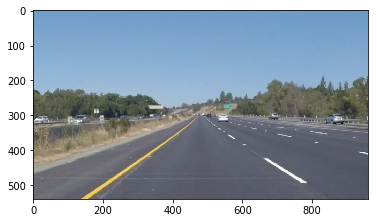

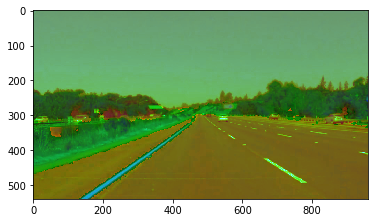

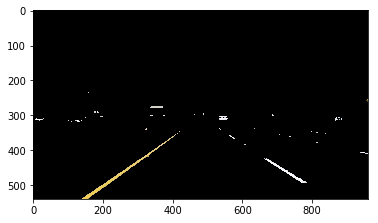

In [15]:
plt.imshow(select_color_line(mpimg.imread('test_images/solidYellowLeft.jpg'), test=True))


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))